In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
pd.set_option('display.max_columns',None)

In [2]:
def calc_t_value(n,mu,xbar,sample_std_devn):
    import numpy as np
    tvalue=(xbar-mu)/(sample_std_devn/np.sqrt(n))
    df=n-1
    return (tvalue,df)

In [3]:
def calc_two_sample_t_value(mu1,n1,x1bar,sample_std_devn1,mu2,n2,x2bar,sample_std_devn2):
    import numpy as np
    tvalue=((x1bar-x2bar)-(mu1-mu2))/np.sqrt(((sample_std_devn1**2)/n1)+((sample_std_devn2**2)/n2))
    nr=(((sample_std_devn1**2)/n1)+((sample_std_devn2**2)/n2))**2
    dr=((((sample_std_devn1**2)/n1)**2)/(n1-1))+((((sample_std_devn2**2)/n2)**2)/(n2-1))
    dof=nr/dr
    return (tvalue,dof)

In [4]:
def calc_oneway_anova_f_value(*groups:list):
    '''
    groups is tuple of list of samples
    '''
    import numpy as np

    all_data=[]
    for group in groups:
        all_data.extend(group)
        grand_mean=np.mean(all_data)

    # calculating SSB
    ssb=0
    for group in groups:
        group_mean=np.mean(group)
        group_size=len(group)
        ssb+=group_size*(group_mean-grand_mean)**2

    # calculating SSW
    ssw=0
    for group in groups:
        group_mean=np.mean(group)
        for val in group:
            ssw+=(val-group_mean)**2

    ## calculating dof
    k=len(groups)
    n=len(all_data)

    dof_b=k-1
    dof_w=n-k

    f_value=(ssb/dof_b)/(ssw/dof_w)
    return (f_value,dof_b,dof_w)

In [5]:
def twoway_anova_test(df,target_col,row_factor,column_factor):
    import pandas as pd
    import numpy as np
    from scipy.stats import f
    grand_mean=df[target_col].mean()
    total_n=len(df)

    row_levels=df[row_factor].unique()
    col_levels=df[column_factor].unique()


    #check for empty cell and storing mean of (row_level,column_level) mean in a dictionary
    empty_cell=[]
    cell_means={}
    datapoints_count={}

    for r in row_levels:
        for c in col_levels:
            sub_df=df[(df[row_factor]==r) & (df[column_factor]==c)]
            if len(sub_df)==0:
                empty_cell.append((r,c))
            else:
                cell_means[(r,c)]=sub_df[target_col].mean()
                datapoints_count[(r,c)]=len(sub_df)

    model='full'
    if len(empty_cell)>0:
        model='reduced'
        print(f'Empty cells found at {empty_cell},performing reduced anova test (No interaction Calculated)')


    print(f'Running Two-Way ANOVA {model}')

    # calculating SSR
    ssr=0
    dof_row=len(row_levels)-1
    for r in row_levels:
        sub_df=df[df[row_factor]==r]
        n_row=len(sub_df)
        row_mean=sub_df[target_col].mean()
        ssr+=n_row*(row_mean-grand_mean)**2

    # calculating SSC
    ssc=0
    dof_col=len(col_levels)-1
    for c in col_levels:
        sub_df=df[df[column_factor]==c]
        n_col=len(sub_df)
        col_mean=sub_df[target_col].mean()
        ssc+=n_col*(col_mean-grand_mean)**2

    ## calculating SSI and SSE
    ssi=0
    sse=0
    dof_interaction=(len(row_levels)-1)*(len(col_levels)-1)

    if model=='full':
        for r in row_levels:
            for c in col_levels:
                sub_df=df[(df[row_factor]==r)&(df[column_factor]==c)]
                n_datapoints=len(sub_df)
                
                row_global_mean=df[df[row_factor]==r][target_col].mean()
                col_gloabl_mean=df[df[column_factor]==c][target_col].mean()

                expected_mean=row_global_mean+col_gloabl_mean-grand_mean
                actual_mean=sub_df[target_col].mean()
                deviation=actual_mean-expected_mean

                ssi+=n_datapoints*(deviation**2)

                for i in sub_df[target_col]:
                    error=(i-actual_mean)**2
                    sse+=error

        dof_error=total_n-len(row_levels)*len(col_levels)

    else:
        ssi=0
        dof_interaction=0
        for idx,row in df.iterrows():
            r=row[row_factor]
            c=row[column_factor]

            row_mean=df[df[row_factor]==r][target_col].mean()
            col_mean=df[df[column_factor]==c][target_col].mean()

            expected=grand_mean-(row_mean-grand_mean)-(col_mean-grand_mean)
            actual=row[target_col]

            sse+=(actual-expected)**2

        dof_error=total_n-1-dof_row-dof_col

    # calculating F-vales and p-values and storing results
    ms_error=sse/dof_error

    results=[]

    #rows
    ms_row=ssr/dof_row
    f_row=ms_row/ms_error
    p_row=1-f.cdf(f_row,dof_row,dof_error)
    results.append([row_factor,ssr,dof_row,ms_row,f_row,p_row])

    #col
    ms_col=ssc/dof_col
    f_col=ms_col/ms_error
    p_col=1-f.cdf(f_col,dof_col,dof_error)
    results.append([column_factor,ssc,dof_col,ms_col,f_col,p_col])

    # interaction when model='full'
    if model=='full':
        ms_inter=ssi/dof_interaction
        f_inter=ms_inter/ms_error
        p_inter=1-f.cdf(f_inter,dof_interaction,dof_error)
        results.append(['interaction',ssi,dof_interaction,ms_inter,f_inter,p_inter])

    results.append(['Error',sse,dof_error,ms_error,np.nan,np.nan])


    result_df=pd.DataFrame(results,columns=('source','ss','dof','ms','f_value','p_value'))
    return result_df

In [6]:
df=pd.read_csv(r'property.csv')

In [7]:
df

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,4.0,2.0,2.0,652.0,NaN,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,3.0,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,3.0,2.0,4.0,436.0,NaN,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,4.0,1.0,5.0,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0


In [8]:
df.columns=df.columns.str.lower().str.replace(' ','_')

In [9]:
df.head()

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,yearbuilt,councilarea,lattitude,longtitude,regionname,propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   suburb         13580 non-null  object 
 1   address        13580 non-null  object 
 2   rooms          13580 non-null  int64  
 3   type           13580 non-null  object 
 4   price          13580 non-null  float64
 5   method         13580 non-null  object 
 6   sellerg        13580 non-null  object 
 7   date           13580 non-null  object 
 8   distance       13580 non-null  float64
 9   postcode       13580 non-null  float64
 10  bedroom2       13580 non-null  float64
 11  bathroom       13580 non-null  float64
 12  car            13518 non-null  float64
 13  landsize       13580 non-null  float64
 14  buildingarea   7130 non-null   float64
 15  yearbuilt      8205 non-null   float64
 16  councilarea    12211 non-null  object 
 17  lattitude      13580 non-null  float64
 18  longti

In [11]:
df.describe()

,rooms,price,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,yearbuilt,lattitude,longtitude,propertycount
count,13580.000000,1.358000e+04,13580.000000,13580.000000,13580.000000,13580.000000,13518.000000,13580.000000,7130.000000,8205.000000,13580.000000,13580.000000,13580.000000
mean,2.937997,1.075684e+06,10.137776,3105.301915,2.914728,1.534242,1.610075,558.416127,151.967650,1964.684217,-37.809203,144.995216,7454.417378
std,0.955748,6.393107e+05,5.868725,90.676964,0.965921,0.691712,0.962634,3990.669241,541.014538,37.273762,0.079260,0.103916,4378.581772
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,-38.182550,144.431810,249.000000
25%,2.000000,6.500000e+05,6.100000,3044.000000,2.000000,1.000000,1.000000,177.000000,93.000000,1940.000000,-37.856822,144.929600,4380.000000
50%,3.000000,9.030000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,440.000000,126.000000,1970.000000,-37.802355,145.000100,6555.000000
75%,3.000000,1.330000e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,651.000000,174.000000,1999.000000,-37.756400,145.058305,10331.000000
max,10.000000,9.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.000000,433014.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


In [12]:
df.isna().sum()

suburb              0
address             0
rooms               0
type                0
price               0
method              0
sellerg             0
date                0
distance            0
postcode            0
bedroom2            0
bathroom            0
car                62
landsize            0
buildingarea     6450
yearbuilt        5375
councilarea      1369
lattitude           0
longtitude          0
regionname          0
propertycount       0
dtype: int64

In [13]:
df.isna().sum()/len(df)

suburb           0.000000
address          0.000000
rooms            0.000000
type             0.000000
price            0.000000
method           0.000000
sellerg          0.000000
date             0.000000
distance         0.000000
postcode         0.000000
bedroom2         0.000000
bathroom         0.000000
car              0.004566
landsize         0.000000
buildingarea     0.474963
yearbuilt        0.395803
councilarea      0.100810
lattitude        0.000000
longtitude       0.000000
regionname       0.000000
propertycount    0.000000
dtype: float64

#### lets do two sample t-test for columns having missing values so that we can estimate the imputation strategy and evaluate the imputation strategy statistically
#### taking price as our target column
##### performing  two sample t-tests for missing values in columns compared to price

### Distribution Of Price

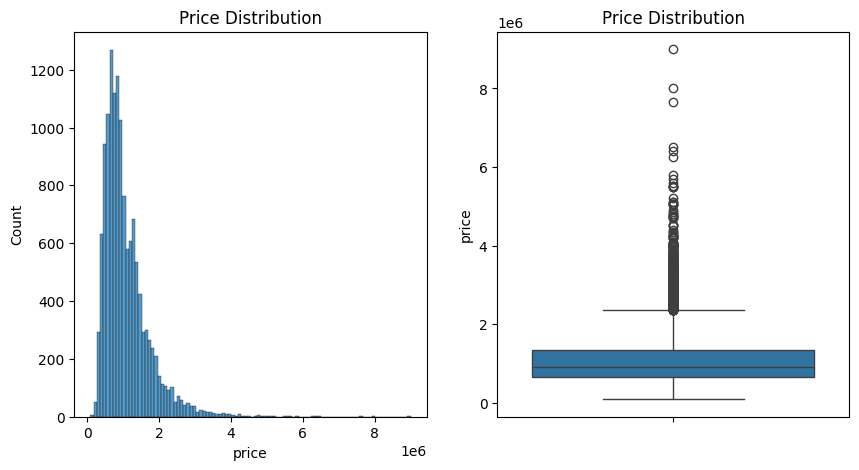

In [352]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.histplot(df['price'],bins=100)
plt.title("Price Distribution")

plt.subplot(1,2,2)
sns.boxplot(df['price'])
plt.title("Price Distribution")
plt.show()

In [354]:
print(f'skewness : {df['price'].skew()}')
print(f'kurtosis : {df['price'].kurt()}')
print(f'median : {df['price'].median()}')

skewness : 2.239169499656665
kurtosis : 9.871163172502797
median : 903500.0


In [353]:
df['price'].describe()

count    1.357200e+04
mean     1.075901e+06
std      6.394042e+05
min      8.500000e+04
25%      6.500000e+05
50%      9.035000e+05
75%      1.330000e+06
max      9.000000e+06
Name: price, dtype: float64

- price of properties are +vely skewed and higly laptokurtic
- 50% of prices of the property lies between approx 2 lakhs to 1300000
- max price goes upto 9 million
- extreme price indicates the price of premium properties available in most valuable suburbs and near to melbourne city center

##### comparing statistical metrics of 'price' when the column(s) values are null and notnull

#### missing values in Car vs Price

In [14]:
analysis_result=[]
alpha=0.05

In [15]:
cp_x1bar=df['price'][df['car'].notnull()].mean()
cp_s1=df['price'][df['car'].notnull()].std()
cp_n1=len(df['price'][df['car'].notnull()])
cp_x2bar=df['price'][df['car'].isna()].mean()
cp_s2=df['price'][df['car'].isna()].std()
cp_n2=len(df['price'][df['car'].isna()])
print(f"x1bar : {cp_x1bar}")
print(f"x2bar : {cp_x2bar}")
print(f"s1    : {cp_s1}")
print(f"s2    : {cp_s2}")
print(f"n1    : {cp_n1}")
print(f"n2    : {cp_n2}")

x1bar : 1074796.404719633
x2bar : 1269225.8064516129
s1    : 639858.5588623529
s2    : 471048.8008324959
n1    : 13518
n2    : 62


- 1-notnull values
- 2-null values

- null hypothesis :  H0 : there is no difference in the means where car value is null and not null
- H0 : mu1-mu2=0
- alternate hypotheis : H1 : there is a significant difference in means
- H1 : mu1-mu2!=0
- alpha=0.05
- two tailed test

In [16]:
cp_t_value=calc_two_sample_t_value(mu1=0,n1=cp_n1,x1bar=cp_x1bar,sample_std_devn1=cp_s1,mu2=0,n2=cp_n2,x2bar=cp_x2bar,sample_std_devn2=cp_s2)
cp_t_value

(np.float64(-3.2363980820376264), np.float64(62.0368135006911))

since it is two tailed test

In [17]:
cp_p_value=2*(1-stats.t.cdf(abs(cp_t_value[0]),cp_t_value[1]))
cp_p_value

np.float64(0.0019438881686975051)

- since pvalue(0.001943....) < alpha(0.05)
- thus reject the null hypothesis that means of the two samples when car value is null and notnull respectively is equal
- we cannot directly impute mean or median or mode,it may bring biasness in the price column

In [18]:
analysis_result.append(['car',cp_x1bar,cp_x2bar,cp_s1,cp_s2,cp_n1,cp_n2,cp_t_value[0],cp_t_value[1],cp_p_value,'reject null' if cp_p_value<alpha else 'fail to reject'])

### missing values in building area VS price 

In [19]:
bp_x1bar=df['price'][df['buildingarea'].notnull()].mean()
bp_s1=df['price'][df['buildingarea'].notnull()].std()
bp_n1=len(df['price'][df['buildingarea'].notnull()])
bp_x2bar=df['price'][df['buildingarea'].isna()].mean()
bp_s2=df['price'][df['buildingarea'].isna()].std()
bp_n2=len(df['price'][df['buildingarea'].isna()])
print(f"x1bar : {bp_x1bar}")
print(f"x2bar : {bp_x2bar}")
print(f"s1    : {bp_s1}")
print(f"s2    : {bp_s2}")
print(f"n1    : {bp_n1}")
print(f"n2    : {bp_n2}")

x1bar : 1079922.7260869564
x2bar : 1070998.567751938
s1    : 674692.1990579305
s2    : 597784.4279741595
n1    : 7130
n2    : 6450


- 1 not null values
- 2 null values

- null hypothesis :  H0 : there is no difference in the means where buildingarea value is null and not null
- H0 : mu1-mu2=0
- alternate hypotheis : H1 : there is a significant difference in means
- H1 : mu1-mu2!=0
- alpha=0.05
- two tailed test

In [20]:
bp_t_value=calc_two_sample_t_value(mu1=0,mu2=0,x1bar=bp_x1bar,x2bar=bp_x2bar,sample_std_devn1=bp_s1,sample_std_devn2=bp_s2,n1=bp_n1,n2=bp_n2)
bp_t_value

(np.float64(0.8172293364278005), np.float64(13572.163528353309))

In [21]:
bp_p_value=2*(1-stats.t.cdf(abs(bp_t_value[0]),bp_t_value[1]))
bp_p_value

np.float64(0.41381172557229684)

- since p-value(0.4138.....) > alpha(0.05)
- thus we fail to reject the null hypothesis,thus we don't have enough veidence to claim that there is no difference in means
- thus we can directly impute mean or median as the building area column is numerical

In [22]:
analysis_result.append(['building area',bp_x1bar,bp_x2bar,bp_s1,bp_s2,bp_n1,bp_n2,bp_t_value[0],bp_t_value[1],bp_p_value,'reject null' if bp_p_value<alpha else 'fail to reject'])

In [23]:
print(analysis_result)

[['car', np.float64(1074796.404719633), np.float64(1269225.8064516129), np.float64(639858.5588623529), np.float64(471048.8008324959), 13518, 62, np.float64(-3.2363980820376264), np.float64(62.0368135006911), np.float64(0.0019438881686975051), 'reject null'], ['building area', np.float64(1079922.7260869564), np.float64(1070998.567751938), np.float64(674692.1990579305), np.float64(597784.4279741595), 7130, 6450, np.float64(0.8172293364278005), np.float64(13572.163528353309), np.float64(0.41381172557229684), 'fail to reject']]


#### missing values in year built VS price

In [24]:
yp_x1bar=df[df['yearbuilt'].notnull()]['price'].mean()
yp_s1=df[df['yearbuilt'].notnull()]['price'].std()
yp_n1=len(df[df['yearbuilt'].notnull()]['price'])
yp_x2bar=df[df['yearbuilt'].isna()]['price'].mean()
yp_s2=df[df['yearbuilt'].isna()]['price'].std()
yp_n2=len(df[df['yearbuilt'].isna()]['price'])
print(f"x1bar : {yp_x1bar}")
print(f"x2bar : {yp_x2bar}")
print(f"s1    : {yp_s1}")
print(f"s2    : {yp_s2}")
print(f"n1    : {yp_n1}")
print(f"n2    : {yp_n2}")

x1bar : 1065796.9745277269
x2bar : 1090776.8600930232
s1    : 666257.1539569768
s2    : 595575.7257560204
n1    : 8205
n2    : 5375


- 1 not null values
- 2 null values

- null hypothesis :  H0 : there is no difference in the means where yearbuilt value is null and not null
- H0 : mu1-mu2=0
- alternate hypotheis : H1 : there is a significant difference in means
- H1 : mu1-mu2!=0
- alpha=0.05
- two tailed test

In [25]:
yp_t_value=calc_two_sample_t_value(mu1=0,mu2=0,x1bar=yp_x1bar,x2bar=yp_x2bar,sample_std_devn1=yp_s1,sample_std_devn2=yp_s2,n1=yp_n1,n2=yp_n2)
yp_t_value

(np.float64(-2.279452059914648), np.float64(12356.94556063343))

In [26]:
yp_p_value=2*(1-stats.t.cdf(abs(yp_t_value[0]),yp_t_value[1]))
yp_p_value

np.float64(0.02265717643231069)

- since p-value(0.03322....) < alpha(0.05)
- thus we reject the null hypothesis that there is no difference in the means when year built has null values and notnull values
-- we cannot directly impute mean or median or mode,it may bring biasness in the price column

In [27]:
analysis_result.append(['year built',yp_x1bar,yp_x2bar,yp_s1,yp_s2,yp_n1,yp_n2,yp_t_value[0],yp_t_value[1],yp_p_value,'reject null' if yp_p_value<alpha else 'fail to reject'])

### missing values in Council Area VS price

In [28]:
cap_x1bar=df[df['councilarea'].notnull()]['price'].mean()
cap_s1=df[df['councilarea'].notnull()]['price'].std()
cap_n1=len(df[df['councilarea'].notnull()]['price'])
cap_x2bar=df[df['councilarea'].isna()]['price'].mean()
cap_s2=df[df['councilarea'].isna()]['price'].std()
cap_n2=len(df[df['councilarea'].isna()]['price'])
print(f"x1bar : {cap_x1bar}")
print(f"x2bar : {cap_x2bar}")
print(f"s1    : {cap_s1}")
print(f"s2    : {cap_s2}")
print(f"n1    : {cap_n1}")
print(f"n2    : {cap_n2}")

x1bar : 1063691.8719187619
x2bar : 1182650.3659605552
s1    : 638861.3346514603
s2    : 633569.1521898374
n1    : 12211
n2    : 1369


- 1 not null values
- 2 null values

- null hypothesis :  H0 : there is no difference in the means where councilarea value is null and not null
- H0 : mu1-mu2=0
- alternate hypotheis : H1 : there is a significant difference in means
- H1 : mu1-mu2!=0
- alpha=0.05
- two tailed test

In [29]:
cap_t_value=calc_two_sample_t_value(mu1=0,mu2=0,x1bar=cap_x1bar,x2bar=cap_x2bar,sample_std_devn1=cap_s1,sample_std_devn2=cap_s2,n1=cap_n1,n2=cap_n2)
cap_t_value

(np.float64(-6.582061989677184), np.float64(1695.1925539594251))

In [30]:
cap_p_value=2*(1-stats.t.cdf(abs(cap_t_value[0]),cap_t_value[1]))
cap_p_value

np.float64(6.167621968700132e-11)

- since pvalue(6.167621968700132e-11) < alpha(0.05)
- thus we reject the null hypothesis that means when council area notnull vs null is equal
- we cannot directly impute mean or median or mode,it may bring biasness in the price column

In [31]:
analysis_result.append(['council area',cap_x1bar,cap_x2bar,cap_s1,cap_s2,cap_n1,cap_n2,cap_t_value[0],cap_t_value[1],cap_p_value,'reject null' if cap_p_value<alpha else 'fail to reject'])

In [32]:
analysis_df=pd.DataFrame(analysis_result,columns=('missing_value_column','sample_mean_1','sample_mean_2','sample std_devn_1','sample std_devn_2','no_samples_1','no_samples_2','t_value','dof','p_value','conclusion'))
analysis_df

,missing_value_column,sample_mean_1,sample_mean_2,sample std_devn_1,sample std_devn_2,no_samples_1,no_samples_2,t_value,dof,p_value,conclusion
0,car,1.074796e+06,1.269226e+06,639858.558862,471048.800832,13518,62,-3.236398,62.036814,1.943888e-03,reject null
1,building area,1.079923e+06,1.070999e+06,674692.199058,597784.427974,7130,6450,0.817229,13572.163528,4.138117e-01,fail to reject
2,year built,1.065797e+06,1.090777e+06,666257.153957,595575.725756,8205,5375,-2.279452,12356.945561,2.265718e-02,reject null
3,council area,1.063692e+06,1.182650e+06,638861.334651,633569.152190,12211,1369,-6.582062,1695.192554,6.167622e-11,reject null


In [33]:
def interpret_result(x,colname):
    if x[colname]=='reject null':
        return 'biased-data | (Missing rows = Higher Price)'
    else:
        return 'safe/random'
    
analysis_df['interpretation']=analysis_df.apply(interpret_result,colname='conclusion',axis=1)
analysis_df

,missing_value_column,sample_mean_1,sample_mean_2,sample std_devn_1,sample std_devn_2,no_samples_1,no_samples_2,t_value,dof,p_value,conclusion,interpretation
0,car,1.074796e+06,1.269226e+06,639858.558862,471048.800832,13518,62,-3.236398,62.036814,1.943888e-03,reject null,biased-data | (Missing rows = Higher Price)
1,building area,1.079923e+06,1.070999e+06,674692.199058,597784.427974,7130,6450,0.817229,13572.163528,4.138117e-01,fail to reject,safe/random
2,year built,1.065797e+06,1.090777e+06,666257.153957,595575.725756,8205,5375,-2.279452,12356.945561,2.265718e-02,reject null,biased-data | (Missing rows = Higher Price)
3,council area,1.063692e+06,1.182650e+06,638861.334651,633569.152190,12211,1369,-6.582062,1695.192554,6.167622e-11,reject null,biased-data | (Missing rows = Higher Price)


### Analysis
- we cannot drop the rows of car,yearbuilt,coucil_area as it bring biasness to the price
- missing values in the building_area can directly be filled with mean/median
- missing values in car column
    - filling with 0 - 'nan' means 'no parking spot'
- missing values in councilArea column
    - filling nan taking reference from postcode
    - if all the councilarea is nan for given postcode,then taking reference from suburb
    - still there there will be nan then filling with 'unknown'
- missing values in YearBuilt column
    - filling the local median year by suburb
    - logic: for a given suburb,most of the buildings ae built in a given range of year

### let's see if we impute Building Area missing values with median then is there any statistical difference using two sample t-test

In [34]:
x1bar=df[df['buildingarea'].notnull()]['price'].mean()
x2bar=df[df['buildingarea'].fillna(df['buildingarea'].median()).notnull()]['price'].mean()
s1=df[df['buildingarea'].notnull()]['price'].std()
s2=df[df['buildingarea'].fillna(df['buildingarea'].median()).notnull()]['price'].std()
n1=len(df[df['buildingarea'].notnull()]['price'])
n2=len(df[df['buildingarea'].fillna(df['buildingarea'].median()).notnull()]['price'])
print(f"x1bar : {x1bar}")
print(f"x2bar : {x2bar}")
print(f"s1    : {s1}")
print(f"s2    : {s2}")
print(f"n1    : {n1}")
print(f"n2    : {n2}")

x1bar : 1079922.7260869564
x2bar : 1075684.079455081
s1    : 674692.1990579305
s2    : 639310.724296018
n1    : 7130
n2    : 13580


- 1-when the there are missing values and not imputed
- 2-when the missing is imputed with median
- null hypothesis H0: there is no difference in means of 1 and 2
- H0 : m1-mu=0
- alternate hypothesis H1 : there is a significant difference in both the means
- H1 : mu1-mu2!=0
- alpha= 0.05
- two tailed test

In [35]:
t_value=calc_two_sample_t_value(mu1=0,
            mu2=0,
            x1bar=x1bar,
            x2bar=x2bar,
            sample_std_devn1=s1,
            sample_std_devn2=s2,
            n1=n1,
            n2=n2)
print(f't_value : {t_value}')
p_value=2*(1-stats.t.cdf(abs(t_value[0]),t_value[1]))
print(f"p_value : {p_value}")

t_value : (np.float64(0.4373195215197357), np.float64(13822.060732967537))
p_value : 0.6618864722344382


- since pvalue(0.6618) > alpha(0.05)
- thus fail to reject the null hypothesis, that we don't enough evidence that both the means are not equal

In [36]:
df['buildingarea'].fillna(df['buildingarea'].median())

0        126.0
1         79.0
2        150.0
3        126.0
4        142.0
         ...  
13575    126.0
13576    133.0
13577    126.0
13578    157.0
13579    112.0
Name: buildingarea, Length: 13580, dtype: float64

In [37]:
df.loc[df['buildingarea'].isna(),'buildingarea']=df['buildingarea'].median()

In [38]:
df['buildingarea'].isna().sum()

np.int64(0)

##### thus above test shows that filling building area with median doesn't brought biasness and anyway shifted the means in both the case

### lets see impact of imputing 0 where car's column values are missing using two sample t-test
- imputing 0 as assuming car column reperesents number of cars that can be parked and whereever there is mising values will be filled with 0 assuming the house does not have parking available

In [39]:
x1bar=df[df['car'].notnull()]['price'].mean()
x2bar=df[df['car'].fillna(0).notnull()]['price'].mean()
s1=df[df['car'].notnull()]['price'].std()
s2=df[df['car'].fillna(0).notnull()]['price'].std()
n1=len(df[df['car'].notnull()]['price'])
n2=len(df[df['car'].fillna(0).notnull()]['price'])
print(f"x1bar : {x1bar}")
print(f"x2bar : {x2bar}")
print(f"s1    : {s1}")
print(f"s2    : {s2}")
print(f"n1    : {n1}")
print(f"n2    : {n2}")


x1bar : 1074796.404719633
x2bar : 1075684.079455081
s1    : 639858.5588623529
s2    : 639310.724296018
n1    : 13518
n2    : 13580


- 1-when the there are missing values and not imputed
- 2-when the missing is imputed with 0
- null hypothesis H0: there is no difference in means of 1 and 2
- H0 : m1-mu=0
- alternate hypothesis H1 : there is a significant difference in both the means
- H1 : mu1-mu2!=0
- alpha= 0.05
- two tailed test

In [40]:
t_value=calc_two_sample_t_value(mu1=0,
            mu2=0,
            x1bar=x1bar,
            x2bar=x2bar,
            sample_std_devn1=s1,
            sample_std_devn2=s2,
            n1=n1,
            n2=n2)
print(f't_value : {t_value}')
p_value=2*(1-stats.t.cdf(abs(t_value[0]),t_value[1]))
print(f"p_value : {p_value}")

t_value : (np.float64(-0.1142333345587054), np.float64(27095.200303791302))
p_value : 0.9090536741010233


- since pvalue(0.9090...) > alpha(0.05)
- thus we fail to reject the null hypothesis,thus we don't have enough statistical evidence that both means are not equal
- therfore we can impue the missing values in car column with 0

In [41]:
df.loc[df['car'].isna(),'car']=0

In [42]:
df.isna().sum()

suburb              0
address             0
rooms               0
type                0
price               0
method              0
sellerg             0
date                0
distance            0
postcode            0
bedroom2            0
bathroom            0
car                 0
landsize            0
buildingarea        0
yearbuilt        5375
councilarea      1369
lattitude           0
longtitude          0
regionname          0
propertycount       0
dtype: int64

### Analysis
- we cannot drop the rows of car,yearbuilt,coucil_area as it bring biasness to the price
- missing values in the building_area can directly be filled with mean/median ✓
- missing values in car column
    - filling with 0 - 'nan' means 'no parking spot' ✓
- missing values in councilArea column
    - filling nan taking reference from postcode
    - if all the councilarea is nan for given postcode,then taking reference from suburb
    - still there there will be nan then filling with 'unknown'
- missing values in YearBuilt column
    - filling the local median year by suburb
    - logic: for a given suburb,most of the buildings ae built in a given range of year

#### lets group by 'suburb' to check what are the median years for the given suburb

In [43]:
suburb_median=df.groupby(['suburb'],as_index=False).agg(median_year=('yearbuilt','median'))
suburb_median

,suburb,median_year
0,Abbotsford,1935.0
1,Aberfeldie,1980.0
2,Airport West,1980.0
3,Albanvale,1980.0
4,Albert Park,1900.0
...,...,...
309,Wonga Park,NaN
310,Wyndham Vale,2005.0
311,Yallambie,1978.0
312,Yarra Glen,1975.0


In [44]:
print(f"Wait! there are {suburb_median['median_year'].isna().sum()} 'suburbs'  whose median_year is nan")

Wait! there are 12 'suburbs'  whose median_year is nan


#### let's chekc for suburb's whose median_year is null

In [45]:
median_year_nan=suburb_median[suburb_median['median_year'].isna()]
median_year_nan

,suburb,median_year
16,Aspendale Gardens,NaN
17,Attwood,NaN
19,Bacchus Marsh,NaN
50,Bullengarook,NaN
91,Croydon South,NaN
102,Docklands,NaN
198,Monbulk,NaN
211,New Gisborne,NaN
243,Rockbank,NaN
254,Silvan,NaN


#### lets see number of records which will be unaffected after imputation with median_year seggregated by suburb

In [46]:
suburb_yearbuilt_count=df.groupby(['suburb','yearbuilt'],as_index=False,dropna=False).agg(count=('suburb','count'))
suburb_yearbuilt_count

,suburb,yearbuilt,count
0,Abbotsford,1880.0,2
1,Abbotsford,1888.0,1
2,Abbotsford,1890.0,4
3,Abbotsford,1900.0,9
4,Abbotsford,1910.0,1
...,...,...,...
3993,Yarraville,2013.0,3
3994,Yarraville,2014.0,1
3995,Yarraville,2016.0,3
3996,Yarraville,2017.0,1


In [47]:
suburb_yearbuilt_na_count=suburb_yearbuilt_count[suburb_yearbuilt_count['yearbuilt'].isna()]
suburb_yearbuilt_na_count

,suburb,yearbuilt,count
21,Abbotsford,NaN,18
40,Aberfeldie,NaN,14
61,Airport West,NaN,25
63,Albanvale,NaN,4
74,Albert Park,NaN,32
...,...,...,...
3944,Wollert,NaN,5
3945,Wonga Park,NaN,1
3949,Wyndham Vale,NaN,1
3960,Yallambie,NaN,7


In [48]:
print(f"checking for existence of {median_year_nan['suburb'].values} in suburb_yearbuilt_na_count to get the count")
print(suburb_yearbuilt_na_count[suburb_yearbuilt_na_count['suburb'].isin(median_year_nan['suburb'].values)])
print(f"so there {suburb_yearbuilt_na_count[suburb_yearbuilt_na_count['suburb'].isin(median_year_nan['suburb'].values)]['count'].sum()} records will be left unaffected")

checking for existence of ['Aspendale Gardens' 'Attwood' 'Bacchus Marsh' 'Bullengarook'
 'Croydon South' 'Docklands' 'Monbulk' 'New Gisborne' 'Rockbank' 'Silvan'
 'Upwey' 'Wonga Park'] in suburb_yearbuilt_na_count to get the count
                 suburb  yearbuilt  count
252   Aspendale Gardens        NaN      4
253             Attwood        NaN      1
273       Bacchus Marsh        NaN      1
745        Bullengarook        NaN      1
1196      Croydon South        NaN      1
1242          Docklands        NaN      3
2552            Monbulk        NaN      1
2705       New Gisborne        NaN      1
3189           Rockbank        NaN      1
3283             Silvan        NaN      2
3729              Upwey        NaN      1
3945         Wonga Park        NaN      1
so there 18 records will be left unaffected


#### so only 18 records will be unaffected which can be imputed using global median
#### let's impute and test for affect in means of price

In [49]:
if  suburb_yearbuilt_na_count[suburb_yearbuilt_na_count['suburb'].isin(median_year_nan['suburb'].values)]['count'].sum()>50:
        print("ohh that will be a mess,it will bias the house price, we need a new strategy")
else:
    print(f"so there will only {suburb_yearbuilt_na_count[suburb_yearbuilt_na_count['suburb'].isin(median_year_nan['suburb'].values)]['count'].sum()} records to impute again with global median")
    df_merged=pd.merge(left=df,right=suburb_median,on='suburb',how='inner')
    df_merged['yearbuilt_imputed']=df_merged['yearbuilt'].fillna(df_merged['median_year'])
    df_merged.loc[df_merged['yearbuilt_imputed'].isna(),'yearbuilt_imputed']=df_merged['yearbuilt_imputed'].median()
    print(f"now have {df_merged['yearbuilt_imputed'].isna().sum()} records to impute in yearbuilt_imputed column")

so there will only 18 records to impute again with global median
now have 0 records to impute in yearbuilt_imputed column


In [50]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   suburb             13580 non-null  object 
 1   address            13580 non-null  object 
 2   rooms              13580 non-null  int64  
 3   type               13580 non-null  object 
 4   price              13580 non-null  float64
 5   method             13580 non-null  object 
 6   sellerg            13580 non-null  object 
 7   date               13580 non-null  object 
 8   distance           13580 non-null  float64
 9   postcode           13580 non-null  float64
 10  bedroom2           13580 non-null  float64
 11  bathroom           13580 non-null  float64
 12  car                13580 non-null  float64
 13  landsize           13580 non-null  float64
 14  buildingarea       13580 non-null  float64
 15  yearbuilt          8205 non-null   float64
 16  councilarea        122

two sample t-test to compare the statistical metrics when missing value column is not imputed  and when imputed

In [51]:
x1bar=df_merged[df_merged['yearbuilt_imputed'].notnull()]['price'].mean()
x2bar=df[df['yearbuilt'].notnull()]['price'].mean()
s1=df_merged[df_merged['yearbuilt_imputed'].notnull()]['price'].std()
s2=df[df['yearbuilt'].notnull()]['price'].std()
n1=len(df_merged[df_merged['yearbuilt_imputed'].notnull()]['price'])
n2=len(df[df['yearbuilt'].notnull()]['price'])
print(f"x1bar : {x1bar}")
print(f"x2bar : {x2bar}")
print(f"s1    : {s1}")
print(f"s2    : {s2}")
print(f"n1    : {n1}")
print(f"n2    : {n2}")

x1bar : 1075684.079455081
x2bar : 1065796.9745277269
s1    : 639310.724296018
s2    : 666257.1539569768
n1    : 13580
n2    : 8205


- 1-when the there are missing values are imputed
- 2-when the missing is not imputed
- null hypothesis H0: there is no difference in means of 1 and 2
- H0 : m1-mu=0
- alternate hypothesis H1 : there is a significant difference in both the means
- H1 : mu1-mu2!=0
- alpha= 0.05
- two tailed test

In [52]:

t_value=calc_two_sample_t_value(mu1=0,
            mu2=0,
            x1bar=x1bar,
            x2bar=x2bar,
            sample_std_devn1=s1,
            sample_std_devn2=s2,
            n1=n1,
            n2=n2)
print(f't_value : {t_value}')
p_value=2*(1-stats.t.cdf(abs(t_value[0]),t_value[1]))
print(f"p_value : {p_value}")

t_value : (np.float64(1.0775020644684425), np.float64(16740.787727143295))
p_value : 0.28127155506235635


- since p_value(0.281271...) > alpha(0.05)
- thus we reject the null hypothesis,we don't have enough statistical evidence to say that both the means are not equal
- so we gonna imputed with the same strategy

#### there fore we can safely go with the new df_merged dataframe
#### lets store back the modified dataframe in df

In [53]:
df=df_merged.copy()

In [54]:
df

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,yearbuilt,councilarea,lattitude,longtitude,regionname,propertycount,median_year,yearbuilt_imputed
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,126.0,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,1935.0,1935.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0,1935.0,1900.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0,1935.0,1900.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,126.0,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0,1935.0,1935.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0,1935.0,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,4.0,2.0,2.0,652.0,126.0,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0,1974.5,1981.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,3.0,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0,1980.0,1995.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,3.0,2.0,4.0,436.0,126.0,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0,1980.0,1997.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,4.0,1.0,5.0,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0,1980.0,1920.0


### Analysis
- we cannot drop the rows of car,yearbuilt,coucil_area as it bring biasness to the price
- missing values in the building_area can directly be filled with mean/median ✓
- missing values in car column
    - filling with 0 - 'nan' means 'no parking spot' ✓
- missing values in councilArea column
    - filling nan taking reference from postcode
    - if all the councilarea is nan for given postcode,then taking reference from suburb
    - still there there will be nan then filling with 'unknown'
- missing values in YearBuilt column
    - filling the local median year by suburb
    - logic: for a given suburb,most of the buildings ae built in a given range of year ✓

#### Now we have to correct down the councilarea column

In [55]:
df

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,yearbuilt,councilarea,lattitude,longtitude,regionname,propertycount,median_year,yearbuilt_imputed
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,126.0,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,1935.0,1935.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0,1935.0,1900.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0,1935.0,1900.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,126.0,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0,1935.0,1935.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0,1935.0,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,4.0,2.0,2.0,652.0,126.0,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0,1974.5,1981.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,3.0,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0,1980.0,1995.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,3.0,2.0,4.0,436.0,126.0,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0,1980.0,1997.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,4.0,1.0,5.0,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0,1980.0,1920.0


#### Finding the suburb,councilarea and their councilarea count in council area column

In [56]:
suburb_councilarea_count=df.groupby(['suburb','councilarea'],as_index=False,dropna=False).agg(councilarea_count=('postcode','count')).sort_values(by=['suburb','councilarea'])
suburb_councilarea_count

,suburb,councilarea,councilarea_count
0,Abbotsford,Yarra,55
1,Abbotsford,NaN,1
2,Aberfeldie,Moonee Valley,40
3,Aberfeldie,NaN,4
4,Airport West,Moonee Valley,61
...,...,...,...
596,Yallambie,Banyule,23
597,Yallambie,NaN,1
598,Yarra Glen,Yarra Ranges,1
599,Yarraville,Maribyrnong,154


In [57]:
council_counts=df.groupby(['suburb','councilarea'],as_index=False).agg(council_count=('councilarea','count')).sort_values(by=['council_count'],ascending=False)
council_counts

,suburb,councilarea,council_count
257,Reservoir,Darebin,323
258,Richmond,Yarra,251
30,Bentleigh East,Glen Eira,234
255,Preston,Darebin,228
126,Essendon,Moonee Valley,208
...,...,...,...
254,Preston,Banyule,1
286,Springvale South,Greater Dandenong,1
283,Southbank,Port Phillip,1
318,Waterways,Kingston,1


finding the councilarea for suburb with maximum council count

In [58]:
suburb_council_mode=council_counts.drop_duplicates(subset=['suburb'])[['suburb','councilarea']]
suburb_council_mode

,suburb,councilarea
257,Reservoir,Darebin
258,Richmond,Yarra
30,Bentleigh East,Glen Eira
255,Preston,Darebin
126,Essendon,Moonee Valley
...,...,...
264,Rockbank,Melton
259,Riddells Creek,Macedon Ranges
286,Springvale South,Greater Dandenong
318,Waterways,Kingston


In [59]:
suburb_council_mode=suburb_council_mode.rename(columns={'councilarea':'suburb_council_mode'})

In [60]:
suburb_council_mode

,suburb,suburb_council_mode
257,Reservoir,Darebin
258,Richmond,Yarra
30,Bentleigh East,Glen Eira
255,Preston,Darebin
126,Essendon,Moonee Valley
...,...,...
264,Rockbank,Melton
259,Riddells Creek,Macedon Ranges
286,Springvale South,Greater Dandenong
318,Waterways,Kingston


### merging the df and suburb_council_mode

In [61]:
df_merged=pd.merge(left=df,right=suburb_council_mode,on='suburb',how='inner')
df_merged

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,yearbuilt,councilarea,lattitude,longtitude,regionname,propertycount,median_year,yearbuilt_imputed,suburb_council_mode
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,126.0,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,1935.0,1935.0,Yarra
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0,1935.0,1900.0,Yarra
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0,1935.0,1900.0,Yarra
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,126.0,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0,1935.0,1935.0,Yarra
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0,1935.0,2014.0,Yarra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13568,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,4.0,2.0,2.0,652.0,126.0,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0,1974.5,1981.0,Monash
13569,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,3.0,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0,1980.0,1995.0,Hobsons Bay
13570,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,3.0,2.0,4.0,436.0,126.0,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0,1980.0,1997.0,Hobsons Bay
13571,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,4.0,1.0,5.0,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0,1980.0,1920.0,Hobsons Bay


In [62]:
df_merged['councilarea'].fillna(df_merged['suburb_council_mode'])

0              Yarra
1              Yarra
2              Yarra
3              Yarra
4              Yarra
            ...     
13568         Monash
13569    Hobsons Bay
13570    Hobsons Bay
13571    Hobsons Bay
13572    Maribyrnong
Name: councilarea, Length: 13573, dtype: object

In [63]:
df_merged['councilarea_imputed']=df_merged['councilarea'].fillna(df_merged['suburb_council_mode'])
df_merged.isna().sum()

suburb                    0
address                   0
rooms                     0
type                      0
price                     0
method                    0
sellerg                   0
date                      0
distance                  0
postcode                  0
bedroom2                  0
bathroom                  0
car                       0
landsize                  0
buildingarea              0
yearbuilt              5371
councilarea            1362
lattitude                 0
longtitude                0
regionname                0
propertycount             0
median_year              15
yearbuilt_imputed         0
suburb_council_mode       0
councilarea_imputed       0
dtype: int64

- we have successfully imputed the missing values in all the columns required
- now lets check with two sample test that. is there any effect in price mean after imputation or not ?

In [64]:
x1bar=df_merged[df_merged['councilarea_imputed'].notnull()]['price'].mean()
x2bar=df[df['councilarea'].notnull()]['price'].mean()
s1=df_merged[df_merged['councilarea_imputed'].notnull()]['price'].std()
s2=df[df['councilarea'].notnull()]['price'].std()
n1=len(df_merged[df_merged['councilarea_imputed'].notnull()]['price'])
n2=len(df[df['councilarea'].notnull()]['price'])
print(f"x1bar : {x1bar}")
print(f"x2bar : {x2bar}")
print(f"s1    : {s1}")
print(f"s2    : {s2}")
print(f"n1    : {n1}")
print(f"n2    : {n2}")


x1bar : 1075874.5891844102
x2bar : 1063691.8719187619
s1    : 639387.896671043
s2    : 638861.3346514603
n1    : 13573
n2    : 12211


- 1-when the there are missing values are imputed
- 2-when the missing is not imputed
- null hypothesis H0: there is no difference in means of 1 and 2
- H0 : m1-mu=0
- alternate hypothesis H1 : there is a significant difference in both the means
- H1 : mu1-mu2!=0
- alpha= 0.05
- two tailed test

In [65]:
t_value=calc_two_sample_t_value(mu1=0,
            mu2=0,
            x1bar=x1bar,
            x2bar=x2bar,
            sample_std_devn1=s1,
            sample_std_devn2=s2,
            n1=n1,
            n2=n2)
print(f't_value : {t_value}')
p_value=2*(1-stats.t.cdf(abs(t_value[0]),t_value[1]))
print(f"p_value : {p_value}")

t_value : (np.float64(1.5282923115305835), np.float64(25500.98032554773))
p_value : 0.12645238092377875


- since p_balue(0.12645.....) > alpha(0.05)
- thus we fail to reject the null hypothesis,we don't enough statistical evidence to prove that means of both are ot equal at 0.05 sigificance level
- thus we can preserve the updated dataframe 'df_merged' back to 'df'

In [66]:
df=df_merged.copy()
df.isna().sum()

suburb                    0
address                   0
rooms                     0
type                      0
price                     0
method                    0
sellerg                   0
date                      0
distance                  0
postcode                  0
bedroom2                  0
bathroom                  0
car                       0
landsize                  0
buildingarea              0
yearbuilt              5371
councilarea            1362
lattitude                 0
longtitude                0
regionname                0
propertycount             0
median_year              15
yearbuilt_imputed         0
suburb_council_mode       0
councilarea_imputed       0
dtype: int64

#### removing columns which are not required now in the dataset

In [67]:
df.drop(columns=['median_year','councilarea','yearbuilt','suburb_council_mode'],inplace=True)

In [68]:
df.head()

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt_imputed,councilarea_imputed
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,126.0,-37.7996,144.9984,Northern Metropolitan,4019.0,1935.0,Yarra
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,-37.8079,144.9934,Northern Metropolitan,4019.0,1900.0,Yarra
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,-37.8093,144.9944,Northern Metropolitan,4019.0,1900.0,Yarra
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,126.0,-37.7969,144.9969,Northern Metropolitan,4019.0,1935.0,Yarra
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,-37.8072,144.9941,Northern Metropolitan,4019.0,2014.0,Yarra


#### renaming the improved columns back to their original names

In [69]:
df.rename(columns={'yearbuilt_imputed':'yearbuilt','councilarea_imputed':'councilarea'},inplace=True)

In [70]:
df.isna().sum()

suburb           0
address          0
rooms            0
type             0
price            0
method           0
sellerg          0
date             0
distance         0
postcode         0
bedroom2         0
bathroom         0
car              0
landsize         0
buildingarea     0
lattitude        0
longtitude       0
regionname       0
propertycount    0
yearbuilt        0
councilarea      0
dtype: int64

### Analysis
- we cannot drop the rows of car,yearbuilt,coucil_area as it bring biasness to the price
- missing values in the building_area can directly be filled with mean/median ✓
- missing values in car column
    - filling with 0 - 'nan' means 'no parking spot' ✓
- missing values in councilArea column
    - filling nan taking reference from postcode
    - if all the councilarea is nan for given postcode,then taking reference from suburb
    - still there there will be nan then filling with 'unknown'                                 ✓
- missing values in YearBuilt column
    - filling the local median year by suburb
    - logic: for a given suburb,most of the buildings ae built in a given range of year ✓

#### Now we have all the columns fixed

In [71]:
df

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,126.0,-37.79960,144.99840,Northern Metropolitan,4019.0,1935.0,Yarra
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,-37.80790,144.99340,Northern Metropolitan,4019.0,1900.0,Yarra
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,-37.80930,144.99440,Northern Metropolitan,4019.0,1900.0,Yarra
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,126.0,-37.79690,144.99690,Northern Metropolitan,4019.0,1935.0,Yarra
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,-37.80720,144.99410,Northern Metropolitan,4019.0,2014.0,Yarra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13568,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,4.0,2.0,2.0,652.0,126.0,-37.90562,145.16761,South-Eastern Metropolitan,7392.0,1981.0,Monash
13569,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,3.0,2.0,2.0,333.0,133.0,-37.85927,144.87904,Western Metropolitan,6380.0,1995.0,Hobsons Bay
13570,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,3.0,2.0,4.0,436.0,126.0,-37.85274,144.88738,Western Metropolitan,6380.0,1997.0,Hobsons Bay
13571,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,4.0,1.0,5.0,866.0,157.0,-37.85908,144.89299,Western Metropolitan,6380.0,1920.0,Hobsons Bay


## Univariate Analysis

#### peforming univariate analysis and  correcting the datatype of columns

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13573 entries, 0 to 13572
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   suburb         13573 non-null  object 
 1   address        13573 non-null  object 
 2   rooms          13573 non-null  int64  
 3   type           13573 non-null  object 
 4   price          13573 non-null  float64
 5   method         13573 non-null  object 
 6   sellerg        13573 non-null  object 
 7   date           13573 non-null  object 
 8   distance       13573 non-null  float64
 9   postcode       13573 non-null  float64
 10  bedroom2       13573 non-null  float64
 11  bathroom       13573 non-null  float64
 12  car            13573 non-null  float64
 13  landsize       13573 non-null  float64
 14  buildingarea   13573 non-null  float64
 15  lattitude      13573 non-null  float64
 16  longtitude     13573 non-null  float64
 17  regionname     13573 non-null  object 
 18  proper

In [73]:
df['suburb'].unique()

array(['Abbotsford', 'Airport West', 'Albert Park', 'Alphington',
       'Altona', 'Altona North', 'Armadale', 'Ascot Vale', 'Ashburton',
       'Ashwood', 'Avondale Heights', 'Balaclava', 'Balwyn',
       'Balwyn North', 'Bentleigh', 'Bentleigh East', 'Box Hill',
       'Braybrook', 'Brighton', 'Brighton East', 'Brunswick',
       'Brunswick West', 'Bulleen', 'Burwood', 'Camberwell', 'Canterbury',
       'Carlton North', 'Carnegie', 'Caulfield', 'Caulfield North',
       'Caulfield South', 'Chadstone', 'Clifton Hill', 'Coburg',
       'Coburg North', 'Collingwood', 'Doncaster', 'Eaglemont',
       'Elsternwick', 'Elwood', 'Essendon', 'Essendon North', 'Fairfield',
       'Fitzroy', 'Fitzroy North', 'Flemington', 'Footscray', 'Glen Iris',
       'Glenroy', 'Gowanbrae', 'Hadfield', 'Hampton', 'Hampton East',
       'Hawthorn', 'Heidelberg Heights', 'Heidelberg West', 'Hughesdale',
       'Ivanhoe', 'Kealba', 'Keilor East', 'Kensington', 'Kew',
       'Kew East', 'Kooyong', 'Maidstone', 

### All the suburb's in the dataset are around the melbourne city of Australia

In [74]:
df['suburb'].nunique()

308

In [75]:
df['suburb']=df['suburb'].str.strip().str.title()

In [76]:
df['suburb'].value_counts()

suburb
Reservoir         359
Richmond          260
Bentleigh East    249
Preston           239
Brunswick         222
                 ... 
Upwey               1
Yarra Glen          1
Brookfield          1
Emerald             1
Whittlesea          1
Name: count, Length: 308, dtype: int64

<Axes: ylabel='count'>

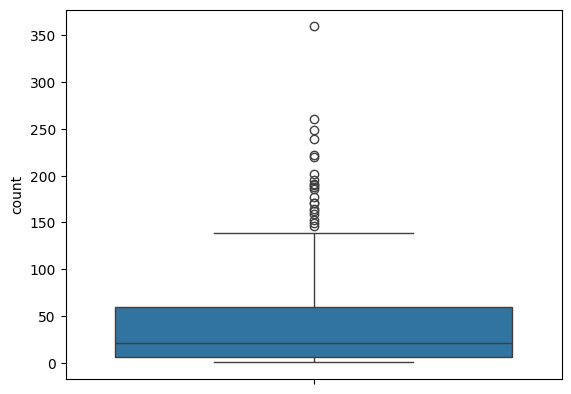

In [77]:
sns.boxplot(data=df['suburb'].value_counts())

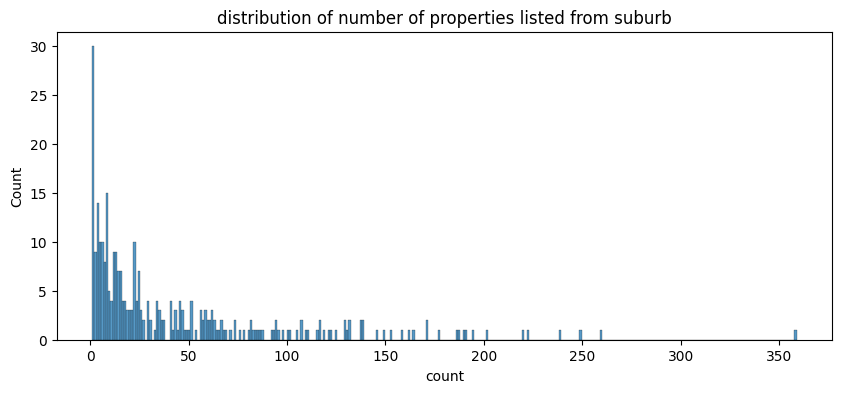

In [78]:
plt.figure(figsize=(10,4))
sns.histplot(data=df['suburb'].value_counts(),bins=len(df['suburb'].value_counts()))
plt.title('distribution of number of properties listed from suburb')
plt.show()

#### so there are suburb's which lists atmost 1 property

In [79]:
df['suburb'].value_counts()[df['suburb'].value_counts()>150]

suburb
Reservoir         359
Richmond          260
Bentleigh East    249
Preston           239
Brunswick         222
Essendon          220
South Yarra       202
Glen Iris         195
Hawthorn          191
Coburg            190
Northcote         188
Brighton          186
Kew               177
Pascoe Vale       171
Balwyn North      171
Yarraville        164
St Kilda          162
Glenroy           159
Port Melbourne    153
Name: count, dtype: int64

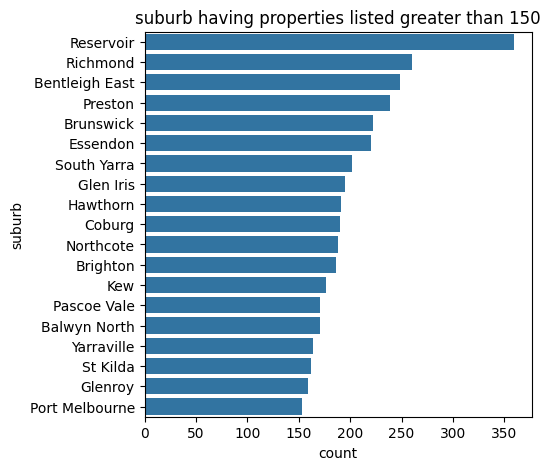

In [80]:
plt.figure(figsize=(5,5))
sns.barplot(x=df['suburb'].value_counts()[df['suburb'].value_counts()>150].values,y=df['suburb'].value_counts()[df['suburb'].value_counts()>150].index)
plt.title('suburb having properties listed greater than 150')
plt.xlabel('count')
plt.ylabel('suburb')
plt.show()

#### suburb "Reservoir" lists the maximum number of properties

In [81]:
df['suburb'].value_counts()[df['suburb'].value_counts()<=50]

suburb
Werribee           50
Kew East           49
Carlton North      48
Caulfield South    47
Oakleigh           47
                   ..
Upwey               1
Yarra Glen          1
Brookfield          1
Emerald             1
Whittlesea          1
Name: count, Length: 217, dtype: int64

In [82]:
distance_prop_count=df.groupby(['suburb'],as_index=False).agg(mean_distance=('distance','mean'),prop_count=('address','count')).sort_values(by=['prop_count','mean_distance'],ascending=False)
distance_prop_count

,suburb,mean_distance,prop_count
231,Reservoir,11.420613,359
232,Richmond,2.560769,260
29,Bentleigh East,13.881928,249
229,Preston,8.706276,239
45,Brunswick,5.200000,222
...,...,...,...
282,Upwey,29.300000,1
198,Montrose,28.800000,1
303,Wonga Park,25.200000,1
238,Rockbank,23.800000,1


<Axes: xlabel='mean_distance', ylabel='prop_count'>

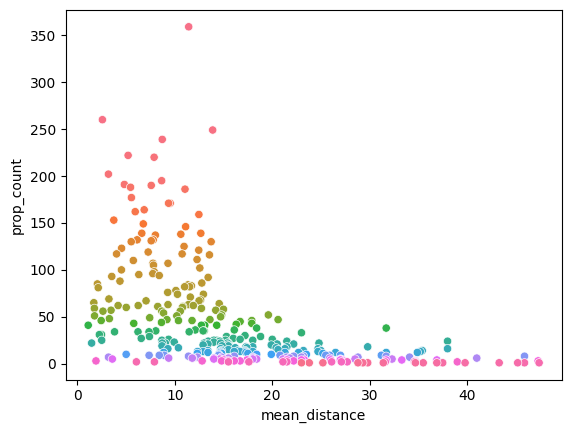

In [83]:
sns.scatterplot(x=distance_prop_count['mean_distance'],y=distance_prop_count['prop_count'],hue=distance_prop_count['suburb'],legend=False)

### we can observe from the above chart that as the distance from  melbourne is decreasing,the number of propties from suburb is decreasing
- this clearly states that suburb's located near to melbourne has more properties listed and as we go far from melbourne,number of properties listed from each of suburb gradually decreases

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13573 entries, 0 to 13572
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   suburb         13573 non-null  object 
 1   address        13573 non-null  object 
 2   rooms          13573 non-null  int64  
 3   type           13573 non-null  object 
 4   price          13573 non-null  float64
 5   method         13573 non-null  object 
 6   sellerg        13573 non-null  object 
 7   date           13573 non-null  object 
 8   distance       13573 non-null  float64
 9   postcode       13573 non-null  float64
 10  bedroom2       13573 non-null  float64
 11  bathroom       13573 non-null  float64
 12  car            13573 non-null  float64
 13  landsize       13573 non-null  float64
 14  buildingarea   13573 non-null  float64
 15  lattitude      13573 non-null  float64
 16  longtitude     13573 non-null  float64
 17  regionname     13573 non-null  object 
 18  proper

In [85]:
df['rooms'].unique()

array([ 2,  3,  4,  1,  6,  5,  8,  7, 10])

In [86]:
df['rooms'].nunique()

9

In [87]:
df['type'].unique()

array(['h', 'u', 't'], dtype=object)

In [88]:
df['price']

0        1480000.0
1        1035000.0
2        1465000.0
3         850000.0
4        1600000.0
           ...    
13568    1245000.0
13569    1031000.0
13570    1170000.0
13571    2500000.0
13572    1285000.0
Name: price, Length: 13573, dtype: float64

In [89]:
df['price'].min()

np.float64(85000.0)

<Axes: xlabel='distance', ylabel='price'>

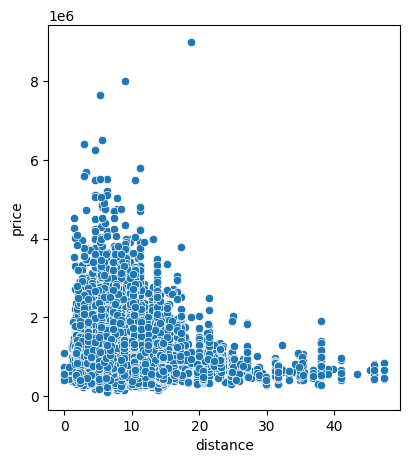

In [90]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.scatterplot(x=df['distance'],y=df['price'],)

#### we can observe in the above chart that,when the distance if lesser from melbourne,the distribution of price is more bulged out and as the distance increases,the distribution of price narrows down to low price range
- it clearly shows that properties farther from melbourne are less costlier compared to the properties which are nearer to melbourne
- price of properties nearer to the melbourne is depended on multiple features causing the variability in the price while properties which are farther,price  only depends on distance feature
- it shows that as we move farther from melbourne,number of features on which price depends decreases graddually and at last price only depends on distance 

In [91]:
df['price'].min()

np.float64(85000.0)

In [92]:
df['price'].max()

np.float64(9000000.0)

<Axes: ylabel='price'>

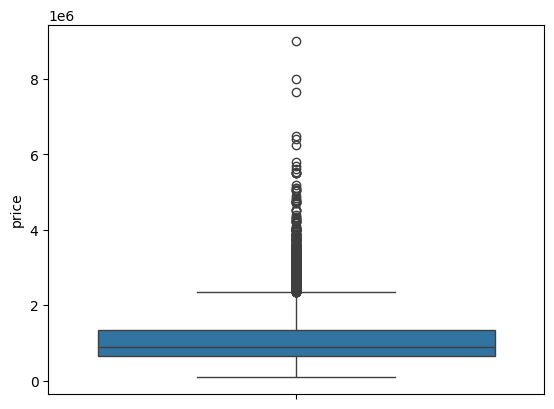

In [93]:
sns.boxplot(df['price'])

In [94]:
df['price'].quantile(0.25)

np.float64(650000.0)

In [95]:
df['price'].quantile(0.75)

np.float64(1330000.0)

In [96]:
df['price'].quantile(0.50)

np.float64(903000.0)

### the above chart shows that 50% of the properties has price between 650000 and 1330000 and median price is 903000

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13573 entries, 0 to 13572
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   suburb         13573 non-null  object 
 1   address        13573 non-null  object 
 2   rooms          13573 non-null  int64  
 3   type           13573 non-null  object 
 4   price          13573 non-null  float64
 5   method         13573 non-null  object 
 6   sellerg        13573 non-null  object 
 7   date           13573 non-null  object 
 8   distance       13573 non-null  float64
 9   postcode       13573 non-null  float64
 10  bedroom2       13573 non-null  float64
 11  bathroom       13573 non-null  float64
 12  car            13573 non-null  float64
 13  landsize       13573 non-null  float64
 14  buildingarea   13573 non-null  float64
 15  lattitude      13573 non-null  float64
 16  longtitude     13573 non-null  float64
 17  regionname     13573 non-null  object 
 18  proper

In [98]:
df['date']=pd.to_datetime(df['date'],format='%d/%m/%Y')

In [99]:
df['season']=np.where((df['date'].dt.month<=3) | (df['date'].dt.month>=10),'Winter','Summer')
df

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-12-03,2.5,3067.0,2.0,1.0,1.0,202.0,126.0,-37.79960,144.99840,Northern Metropolitan,4019.0,1935.0,Yarra,Winter
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-02-04,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,-37.80790,144.99340,Northern Metropolitan,4019.0,1900.0,Yarra,Winter
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-03-04,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,-37.80930,144.99440,Northern Metropolitan,4019.0,1900.0,Yarra,Winter
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,2017-03-04,2.5,3067.0,3.0,2.0,1.0,94.0,126.0,-37.79690,144.99690,Northern Metropolitan,4019.0,1935.0,Yarra,Winter
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,2016-06-04,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,-37.80720,144.99410,Northern Metropolitan,4019.0,2014.0,Yarra,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13568,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,2017-08-26,16.7,3150.0,4.0,2.0,2.0,652.0,126.0,-37.90562,145.16761,South-Eastern Metropolitan,7392.0,1981.0,Monash,Summer
13569,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,2017-08-26,6.8,3016.0,3.0,2.0,2.0,333.0,133.0,-37.85927,144.87904,Western Metropolitan,6380.0,1995.0,Hobsons Bay,Summer
13570,Williamstown,83 Power St,3,h,1170000.0,S,Raine,2017-08-26,6.8,3016.0,3.0,2.0,4.0,436.0,126.0,-37.85274,144.88738,Western Metropolitan,6380.0,1997.0,Hobsons Bay,Summer
13571,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,2017-08-26,6.8,3016.0,4.0,1.0,5.0,866.0,157.0,-37.85908,144.89299,Western Metropolitan,6380.0,1920.0,Hobsons Bay,Summer


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13573 entries, 0 to 13572
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   suburb         13573 non-null  object        
 1   address        13573 non-null  object        
 2   rooms          13573 non-null  int64         
 3   type           13573 non-null  object        
 4   price          13573 non-null  float64       
 5   method         13573 non-null  object        
 6   sellerg        13573 non-null  object        
 7   date           13573 non-null  datetime64[ns]
 8   distance       13573 non-null  float64       
 9   postcode       13573 non-null  float64       
 10  bedroom2       13573 non-null  float64       
 11  bathroom       13573 non-null  float64       
 12  car            13573 non-null  float64       
 13  landsize       13573 non-null  float64       
 14  buildingarea   13573 non-null  float64       
 15  lattitude      1357

In [101]:
df['distance']

0         2.5
1         2.5
2         2.5
3         2.5
4         2.5
         ... 
13568    16.7
13569     6.8
13570     6.8
13571     6.8
13572     6.3
Name: distance, Length: 13573, dtype: float64

In [102]:
df['distance'].min()

np.float64(0.0)

In [103]:
df['distance'].max()

np.float64(47.4)

<Axes: ylabel='distance'>

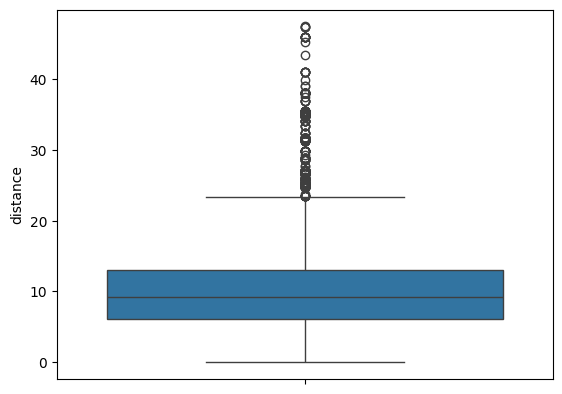

In [104]:
sns.boxplot(df['distance'])

In [105]:
df['location_type']=pd.cut(df['distance'],bins=(0,10,20,30,float(np.inf)),labels=('urban_pro','urban','rural','rural_pro'),include_lowest=True)
df.head()

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-12-03,2.5,3067.0,2.0,1.0,1.0,202.0,126.0,-37.7996,144.9984,Northern Metropolitan,4019.0,1935.0,Yarra,Winter,urban_pro
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-02-04,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,-37.8079,144.9934,Northern Metropolitan,4019.0,1900.0,Yarra,Winter,urban_pro
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-03-04,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,-37.8093,144.9944,Northern Metropolitan,4019.0,1900.0,Yarra,Winter,urban_pro
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,2017-03-04,2.5,3067.0,3.0,2.0,1.0,94.0,126.0,-37.7969,144.9969,Northern Metropolitan,4019.0,1935.0,Yarra,Winter,urban_pro
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,2016-06-04,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,-37.8072,144.9941,Northern Metropolitan,4019.0,2014.0,Yarra,Summer,urban_pro


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13573 entries, 0 to 13572
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   suburb         13573 non-null  object        
 1   address        13573 non-null  object        
 2   rooms          13573 non-null  int64         
 3   type           13573 non-null  object        
 4   price          13573 non-null  float64       
 5   method         13573 non-null  object        
 6   sellerg        13573 non-null  object        
 7   date           13573 non-null  datetime64[ns]
 8   distance       13573 non-null  float64       
 9   postcode       13573 non-null  float64       
 10  bedroom2       13573 non-null  float64       
 11  bathroom       13573 non-null  float64       
 12  car            13573 non-null  float64       
 13  landsize       13573 non-null  float64       
 14  buildingarea   13573 non-null  float64       
 15  lattitude      1357

In [107]:
df['sellerg']

0          Biggin
1          Biggin
2          Biggin
3          Biggin
4          Nelson
           ...   
13568       Barry
13569    Williams
13570       Raine
13571     Sweeney
13572     Village
Name: sellerg, Length: 13573, dtype: object

In [108]:
df['sellerg'].unique()

array(['Biggin', 'Nelson', 'Jellis', 'Greg', 'LITTLE', 'Collins', 'Kay',
       'Beller', 'Marshall', 'Brad', 'Maddison', 'Barry', 'Considine',
       'Rendina', 'Propertyau', 'McDonald', 'Prof.', 'Harcourts',
       'hockingstuart', 'Thomson', 'Buxton', 'RT', "Sotheby's", 'Cayzer',
       'Chisholm', 'Brace', 'Miles', 'McGrath', 'Love', 'Barlow',
       'Sweeney', 'Village', 'Jas', 'Gunn&Co', 'Burnham', 'Williams',
       'Compton', 'FN', 'Raine&Horne', 'Hunter', 'Noel', 'Hodges', 'Ray',
       'Gary', 'Fletchers', 'Woodards', 'Raine', 'Walshe', 'Alexkarbon',
       'Weda', 'Frank', 'Stockdale', 'Tim', 'Purplebricks', 'Moonee',
       'HAR', 'Edward', 'Philip', 'RW', 'North', 'Ascend', 'Christopher',
       'Mandy', 'R&H', 'Fletchers/One', 'Assisi', 'One', "O'Brien", 'C21',
       'Bayside', 'Paul', 'First', 'Matthew', 'Anderson', 'Nick',
       'Lindellas', 'Allens', 'Bells', 'Trimson', 'Douglas', 'YPA', 'GL',
       "Tiernan's", 'J', 'Harrington', 'Dingle', 'Chambers', 'Peter',
    

In [109]:
df['sellerg'].nunique()

268

In [110]:
df['sellerg']=df['sellerg'].str.strip()

In [111]:
df['sellerg'].value_counts()

sellerg
Nelson           1565
Jellis           1316
hockingstuart    1167
Barry            1011
Ray               700
                 ... 
Area                1
SN                  1
PRD                 1
Rexhepi             1
Point               1
Name: count, Length: 268, dtype: int64

In [112]:
df['sellerg'].value_counts()[df['sellerg'].value_counts()>100]

sellerg
Nelson           1565
Jellis           1316
hockingstuart    1167
Barry            1011
Ray               700
Marshall          659
Buxton            632
Biggin            393
Brad              342
Woodards          301
Fletchers         300
Jas               243
Greg              239
McGrath           222
Sweeney           216
Noel              205
Miles             196
RT                184
Gary              170
Harcourts         167
Hodges            157
YPA               152
Stockdale         150
Village           125
Kay               119
Raine             115
Williams          111
Love              109
Name: count, dtype: int64

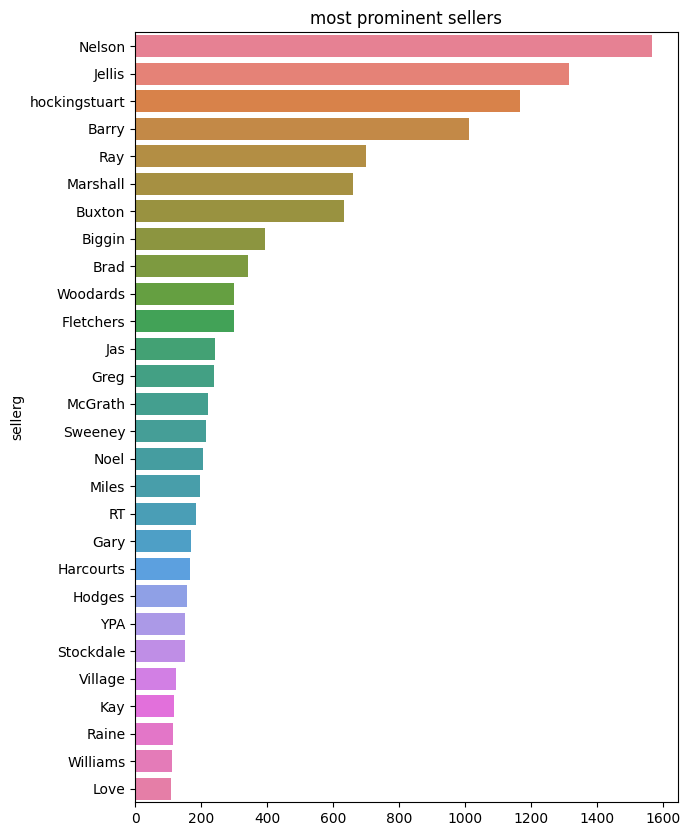

In [113]:
plt.figure(figsize=(7,10))
sns.barplot(x=df['sellerg'].value_counts()[df['sellerg'].value_counts()>100].values,y=df['sellerg'].value_counts()[df['sellerg'].value_counts()>100].index,hue=df['sellerg'].value_counts()[df['sellerg'].value_counts()>100].index)
plt.title('most prominent sellers')
plt.show()

#### 'Nelson' is most prominent seller among all

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13573 entries, 0 to 13572
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   suburb         13573 non-null  object        
 1   address        13573 non-null  object        
 2   rooms          13573 non-null  int64         
 3   type           13573 non-null  object        
 4   price          13573 non-null  float64       
 5   method         13573 non-null  object        
 6   sellerg        13573 non-null  object        
 7   date           13573 non-null  datetime64[ns]
 8   distance       13573 non-null  float64       
 9   postcode       13573 non-null  float64       
 10  bedroom2       13573 non-null  float64       
 11  bathroom       13573 non-null  float64       
 12  car            13573 non-null  float64       
 13  landsize       13573 non-null  float64       
 14  buildingarea   13573 non-null  float64       
 15  lattitude      1357

In [115]:
df['postcode']=df['postcode'].astype(int)

In [116]:
df['bedroom2'].unique()

array([ 2.,  3.,  4.,  1.,  6.,  5.,  0.,  8.,  9.,  7., 20., 10.])

- wait! house with bedrooms = 10,20
    * need to check data integrity
    * bedrooms cannot be greater than rooms

In [117]:
df[df['bedroom2']>df['rooms']]

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type
6,Abbotsford,124 Yarra St,3,h,1876000.0,S,Nelson,2016-05-07,2.5,3067,4.0,2.0,0.0,245.0,210.0,-37.80240,144.99930,Northern Metropolitan,4019.0,1910.0,Yarra,Summer,urban_pro
9,Abbotsford,10 Valiant St,2,h,1097000.0,S,Biggin,2016-10-08,2.5,3067,3.0,1.0,2.0,220.0,75.0,-37.80100,144.99890,Northern Metropolitan,4019.0,1900.0,Yarra,Winter,urban_pro
63,Airport West,6 Kittyhawk St,4,h,773000.0,S,Brad,2016-09-17,13.5,3042,5.0,3.0,4.0,531.0,309.0,-37.72630,144.86790,Western Metropolitan,3464.0,1980.0,Moonee Valley,Summer,urban
207,Altona North,1/156 Chambers Rd,3,h,620000.0,SP,Hunter,2016-08-22,11.1,3025,5.0,2.0,2.0,276.0,100.0,-37.82620,144.84430,Western Metropolitan,5132.0,2010.0,Hobsons Bay,Summer,urban
233,Armadale,11/17 Myamyn St,2,u,3625000.0,S,Jellis,2016-06-04,6.3,3143,3.0,2.0,2.0,0.0,126.0,-37.85550,145.02910,Southern Metropolitan,4836.0,2006.0,Stonnington,Summer,urban_pro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11536,Watsonia North,280 Grimshaw St,3,h,740000.0,SP,Barry,2017-07-15,14.5,3087,4.0,1.0,2.0,909.0,126.0,-37.70255,145.08578,Northern Metropolitan,1442.0,1974.0,Banyule,Summer,urban
11579,Aspendale,14 Ebb St,3,h,970000.0,VB,hockingstuart,2017-07-22,21.5,3195,4.0,2.0,2.0,612.0,154.0,-38.01596,145.09932,South-Eastern Metropolitan,2824.0,1960.0,Kingston,Summer,rural
11846,Toorak,10/270 Williams Rd,1,u,350000.0,VB,Marshall,2017-07-22,4.1,3142,2.0,1.0,1.0,0.0,126.0,-37.84157,145.00469,Southern Metropolitan,7217.0,1970.0,Stonnington,Summer,urban_pro
12410,Thornbury,316 Rossmoyne St,3,h,1375000.0,S,McGrath,2017-09-03,7.0,3071,4.0,2.0,3.0,530.0,145.0,-37.75968,145.02305,Northern Metropolitan,8870.0,1950.0,Darebin,Summer,urban_pro


so there are 203 records where Number of bedrooms is greater than number of rooms,in general context,number of bedroms can be less than or equal to number of rooms but not greater than

In [118]:
df['bedroom2']=np.where(df['bedroom2']>df['rooms'],df['rooms'],df['bedroom2'])
df[df['bedroom2']>df['rooms']]

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type


In [119]:
df['bedroom2'].unique()

array([ 2.,  3.,  1.,  4.,  6.,  5.,  0.,  8.,  7., 10.])

In [120]:
df['bedroom2']=df['bedroom2'].astype(int)

<Axes: xlabel='bedroom2', ylabel='Count'>

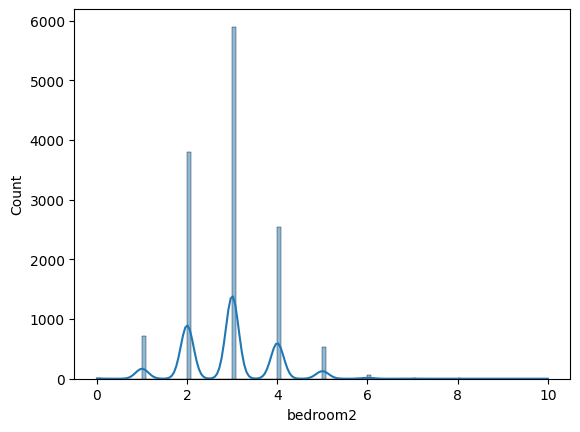

In [121]:
sns.histplot(df['bedroom2'],kde=True)

<Axes: xlabel='bedroom2'>

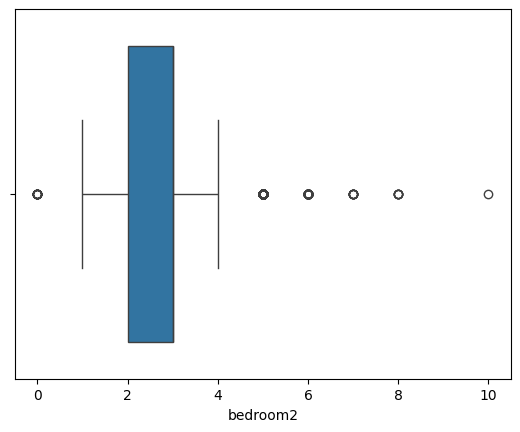

In [122]:
sns.boxplot(x=df['bedroom2'])

##### most of houses have 2 to 3 bedrooms,houses having more than 4 bedrooms seems outliers and must be influencing the price of the house

In [123]:
bedroom_location_price=df.groupby(['bedroom2','location_type'],as_index=False,observed=True).agg(mean_price=('price','mean')).sort_values(by=['location_type','bedroom2','mean_price'])
bedroom_location_price

,bedroom2,location_type,mean_price
0,0,urban_pro,1.130875e+06
2,1,urban_pro,4.497326e+05
5,2,urban_pro,8.230822e+05
9,3,urban_pro,1.284276e+06
13,4,urban_pro,1.838348e+06
17,5,urban_pro,2.340177e+06
21,6,urban_pro,2.389080e+06
25,7,urban_pro,1.991000e+06
27,8,urban_pro,2.200000e+06
1,0,urban,9.295625e+05


<Axes: xlabel='mean_price', ylabel='bedroom2'>

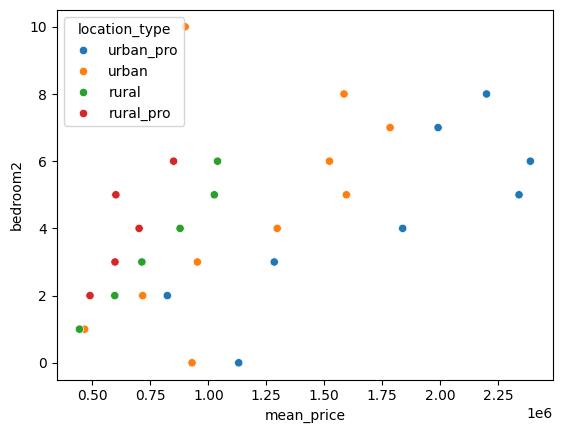

In [124]:
sns.scatterplot(data=bedroom_location_price,x='mean_price',y='bedroom2',hue='location_type')

#### we can observe from the above plot that
- houses in rural area have lesser price than urban area despite having equal number of rooms
- as we move from rural_pro to urban_pro area towards melbourne,number of rooms in houses increases with increase in house price

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13573 entries, 0 to 13572
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   suburb         13573 non-null  object        
 1   address        13573 non-null  object        
 2   rooms          13573 non-null  int64         
 3   type           13573 non-null  object        
 4   price          13573 non-null  float64       
 5   method         13573 non-null  object        
 6   sellerg        13573 non-null  object        
 7   date           13573 non-null  datetime64[ns]
 8   distance       13573 non-null  float64       
 9   postcode       13573 non-null  int64         
 10  bedroom2       13573 non-null  int64         
 11  bathroom       13573 non-null  float64       
 12  car            13573 non-null  float64       
 13  landsize       13573 non-null  float64       
 14  buildingarea   13573 non-null  float64       
 15  lattitude      1357

In [126]:
df[df['bathroom']==0]

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type
139,Alphington,6 Naroon Rd,3,h,1485000.0,SP,McGrath,2016-08-28,6.4,3078,3,0.0,0.0,597.0,126.0,-37.77810,145.02840,Northern Metropolitan,2211.0,1965.0,Darebin,Summer,urban_pro
281,Armadale,3/50 Denbigh Rd,2,u,546000.0,SP,hockingstuart,2016-07-30,6.3,3143,2,0.0,0.0,0.0,126.0,-37.85680,145.01610,Southern Metropolitan,4836.0,1960.0,Stonnington,Summer,urban_pro
505,Balaclava,5/11 Albion St,2,u,497500.0,PI,hockingstuart,2016-08-28,6.6,3183,2,0.0,0.0,0.0,126.0,-37.87390,144.99290,Southern Metropolitan,2952.0,1960.0,Port Phillip,Summer,urban_pro
584,Balwyn,5 Shrimpton Ct,2,h,1010000.0,PI,Marshall,2016-07-30,9.7,3103,2,0.0,0.0,1611.0,126.0,-37.80920,145.10160,Southern Metropolitan,5682.0,1975.0,Boroondara,Summer,urban_pro
913,Bentleigh East,579 Warrigal Rd,3,h,700000.0,S,Thomson,2016-05-22,13.9,3165,0,0.0,0.0,456.0,126.0,-37.93140,145.08080,Southern Metropolitan,10969.0,1970.0,Glen Eira,Summer,urban
1063,Brighton,17 New St,3,h,1900000.0,S,Marshall,2016-08-06,11.2,3186,3,0.0,0.0,0.0,126.0,-37.93010,144.99350,Southern Metropolitan,10579.0,1970.0,Bayside,Summer,urban
1070,Brighton,1/5 Webb St,3,t,1067000.0,S,Kay,2016-05-07,11.2,3186,3,0.0,1.0,0.0,126.0,-37.91190,144.98710,Southern Metropolitan,10579.0,1970.0,Bayside,Summer,urban
1593,Camberwell,5 Nicholsdale Rd,4,h,1400000.0,PI,Jellis,2016-04-16,7.8,3124,3,0.0,0.0,693.0,126.0,-37.83600,145.09140,Southern Metropolitan,8920.0,1935.0,Boroondara,Summer,urban_pro
2253,Elsternwick,5/29 Nepean Hwy,2,u,410000.0,VB,Gary,2016-05-28,8.5,3185,0,0.0,0.0,0.0,126.0,-37.88630,144.99960,Southern Metropolitan,4898.0,1935.0,Glen Eira,Summer,urban_pro
2777,Glen Iris,25 Hope St,2,h,845000.0,S,Noel,2016-09-10,9.2,3146,2,0.0,0.0,207.0,126.0,-37.86300,145.05010,Southern Metropolitan,10412.0,1950.0,Stonnington,Summer,urban_pro


wait! what!,there are houses even with no bathrooms,this is not possible to have house building in melbourne having rooms and bedrooms but no bathrooms
- this is data integrity error,this needed to be fixed to house having atleast 1 bathroom

In [127]:
df[(df['bathroom']==0)&(df['bedroom2']>0)]

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type
139,Alphington,6 Naroon Rd,3,h,1485000.0,SP,McGrath,2016-08-28,6.4,3078,3,0.0,0.0,597.0,126.0,-37.77810,145.02840,Northern Metropolitan,2211.0,1965.0,Darebin,Summer,urban_pro
281,Armadale,3/50 Denbigh Rd,2,u,546000.0,SP,hockingstuart,2016-07-30,6.3,3143,2,0.0,0.0,0.0,126.0,-37.85680,145.01610,Southern Metropolitan,4836.0,1960.0,Stonnington,Summer,urban_pro
505,Balaclava,5/11 Albion St,2,u,497500.0,PI,hockingstuart,2016-08-28,6.6,3183,2,0.0,0.0,0.0,126.0,-37.87390,144.99290,Southern Metropolitan,2952.0,1960.0,Port Phillip,Summer,urban_pro
584,Balwyn,5 Shrimpton Ct,2,h,1010000.0,PI,Marshall,2016-07-30,9.7,3103,2,0.0,0.0,1611.0,126.0,-37.80920,145.10160,Southern Metropolitan,5682.0,1975.0,Boroondara,Summer,urban_pro
1063,Brighton,17 New St,3,h,1900000.0,S,Marshall,2016-08-06,11.2,3186,3,0.0,0.0,0.0,126.0,-37.93010,144.99350,Southern Metropolitan,10579.0,1970.0,Bayside,Summer,urban
1070,Brighton,1/5 Webb St,3,t,1067000.0,S,Kay,2016-05-07,11.2,3186,3,0.0,1.0,0.0,126.0,-37.91190,144.98710,Southern Metropolitan,10579.0,1970.0,Bayside,Summer,urban
1593,Camberwell,5 Nicholsdale Rd,4,h,1400000.0,PI,Jellis,2016-04-16,7.8,3124,3,0.0,0.0,693.0,126.0,-37.83600,145.09140,Southern Metropolitan,8920.0,1935.0,Boroondara,Summer,urban_pro
2777,Glen Iris,25 Hope St,2,h,845000.0,S,Noel,2016-09-10,9.2,3146,2,0.0,0.0,207.0,126.0,-37.86300,145.05010,Southern Metropolitan,10412.0,1950.0,Stonnington,Summer,urban_pro
2797,Glen Iris,130 High St,4,h,1550000.0,PI,Jellis,2016-05-14,9.2,3146,4,0.0,0.0,769.0,126.0,-37.86280,145.07340,Southern Metropolitan,10412.0,1950.0,Boroondara,Summer,urban_pro
2808,Glen Iris,1/64 Edgar St N,2,u,545000.0,S,Fletchers,2016-07-16,9.2,3146,2,0.0,0.0,0.0,126.0,-37.85000,145.04650,Southern Metropolitan,10412.0,1950.0,Stonnington,Summer,urban_pro


In [128]:
df['bathroom']=np.where((df['bathroom']==0)&(df['bedroom2']>=0),1,df['bathroom'])

In [129]:
df[(df['bathroom']==0)&(df['bedroom2']>0)]

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type


In [130]:
df[(df['bathroom']==0)]

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type


In [131]:
df['bathroom']=df['bathroom'].astype(int)

In [132]:
df.groupby(['bathroom'],as_index=False).agg(mean_price=('price','mean'))

,bathroom,mean_price
0,1,8.593147e+05
1,2,1.232618e+06
2,3,1.756070e+06
3,4,2.725852e+06
4,5,2.614179e+06
5,6,2.786200e+06
6,7,3.425000e+06
7,8,1.480000e+06


<Axes: xlabel='bathroom', ylabel='mean_price'>

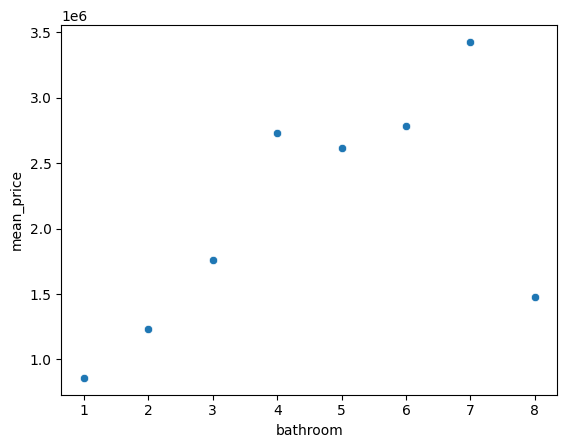

In [133]:
sns.scatterplot(data=df.groupby(['bathroom'],as_index=False).agg(mean_price=('price','mean')),
                x='bathroom',
                y='mean_price')

### the above chart shows that in most cases,
- as the number of bathrooms increases,the price of the house also increases

In [134]:
df.groupby(['bathroom','location_type'],as_index=False,observed=True).agg(mean_price=('price','mean'))

,bathroom,location_type,mean_price
0,1,urban_pro,8.942313e+05
1,1,urban,8.233234e+05
2,1,rural,6.683426e+05
3,1,rural_pro,5.599013e+05
4,2,urban_pro,1.423720e+06
5,2,urban,1.124471e+06
6,2,rural,8.111906e+05
7,2,rural_pro,6.561085e+05
8,3,urban_pro,2.006613e+06
9,3,urban,1.554276e+06


<Axes: xlabel='mean_price', ylabel='bathroom'>

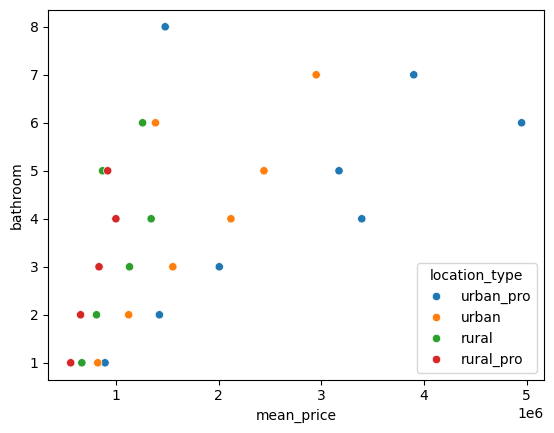

In [135]:
sns.scatterplot(data=df.groupby(['bathroom','location_type'],as_index=False,observed=True).agg(mean_price=('price','mean')),
                x='mean_price',
                y='bathroom',
                hue='location_type')

### we can observe from the above chart that
- as we move from rural to urban_pro area nearer to melbourne,
    - number of bathrooms increases
    - price of the house also increases with respective to increase in number of bathrooms and decrease in distance 

In [136]:
df.head()

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-12-03,2.5,3067,2,1,1.0,202.0,126.0,-37.7996,144.9984,Northern Metropolitan,4019.0,1935.0,Yarra,Winter,urban_pro
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-02-04,2.5,3067,2,1,0.0,156.0,79.0,-37.8079,144.9934,Northern Metropolitan,4019.0,1900.0,Yarra,Winter,urban_pro
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-03-04,2.5,3067,3,2,0.0,134.0,150.0,-37.8093,144.9944,Northern Metropolitan,4019.0,1900.0,Yarra,Winter,urban_pro
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,2017-03-04,2.5,3067,3,2,1.0,94.0,126.0,-37.7969,144.9969,Northern Metropolitan,4019.0,1935.0,Yarra,Winter,urban_pro
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,2016-06-04,2.5,3067,3,1,2.0,120.0,142.0,-37.8072,144.9941,Northern Metropolitan,4019.0,2014.0,Yarra,Summer,urban_pro


In [137]:
df['living_rooms']=df['rooms']-df['bedroom2']

In [138]:
df.groupby(['rooms','bathroom','location_type'],as_index=False,observed=True).agg(mean_price=('price','mean'))

,rooms,bathroom,location_type,mean_price
0,1,1,urban_pro,4.323691e+05
1,1,1,urban,3.878596e+05
2,1,1,rural,4.439167e+05
3,1,2,urban_pro,1.120500e+06
4,1,2,urban,1.515000e+06
...,...,...,...,...
88,8,3,urban,1.310500e+06
89,8,4,urban,9.600000e+05
90,8,7,urban,2.950000e+06
91,8,8,urban_pro,2.200000e+06


<Axes: title={'center': 'price VS bathroom'}, xlabel='bathroom', ylabel='mean_price'>

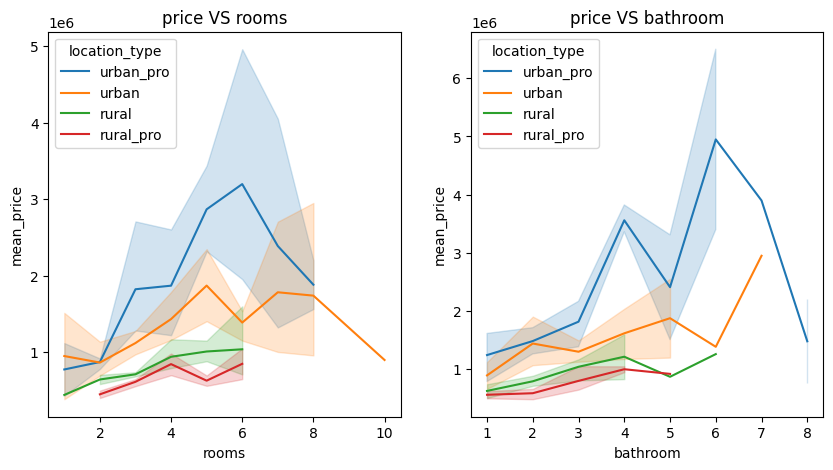

In [139]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('price VS rooms')
sns.lineplot(data=df.groupby(['rooms','bathroom','location_type'],as_index=False,observed=True).agg(mean_price=('price','mean')),
             x='rooms',
             y='mean_price',
             hue='location_type',
             )

plt.subplot(1,2,2)
plt.title('price VS bathroom')
sns.lineplot(data=df.groupby(['rooms','bathroom','location_type'],as_index=False,observed=True).agg(mean_price=('price','mean')),
             x='bathroom',
             y='mean_price',
             hue='location_type',
             )

#### the above chart shows that
- addition of area(room/bathroom) increases the price of the house in urban area's massively
- addition of area(room/bathroom) does not effect the house price in rural area's that much
- the shaded regio around the lines shows the volatility,the wide shaded area around the lines shows that there are few mansions having more number of rooms and bathrooms but their price varies a lot

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13573 entries, 0 to 13572
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   suburb         13573 non-null  object        
 1   address        13573 non-null  object        
 2   rooms          13573 non-null  int64         
 3   type           13573 non-null  object        
 4   price          13573 non-null  float64       
 5   method         13573 non-null  object        
 6   sellerg        13573 non-null  object        
 7   date           13573 non-null  datetime64[ns]
 8   distance       13573 non-null  float64       
 9   postcode       13573 non-null  int64         
 10  bedroom2       13573 non-null  int64         
 11  bathroom       13573 non-null  int64         
 12  car            13573 non-null  float64       
 13  landsize       13573 non-null  float64       
 14  buildingarea   13573 non-null  float64       
 15  lattitude      1357

In [141]:
df['car']

0        1.0
1        0.0
2        0.0
3        1.0
4        2.0
        ... 
13568    2.0
13569    2.0
13570    4.0
13571    5.0
13572    1.0
Name: car, Length: 13573, dtype: float64

In [142]:
df['car'].unique()

array([ 1.,  0.,  2.,  6.,  5.,  4.,  3.,  8.,  7.,  9., 10.])

In [143]:
df.groupby(['car','location_type'],as_index=False,observed=True).agg(mean_price=('price','mean')).sort_values(by=['location_type','mean_price'])

,car,location_type,mean_price
4,1.0,urban_pro,8.847106e+05
0,0.0,urban_pro,1.120727e+06
8,2.0,urban_pro,1.424400e+06
12,3.0,urban_pro,1.643512e+06
20,5.0,urban_pro,1.765375e+06
23,6.0,urban_pro,1.927000e+06
16,4.0,urban_pro,1.935364e+06
29,8.0,urban_pro,2.384400e+06
27,7.0,urban_pro,2.438000e+06
5,1.0,urban,7.932472e+05


In [144]:
df.groupby(['car','location_type'],as_index=False,observed=True).agg(median_price=('price','median')).sort_values(by=['location_type','median_price'])

,car,location_type,median_price
4,1.0,urban_pro,740000.0
0,0.0,urban_pro,1055000.0
20,5.0,urban_pro,1210500.0
8,2.0,urban_pro,1255000.0
12,3.0,urban_pro,1430000.0
16,4.0,urban_pro,1700000.0
23,6.0,urban_pro,1785000.0
29,8.0,urban_pro,1900000.0
27,7.0,urban_pro,2610000.0
5,1.0,urban,695000.0


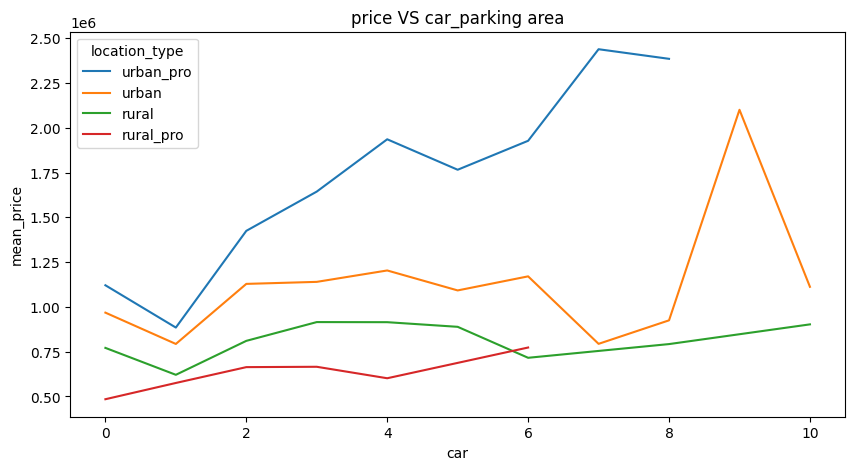

In [145]:
plt.figure(figsize=(10,5))
plt.title('price VS car_parking area')
sns.lineplot(data=df.groupby(['car','location_type'],as_index=False,observed=True).agg(mean_price=('price','mean')).sort_values(by=['location_type','mean_price']),
             x='car',
             y='mean_price',
             hue='location_type',
             )
plt.show()

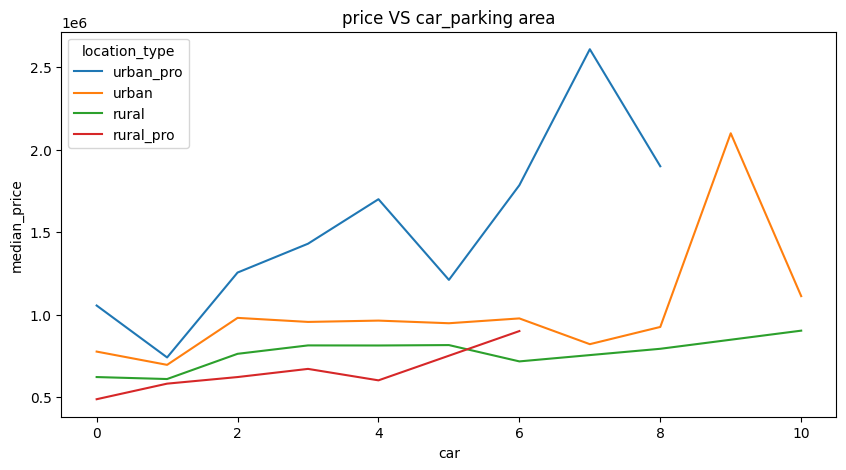

In [146]:
plt.figure(figsize=(10,5))
plt.title('price VS car_parking area')
sns.lineplot(data=df.groupby(['car','location_type'],as_index=False,observed=True).agg(median_price=('price','median')).sort_values(by=['location_type','median_price']),
             x='car',
             y='median_price',
             hue='location_type',
             )
plt.show()

##### we can observe that
- as the car parking increases in urban area's the price of the property increases massively
- as the car parking increases in rural area's the price of the property does not show any massive change
- space is considered luxurious in urban area costing higher house prices than n rural_area
- mean_price and median_price moving at similar weights

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13573 entries, 0 to 13572
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   suburb         13573 non-null  object        
 1   address        13573 non-null  object        
 2   rooms          13573 non-null  int64         
 3   type           13573 non-null  object        
 4   price          13573 non-null  float64       
 5   method         13573 non-null  object        
 6   sellerg        13573 non-null  object        
 7   date           13573 non-null  datetime64[ns]
 8   distance       13573 non-null  float64       
 9   postcode       13573 non-null  int64         
 10  bedroom2       13573 non-null  int64         
 11  bathroom       13573 non-null  int64         
 12  car            13573 non-null  float64       
 13  landsize       13573 non-null  float64       
 14  buildingarea   13573 non-null  float64       
 15  lattitude      1357

In [148]:
df['landsize']

0        202.0
1        156.0
2        134.0
3         94.0
4        120.0
         ...  
13568    652.0
13569    333.0
13570    436.0
13571    866.0
13572    362.0
Name: landsize, Length: 13573, dtype: float64

In [149]:
df['landsize'].unique()

array([ 202.,  156.,  134., ..., 2027., 1475.,  986.], shape=(1447,))

In [150]:
df[df['landsize']==0]

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type,living_rooms
8,Abbotsford,6/241 Nicholson St,1,u,300000.0,S,Biggin,2016-10-08,2.5,3067,1,1,1.0,0.0,126.00,-37.80080,144.99730,Northern Metropolitan,4019.0,1935.0,Yarra,Winter,urban_pro,0
10,Abbotsford,411/8 Grosvenor St,2,u,700000.0,VB,Jellis,2016-11-12,2.5,3067,2,2,1.0,0.0,126.00,-37.81100,145.00670,Northern Metropolitan,4019.0,1935.0,Yarra,Winter,urban_pro,0
12,Abbotsford,123/56 Nicholson St,2,u,750000.0,S,Biggin,2016-11-12,2.5,3067,2,2,1.0,0.0,94.00,-37.80780,144.99650,Northern Metropolitan,4019.0,2009.0,Yarra,Winter,urban_pro,0
14,Abbotsford,7/20 Abbotsford St,1,u,441000.0,SP,Greg,2016-05-14,2.5,3067,1,1,1.0,0.0,126.00,-37.80160,144.99880,Northern Metropolitan,4019.0,1935.0,Yarra,Summer,urban_pro,0
21,Abbotsford,13/11 Nicholson St,3,t,900000.0,S,Beller,2017-03-18,2.5,3067,3,2,2.0,0.0,126.00,-37.80930,144.99590,Northern Metropolitan,4019.0,2010.0,Yarra,Winter,urban_pro,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12168,St Kilda,45/151 Fitzroy St,2,u,600000.0,VB,hockingstuart,2017-07-29,5.0,3182,2,1,1.0,0.0,82.00,-37.85911,144.97900,Southern Metropolitan,13240.0,1930.0,Port Phillip,Summer,urban_pro,0
12176,Surrey Hills,6/91 Warrigal Rd,3,u,1050000.0,PI,hockingstuart,2017-07-29,10.2,3127,3,2,2.0,0.0,126.00,-37.83358,145.09884,Southern Metropolitan,5457.0,1950.0,Whitehorse,Summer,urban,0
12188,Tullamarine,9/200 Melrose Dr,2,u,300000.0,SP,Jason,2017-07-29,12.9,3043,2,1,1.0,0.0,66.32,-37.69815,144.88019,Western Metropolitan,3296.0,1980.0,Hume,Summer,urban,0
12207,Williamstown,2/29 Dover Rd,1,u,385000.0,SP,Williams,2017-07-29,6.8,3016,1,1,1.0,0.0,35.64,-37.85588,144.89936,Western Metropolitan,6380.0,1967.0,Hobsons Bay,Summer,urban_pro,0


wait! what,a building with 0 landsize,how that could be possible,that too in 1933 Rows,Huge data integrity error
- let check for higher land size

In [151]:
df['landsize'].describe()

count     13573.000000
mean        555.109556
std        3973.825884
min           0.000000
25%         176.000000
50%         440.000000
75%         651.000000
max      433014.000000
Name: landsize, dtype: float64

In [152]:
sorted(df['landsize'].unique())[:100]

[np.float64(0.0),
 np.float64(1.0),
 np.float64(2.0),
 np.float64(3.0),
 np.float64(5.0),
 np.float64(10.0),
 np.float64(14.0),
 np.float64(15.0),
 np.float64(17.0),
 np.float64(18.0),
 np.float64(28.0),
 np.float64(29.0),
 np.float64(30.0),
 np.float64(34.0),
 np.float64(35.0),
 np.float64(36.0),
 np.float64(37.0),
 np.float64(38.0),
 np.float64(41.0),
 np.float64(43.0),
 np.float64(44.0),
 np.float64(45.0),
 np.float64(46.0),
 np.float64(47.0),
 np.float64(49.0),
 np.float64(50.0),
 np.float64(53.0),
 np.float64(54.0),
 np.float64(55.0),
 np.float64(56.0),
 np.float64(57.0),
 np.float64(58.0),
 np.float64(59.0),
 np.float64(60.0),
 np.float64(61.0),
 np.float64(62.0),
 np.float64(63.0),
 np.float64(64.0),
 np.float64(65.0),
 np.float64(66.0),
 np.float64(67.0),
 np.float64(68.0),
 np.float64(69.0),
 np.float64(70.0),
 np.float64(71.0),
 np.float64(72.0),
 np.float64(73.0),
 np.float64(74.0),
 np.float64(75.0),
 np.float64(76.0),
 np.float64(77.0),
 np.float64(78.0),
 np.float64(79.0)

In [153]:
df['landsize'].mode()

0    0.0
Name: landsize, dtype: float64

wait ! Huge data integrity error..
we need to impute the 

<Axes: xlabel='landsize', ylabel='Count'>

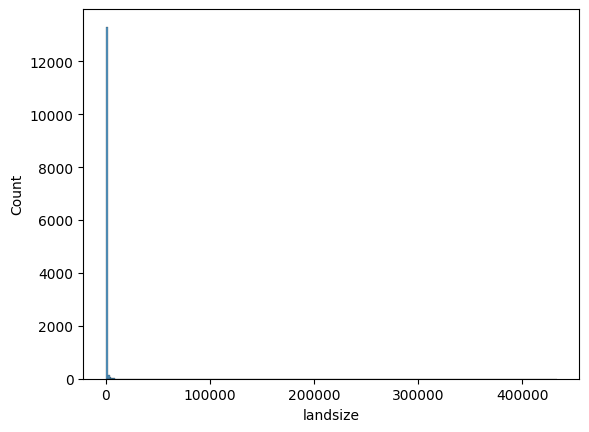

In [154]:
sns.histplot(df['landsize'])

In [155]:
df[df['landsize']>2000]['landsize'].unique()

array([  4290.,   2113.,   2471.,   2051.,  75100.,   4931.,   4668.,
         4676.,   2120.,   2886.,  15900.,   2773.,   3701.,   2381.,
         2925.,  10100.,   2782.,   4332.,   2778.,   4296.,   2077.,
         2794.,   8680.,   3056.,   3414.,   3132.,   3194.,   3977.,
         4267.,   4440.,   3448.,   3957.,   2136.,  15100.,   5661.,
         3967.,  37000.,   4977.,   3014.,   4230.,   4051.,   2026.,
         2187.,   2522.,   2300.,   2469.,   2427.,   2488.,   2431.,
         2401.,   2193.,  21700.,   2166.,   6866.,   5042.,   8216.,
         3037.,   4679.,  41400.,   8223.,   2571.,   2740.,   7455.,
         3516.,   2325.,   2143.,  14500.,  17200.,   2122.,   6111.,
         2121.,   3878.,   2295.,   2955.,   5530.,   6186.,   2335.,
         2879.,   7170.,   7458.,   7330.,   2927.,   3455.,   2274.,
         2276.,   3084.,   4497.,   2064.,   5289.,   2347.,   3886.,
         2079.,   3747.,   2696.,   2679.,   6494.,   2306.,   2787.,
         4721.,   24

In [156]:
df[df['landsize'].isin(df[df['landsize']>5000]['landsize'].unique())]

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type,living_rooms
687,Balwyn North,9 Gildan St,3,h,2000000.0,VB,Kay,2016-08-28,9.2,3104,3,1,2.0,75100.0,126.0,-37.80020,145.07000,Southern Metropolitan,7809.0,1960.0,Boroondara,Summer,urban_pro,0
2084,Collingwood,4/170 Oxford St,3,u,950000.0,S,Jellis,2017-03-04,1.6,3066,3,2,1.0,15900.0,126.0,-37.80350,144.98500,Northern Metropolitan,4553.0,1920.0,Yarra,Winter,urban_pro,0
2487,Essendon North,1 Dudley St,3,h,1425000.0,S,McGrath,2017-02-25,9.4,3041,3,2,2.0,10100.0,126.0,-37.73760,144.89540,Western Metropolitan,1308.0,1970.0,Moonee Valley,Winter,urban_pro,0
2684,Footscray,13/2 Saltriver Pl,3,u,674000.0,S,Jellis,2017-02-11,6.4,3011,3,2,1.0,8680.0,126.0,-37.80160,144.90820,Western Metropolitan,7570.0,1960.0,Maribyrnong,Winter,urban_pro,0
3750,Maidstone,17/46 Eucalyptus Dr,2,u,352500.0,S,hockingstuart,2017-03-18,9.2,3012,2,1,1.0,15100.0,66.0,-37.77950,144.87290,Western Metropolitan,3873.0,2012.0,Maribyrnong,Winter,urban_pro,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12592,Richmond,36/73 River St,2,u,592000.0,SA,Jellis,2017-09-09,2.4,3121,2,2,1.0,14294.0,77.0,-37.81894,145.01314,Northern Metropolitan,14949.0,2006.0,Yarra,Summer,urban_pro,0
12721,Fitzroy North,90 Bennett St,3,h,1400000.0,PI,McGrath,2017-09-16,3.6,3068,3,2,0.0,9338.0,126.0,-37.78101,144.98843,Northern Metropolitan,6244.0,1900.0,Yarra,Summer,urban_pro,0
13383,Carlton,50 Dorrit St,3,h,1760000.0,S,hockingstuart,2017-08-26,1.6,3053,3,1,0.0,9405.0,134.0,-37.79945,144.96653,Northern Metropolitan,6786.0,1880.0,Melbourne,Summer,urban_pro,0
13389,Chadstone,23 Oakpark Dr,3,h,990000.0,PI,Buxton,2017-08-26,11.7,3148,3,2,2.0,6000.0,126.0,-37.88932,145.10299,Southern Metropolitan,3582.0,2000.0,Monash,Summer,urban,0


In [157]:
df[df['landsize'].isin(df[df['landsize']<=5000]['landsize'].unique())]

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type,living_rooms
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-12-03,2.5,3067,2,1,1.0,202.0,126.0,-37.79960,144.99840,Northern Metropolitan,4019.0,1935.0,Yarra,Winter,urban_pro,0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-02-04,2.5,3067,2,1,0.0,156.0,79.0,-37.80790,144.99340,Northern Metropolitan,4019.0,1900.0,Yarra,Winter,urban_pro,0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-03-04,2.5,3067,3,2,0.0,134.0,150.0,-37.80930,144.99440,Northern Metropolitan,4019.0,1900.0,Yarra,Winter,urban_pro,0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,2017-03-04,2.5,3067,3,2,1.0,94.0,126.0,-37.79690,144.99690,Northern Metropolitan,4019.0,1935.0,Yarra,Winter,urban_pro,0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,2016-06-04,2.5,3067,3,1,2.0,120.0,142.0,-37.80720,144.99410,Northern Metropolitan,4019.0,2014.0,Yarra,Summer,urban_pro,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13568,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,2017-08-26,16.7,3150,4,2,2.0,652.0,126.0,-37.90562,145.16761,South-Eastern Metropolitan,7392.0,1981.0,Monash,Summer,urban,0
13569,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,2017-08-26,6.8,3016,3,2,2.0,333.0,133.0,-37.85927,144.87904,Western Metropolitan,6380.0,1995.0,Hobsons Bay,Summer,urban_pro,0
13570,Williamstown,83 Power St,3,h,1170000.0,S,Raine,2017-08-26,6.8,3016,3,2,4.0,436.0,126.0,-37.85274,144.88738,Western Metropolitan,6380.0,1997.0,Hobsons Bay,Summer,urban_pro,0
13571,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,2017-08-26,6.8,3016,4,1,5.0,866.0,157.0,-37.85908,144.89299,Western Metropolitan,6380.0,1920.0,Hobsons Bay,Summer,urban_pro,0


In [158]:
df['type'].unique()

array(['h', 'u', 't'], dtype=object)

In [159]:
df[df['type']=='h']['landsize'].describe()

count      9442.000000
mean        612.472252
std        4656.348105
min           0.000000
25%         325.000000
50%         560.000000
75%         676.000000
max      433014.000000
Name: landsize, dtype: float64

<Axes: xlabel='landsize'>

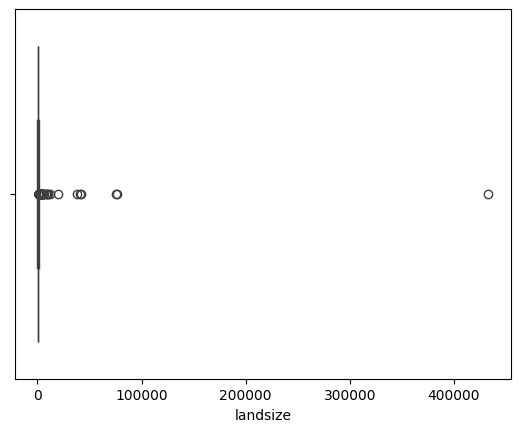

In [160]:
sns.boxplot(x=df[df['type']=='h']['landsize'])

In [161]:
df[df['type']=='u']['landsize'].describe()

count     3017.000000
mean       477.314219
std       1728.507195
min          0.000000
25%          0.000000
50%          0.000000
75%        263.000000
max      37000.000000
Name: landsize, dtype: float64

<Axes: xlabel='landsize'>

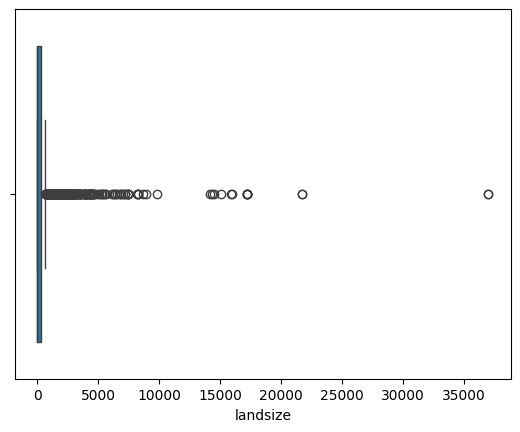

In [162]:
sns.boxplot(x=df[df['type']=='u']['landsize'])

In [163]:
df[df['type']=='t']['landsize'].describe()

count     1114.000000
mean       279.606822
std        655.849853
min          0.000000
25%        114.000000
50%        198.500000
75%        296.750000
max      15900.000000
Name: landsize, dtype: float64

<Axes: xlabel='landsize'>

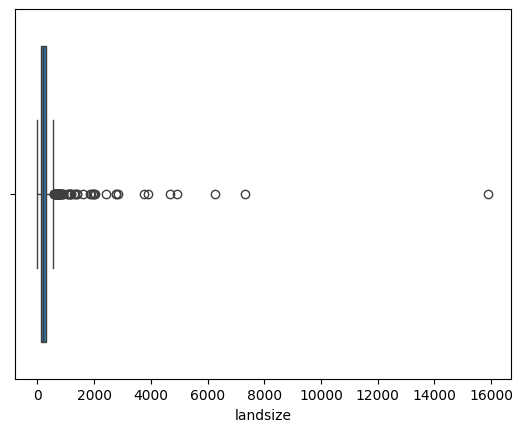

In [164]:
sns.boxplot(x=df[df['type']=='t']['landsize'])

* so according to landsize distribution among each of the house type
    - the main !villain! value is 0.00 which is disturbing the complete distribution of landsize
    - we need a good imputer for the imputation of landsize based to no.of rooms,no of bedrooms,house_type,no.of bathrooms,car_space and building area which affects the price including the land size
    - i will be using KNNimputer for imputation 
    - i will be conducting two sample t-test for comaprison of mean before and after imputation of 0 between different types of house 

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13573 entries, 0 to 13572
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   suburb         13573 non-null  object        
 1   address        13573 non-null  object        
 2   rooms          13573 non-null  int64         
 3   type           13573 non-null  object        
 4   price          13573 non-null  float64       
 5   method         13573 non-null  object        
 6   sellerg        13573 non-null  object        
 7   date           13573 non-null  datetime64[ns]
 8   distance       13573 non-null  float64       
 9   postcode       13573 non-null  int64         
 10  bedroom2       13573 non-null  int64         
 11  bathroom       13573 non-null  int64         
 12  car            13573 non-null  float64       
 13  landsize       13573 non-null  float64       
 14  buildingarea   13573 non-null  float64       
 15  lattitude      1357

- features other than landsize on which property price depends on :suburb,rooms,distance,bedroom2,type,bathrooms,cars,building_area,year_built,council_area,regionname,postcode
- numrical_features: - rooms,distance,bedroom2,bathroom,cars,building_area,year_built
- catgorical features : - type,council_area,suburb
- we need to encode these categorical features before imputation into missing(0.0) landsize values.
- will use:
    - regionname : one-hot encoding using pd.getdummies : we have only eight categories
    - postcode : high-card- Target guided ordinal encoding 
    - suburb : high-car - Target guided ordinal encoding
    - type : one-hot encoding using pd.getdummies : we have only three categories
    - council_area : high-card -Target Guided ordinal encoding : we more than 3 categories in council_area column


let's create a deepcopy of maindataframe

In [166]:
df_copy=df.copy()

replacing 0.0 with np.nan

In [167]:
df_copy['landsize'].replace(0,np.nan,inplace=True)

C:\Users\suman\AppData\Local\Temp\ipykernel_19324\3738839934.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['landsize'].replace(0,np.nan,inplace=True)


In [168]:
x1bar=df_copy[df_copy['landsize'].notnull()]['price'].mean()
x2bar=df_copy[df_copy['landsize'].isna()]['price'].mean()
s1=df_copy[df_copy['landsize'].notnull()]['price'].std()
s2=df_copy[df_copy['landsize'].isna()]['price'].std()
n1=len(df_copy[df_copy['landsize'].notnull()]['price'])
n2=len(df_copy[df_copy['landsize'].isna()]['price'])
print(f"x1bar : {x1bar}")
print(f"x2bar : {x2bar}")
print(f"s1    : {s1}")
print(f"s2    : {s2}")
print(f"n1    : {n1}")
print(f"n2    : {n2}")

x1bar : 1147805.538507822
x2bar : 644288.8932439402
s1    : 647722.7609523009
s2    : 356665.2260693312
n1    : 11634
n2    : 1939


- 1- landsize not null
- 2-landsize null
- Null_hypothesis : H0 : mean_price when landsize is notnull and null are equal
- H0:mu1-mu2=0
- alternate hypothesis: h1 :  there is significant difference the both the means
- h1 : mu1-m2!=0
- two tailed test 
- alpha : 0.05

In [169]:
t_value=calc_two_sample_t_value(mu1=0,mu2=0,x1bar=x1bar,x2bar=x2bar,sample_std_devn1=s1,sample_std_devn2=s2,n1=n1,n2=n2)
t_value

(np.float64(49.93691801518628), np.float64(4431.05070777824))

In [170]:
stats.t.cdf(abs(t_value[0]),t_value[1])

np.float64(1.0)

In [171]:
p_value=2*(1-stats.t.cdf(abs(t_value[0]),t_value[1]))
p_value

np.float64(0.0)

- since p_value(0.0)<alpha(0.05)
- thus we reject the null hypothesis that mean price is equal when landsize values are notnull vs null 
- thus there is masssive difference in the means of price,thus we cannot delete the rows directly
- we will do KNNImputation for missing values

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13573 entries, 0 to 13572
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   suburb         13573 non-null  object        
 1   address        13573 non-null  object        
 2   rooms          13573 non-null  int64         
 3   type           13573 non-null  object        
 4   price          13573 non-null  float64       
 5   method         13573 non-null  object        
 6   sellerg        13573 non-null  object        
 7   date           13573 non-null  datetime64[ns]
 8   distance       13573 non-null  float64       
 9   postcode       13573 non-null  int64         
 10  bedroom2       13573 non-null  int64         
 11  bathroom       13573 non-null  int64         
 12  car            13573 non-null  float64       
 13  landsize       13573 non-null  float64       
 14  buildingarea   13573 non-null  float64       
 15  lattitude      1357

encoding type column

In [173]:
df_encoded=pd.get_dummies(df_copy,columns=['type'],prefix='type')

encoding council_area column

In [174]:
target_means=df.groupby('councilarea')['price'].mean()
target_means

councilarea
Banyule              9.489168e+05
Bayside              1.682636e+06
Boroondara           1.689132e+06
Brimbank             6.507076e+05
Cardinia             5.731250e+05
Casey                6.641741e+05
Darebin              9.241809e+05
Frankston            7.091544e+05
Glen Eira            1.091401e+06
Greater Dandenong    7.062891e+05
Hobsons Bay          1.008112e+06
Hume                 5.678010e+05
Kingston             9.956282e+05
Knox                 9.126526e+05
Macedon Ranges       6.541000e+05
Manningham           1.249726e+06
Maribyrnong          8.236126e+05
Maroondah            8.862913e+05
Melbourne            9.319969e+05
Melton               5.130786e+05
Monash               1.189118e+06
Moonee Valley        9.994378e+05
Moorabool            2.850000e+05
Moreland             8.348129e+05
Nillumbik            8.686180e+05
Port Phillip         1.175451e+06
Stonnington          1.321956e+06
Unavailable          1.325000e+06
Whitehorse           1.239906e+06
Wh

In [175]:
df_encoded['councilarea'].map(target_means)

0        1.141297e+06
1        1.141297e+06
2        1.141297e+06
3        1.141297e+06
4        1.141297e+06
             ...     
13568    1.189118e+06
13569    1.008112e+06
13570    1.008112e+06
13571    1.008112e+06
13572    8.236126e+05
Name: councilarea, Length: 13573, dtype: float64

In [176]:
df_encoded['council_area_encoded']=df_encoded['councilarea'].map(target_means)

In [177]:
df_encoded

,suburb,address,rooms,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type,living_rooms,type_h,type_t,type_u,council_area_encoded
0,Abbotsford,85 Turner St,2,1480000.0,S,Biggin,2016-12-03,2.5,3067,2,1,1.0,202.0,126.0,-37.79960,144.99840,Northern Metropolitan,4019.0,1935.0,Yarra,Winter,urban_pro,0,True,False,False,1.141297e+06
1,Abbotsford,25 Bloomburg St,2,1035000.0,S,Biggin,2016-02-04,2.5,3067,2,1,0.0,156.0,79.0,-37.80790,144.99340,Northern Metropolitan,4019.0,1900.0,Yarra,Winter,urban_pro,0,True,False,False,1.141297e+06
2,Abbotsford,5 Charles St,3,1465000.0,SP,Biggin,2017-03-04,2.5,3067,3,2,0.0,134.0,150.0,-37.80930,144.99440,Northern Metropolitan,4019.0,1900.0,Yarra,Winter,urban_pro,0,True,False,False,1.141297e+06
3,Abbotsford,40 Federation La,3,850000.0,PI,Biggin,2017-03-04,2.5,3067,3,2,1.0,94.0,126.0,-37.79690,144.99690,Northern Metropolitan,4019.0,1935.0,Yarra,Winter,urban_pro,0,True,False,False,1.141297e+06
4,Abbotsford,55a Park St,4,1600000.0,VB,Nelson,2016-06-04,2.5,3067,3,1,2.0,120.0,142.0,-37.80720,144.99410,Northern Metropolitan,4019.0,2014.0,Yarra,Summer,urban_pro,1,True,False,False,1.141297e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13568,Wheelers Hill,12 Strada Cr,4,1245000.0,S,Barry,2017-08-26,16.7,3150,4,2,2.0,652.0,126.0,-37.90562,145.16761,South-Eastern Metropolitan,7392.0,1981.0,Monash,Summer,urban,0,True,False,False,1.189118e+06
13569,Williamstown,77 Merrett Dr,3,1031000.0,SP,Williams,2017-08-26,6.8,3016,3,2,2.0,333.0,133.0,-37.85927,144.87904,Western Metropolitan,6380.0,1995.0,Hobsons Bay,Summer,urban_pro,0,True,False,False,1.008112e+06
13570,Williamstown,83 Power St,3,1170000.0,S,Raine,2017-08-26,6.8,3016,3,2,4.0,436.0,126.0,-37.85274,144.88738,Western Metropolitan,6380.0,1997.0,Hobsons Bay,Summer,urban_pro,0,True,False,False,1.008112e+06
13571,Williamstown,96 Verdon St,4,2500000.0,PI,Sweeney,2017-08-26,6.8,3016,4,1,5.0,866.0,157.0,-37.85908,144.89299,Western Metropolitan,6380.0,1920.0,Hobsons Bay,Summer,urban_pro,0,True,False,False,1.008112e+06


encoding suburb column

In [178]:
target_means=df.groupby('suburb')['price'].mean()

In [179]:
df_encoded['suburb'].map(target_means)

0        1.060366e+06
1        1.060366e+06
2        1.060366e+06
3        1.060366e+06
4        1.060366e+06
             ...     
13568    1.251488e+06
13569    1.312481e+06
13570    1.312481e+06
13571    1.312481e+06
13572    9.886155e+05
Name: suburb, Length: 13573, dtype: float64

In [180]:
df_encoded['suburb_encoded']=df_encoded['suburb'].map(target_means)

In [181]:
df_encoded.head()

,suburb,address,rooms,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type,living_rooms,type_h,type_t,type_u,council_area_encoded,suburb_encoded
0,Abbotsford,85 Turner St,2,1480000.0,S,Biggin,2016-12-03,2.5,3067,2,1,1.0,202.0,126.0,-37.7996,144.9984,Northern Metropolitan,4019.0,1935.0,Yarra,Winter,urban_pro,0,True,False,False,1.141297e+06,1.060366e+06
1,Abbotsford,25 Bloomburg St,2,1035000.0,S,Biggin,2016-02-04,2.5,3067,2,1,0.0,156.0,79.0,-37.8079,144.9934,Northern Metropolitan,4019.0,1900.0,Yarra,Winter,urban_pro,0,True,False,False,1.141297e+06,1.060366e+06
2,Abbotsford,5 Charles St,3,1465000.0,SP,Biggin,2017-03-04,2.5,3067,3,2,0.0,134.0,150.0,-37.8093,144.9944,Northern Metropolitan,4019.0,1900.0,Yarra,Winter,urban_pro,0,True,False,False,1.141297e+06,1.060366e+06
3,Abbotsford,40 Federation La,3,850000.0,PI,Biggin,2017-03-04,2.5,3067,3,2,1.0,94.0,126.0,-37.7969,144.9969,Northern Metropolitan,4019.0,1935.0,Yarra,Winter,urban_pro,0,True,False,False,1.141297e+06,1.060366e+06
4,Abbotsford,55a Park St,4,1600000.0,VB,Nelson,2016-06-04,2.5,3067,3,1,2.0,120.0,142.0,-37.8072,144.9941,Northern Metropolitan,4019.0,2014.0,Yarra,Summer,urban_pro,1,True,False,False,1.141297e+06,1.060366e+06


In [182]:
df['regionname'].unique()

array(['Northern Metropolitan', 'Western Metropolitan',
       'Southern Metropolitan', 'Eastern Metropolitan',
       'South-Eastern Metropolitan', 'Eastern Victoria',
       'Northern Victoria', 'Western Victoria'], dtype=object)

encoding regionname

In [183]:
pd.get_dummies(df_encoded,columns=['regionname'],prefix='region')

,suburb,address,rooms,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,propertycount,yearbuilt,councilarea,season,location_type,living_rooms,type_h,type_t,type_u,council_area_encoded,suburb_encoded,region_Eastern Metropolitan,region_Eastern Victoria,region_Northern Metropolitan,region_Northern Victoria,region_South-Eastern Metropolitan,region_Southern Metropolitan,region_Western Metropolitan,region_Western Victoria
0,Abbotsford,85 Turner St,2,1480000.0,S,Biggin,2016-12-03,2.5,3067,2,1,1.0,202.0,126.0,-37.79960,144.99840,4019.0,1935.0,Yarra,Winter,urban_pro,0,True,False,False,1.141297e+06,1.060366e+06,False,False,True,False,False,False,False,False
1,Abbotsford,25 Bloomburg St,2,1035000.0,S,Biggin,2016-02-04,2.5,3067,2,1,0.0,156.0,79.0,-37.80790,144.99340,4019.0,1900.0,Yarra,Winter,urban_pro,0,True,False,False,1.141297e+06,1.060366e+06,False,False,True,False,False,False,False,False
2,Abbotsford,5 Charles St,3,1465000.0,SP,Biggin,2017-03-04,2.5,3067,3,2,0.0,134.0,150.0,-37.80930,144.99440,4019.0,1900.0,Yarra,Winter,urban_pro,0,True,False,False,1.141297e+06,1.060366e+06,False,False,True,False,False,False,False,False
3,Abbotsford,40 Federation La,3,850000.0,PI,Biggin,2017-03-04,2.5,3067,3,2,1.0,94.0,126.0,-37.79690,144.99690,4019.0,1935.0,Yarra,Winter,urban_pro,0,True,False,False,1.141297e+06,1.060366e+06,False,False,True,False,False,False,False,False
4,Abbotsford,55a Park St,4,1600000.0,VB,Nelson,2016-06-04,2.5,3067,3,1,2.0,120.0,142.0,-37.80720,144.99410,4019.0,2014.0,Yarra,Summer,urban_pro,1,True,False,False,1.141297e+06,1.060366e+06,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13568,Wheelers Hill,12 Strada Cr,4,1245000.0,S,Barry,2017-08-26,16.7,3150,4,2,2.0,652.0,126.0,-37.90562,145.16761,7392.0,1981.0,Monash,Summer,urban,0,True,False,False,1.189118e+06,1.251488e+06,False,False,False,False,True,False,False,False
13569,Williamstown,77 Merrett Dr,3,1031000.0,SP,Williams,2017-08-26,6.8,3016,3,2,2.0,333.0,133.0,-37.85927,144.87904,6380.0,1995.0,Hobsons Bay,Summer,urban_pro,0,True,False,False,1.008112e+06,1.312481e+06,False,False,False,False,False,False,True,False
13570,Williamstown,83 Power St,3,1170000.0,S,Raine,2017-08-26,6.8,3016,3,2,4.0,436.0,126.0,-37.85274,144.88738,6380.0,1997.0,Hobsons Bay,Summer,urban_pro,0,True,False,False,1.008112e+06,1.312481e+06,False,False,False,False,False,False,True,False
13571,Williamstown,96 Verdon St,4,2500000.0,PI,Sweeney,2017-08-26,6.8,3016,4,1,5.0,866.0,157.0,-37.85908,144.89299,6380.0,1920.0,Hobsons Bay,Summer,urban_pro,0,True,False,False,1.008112e+06,1.312481e+06,False,False,False,False,False,False,True,False


In [184]:
df_encoded=pd.get_dummies(df_encoded,columns=['regionname'],prefix='region')

In [185]:
df_encoded.isna().sum()

suburb                                  0
address                                 0
rooms                                   0
price                                   0
method                                  0
sellerg                                 0
date                                    0
distance                                0
postcode                                0
bedroom2                                0
bathroom                                0
car                                     0
landsize                             1939
buildingarea                            0
lattitude                               0
longtitude                              0
propertycount                           0
yearbuilt                               0
councilarea                             0
season                                  0
location_type                           0
living_rooms                            0
type_h                                  0
type_t                            

encoding postcode column

In [186]:
target_means=df.groupby('postcode')['price'].mean()

In [187]:
df_encoded['postcode'].map(target_means)

0        1.060366e+06
1        1.060366e+06
2        1.060366e+06
3        1.060366e+06
4        1.060366e+06
             ...     
13568    1.341579e+06
13569    1.245889e+06
13570    1.245889e+06
13571    1.245889e+06
13572    9.886155e+05
Name: postcode, Length: 13573, dtype: float64

In [188]:
df_encoded['postcode_encoded']=df_encoded['postcode'].map(target_means)

In [189]:
df_encoded.head()

,suburb,address,rooms,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,propertycount,yearbuilt,councilarea,season,location_type,living_rooms,type_h,type_t,type_u,council_area_encoded,suburb_encoded,region_Eastern Metropolitan,region_Eastern Victoria,region_Northern Metropolitan,region_Northern Victoria,region_South-Eastern Metropolitan,region_Southern Metropolitan,region_Western Metropolitan,region_Western Victoria,postcode_encoded
0,Abbotsford,85 Turner St,2,1480000.0,S,Biggin,2016-12-03,2.5,3067,2,1,1.0,202.0,126.0,-37.7996,144.9984,4019.0,1935.0,Yarra,Winter,urban_pro,0,True,False,False,1.141297e+06,1.060366e+06,False,False,True,False,False,False,False,False,1.060366e+06
1,Abbotsford,25 Bloomburg St,2,1035000.0,S,Biggin,2016-02-04,2.5,3067,2,1,0.0,156.0,79.0,-37.8079,144.9934,4019.0,1900.0,Yarra,Winter,urban_pro,0,True,False,False,1.141297e+06,1.060366e+06,False,False,True,False,False,False,False,False,1.060366e+06
2,Abbotsford,5 Charles St,3,1465000.0,SP,Biggin,2017-03-04,2.5,3067,3,2,0.0,134.0,150.0,-37.8093,144.9944,4019.0,1900.0,Yarra,Winter,urban_pro,0,True,False,False,1.141297e+06,1.060366e+06,False,False,True,False,False,False,False,False,1.060366e+06
3,Abbotsford,40 Federation La,3,850000.0,PI,Biggin,2017-03-04,2.5,3067,3,2,1.0,94.0,126.0,-37.7969,144.9969,4019.0,1935.0,Yarra,Winter,urban_pro,0,True,False,False,1.141297e+06,1.060366e+06,False,False,True,False,False,False,False,False,1.060366e+06
4,Abbotsford,55a Park St,4,1600000.0,VB,Nelson,2016-06-04,2.5,3067,3,1,2.0,120.0,142.0,-37.8072,144.9941,4019.0,2014.0,Yarra,Summer,urban_pro,1,True,False,False,1.141297e+06,1.060366e+06,False,False,True,False,False,False,False,False,1.060366e+06


In [190]:
df_encoded.columns=df_encoded.columns.str.lower().str.replace(" ",'_')

In [191]:
df_encoded.columns

Index(['suburb', 'address', 'rooms', 'price', 'method', 'sellerg', 'date',
       'distance', 'postcode', 'bedroom2', 'bathroom', 'car', 'landsize',
       'buildingarea', 'lattitude', 'longtitude', 'propertycount', 'yearbuilt',
       'councilarea', 'season', 'location_type', 'living_rooms', 'type_h',
       'type_t', 'type_u', 'council_area_encoded', 'suburb_encoded',
       'region_eastern_metropolitan', 'region_eastern_victoria',
       'region_northern_metropolitan', 'region_northern_victoria',
       'region_south-eastern_metropolitan', 'region_southern_metropolitan',
       'region_western_metropolitan', 'region_western_victoria',
       'postcode_encoded'],
      dtype='object')

In [192]:
df_encoded.isna().sum()

suburb                                  0
address                                 0
rooms                                   0
price                                   0
method                                  0
sellerg                                 0
date                                    0
distance                                0
postcode                                0
bedroom2                                0
bathroom                                0
car                                     0
landsize                             1939
buildingarea                            0
lattitude                               0
longtitude                              0
propertycount                           0
yearbuilt                               0
councilarea                             0
season                                  0
location_type                           0
living_rooms                            0
type_h                                  0
type_t                            

let's check for buildingarea too as it can also have 0.00 values,if it would be,we would be adding that column too for imputation

In [193]:
df['buildingarea']

0        126.0
1         79.0
2        150.0
3        126.0
4        142.0
         ...  
13568    126.0
13569    133.0
13570    126.0
13571    157.0
13572    112.0
Name: buildingarea, Length: 13573, dtype: float64

In [194]:
df['buildingarea'].describe()

count    13573.000000
mean       136.366857
std         93.871066
min          0.000000
25%        122.000000
50%        126.000000
75%        129.700000
max       6791.000000
Name: buildingarea, dtype: float64

<Axes: xlabel='buildingarea', ylabel='Count'>

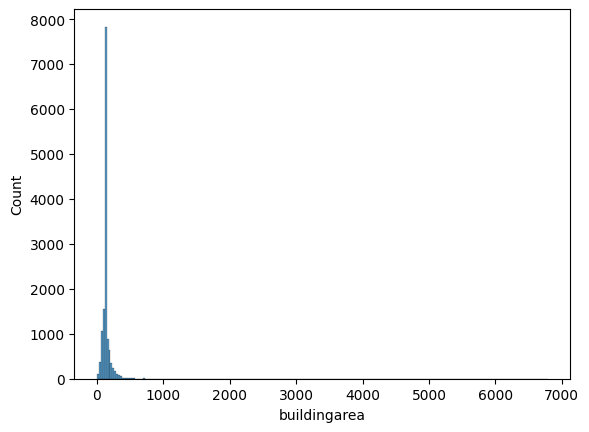

In [195]:
sns.histplot(df['buildingarea'])

<Axes: xlabel='buildingarea'>

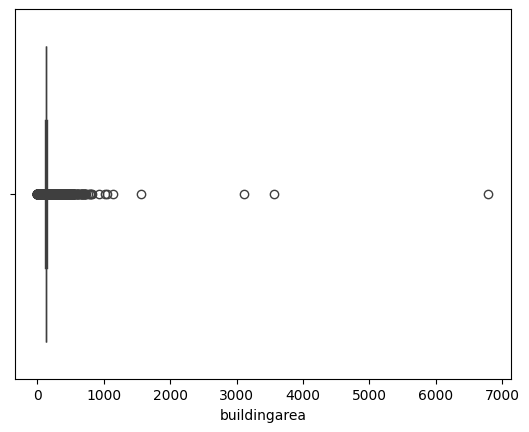

In [196]:
sns.boxplot(x=df['buildingarea'])

- YeSS! buildingarea with 0.00 and max is at 6791,we need to treat the missing values and then the outliers
- so many outliers present in the buildingarea

In [197]:
df[df['buildingarea']==0]

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type,living_rooms
4344,North Melbourne,19 Shands La,2,t,841000.0,S,Jellis,2017-03-04,2.3,3051,2,1,1.0,215.0,0.0,-37.79530,144.94370,Northern Metropolitan,6821.0,2000.0,Melbourne,Winter,urban_pro,0
12226,Balwyn North,14 Wanbrow Av,5,h,1950000.0,S,RT,2017-09-03,9.7,3104,5,3,2.0,743.0,0.0,-37.80235,145.09311,Southern Metropolitan,7809.0,1949.0,Boroondara,Summer,urban_pro,0
12249,Bundoora,22 Moreton Cr,3,h,814000.0,S,Barry,2017-09-03,12.1,3083,3,1,2.0,542.0,0.0,-37.70861,145.05691,Northern Metropolitan,10175.0,1970.0,Banyule,Summer,urban,0
12394,Roxburgh Park,16 Sandover Dr,4,h,570000.0,S,Raine,2017-09-03,20.6,3064,4,2,2.0,504.0,0.0,-37.61419,144.93448,Northern Metropolitan,5833.0,2000.0,Hume,Summer,rural,0
12411,Thornbury,19/337 Station St,3,t,900000.0,VB,Jellis,2017-09-03,7.0,3071,3,2,2.0,120.0,0.0,-37.76343,145.02096,Northern Metropolitan,8870.0,2000.0,Darebin,Summer,urban_pro,0
13037,Prahran,6 Aberdeen Rd,3,h,1390000.0,S,Marshall,2017-08-19,4.6,3181,3,2,1.0,125.0,0.0,-37.85257,145.00296,Southern Metropolitan,7717.0,2002.0,Stonnington,Summer,urban_pro,0
13204,Huntingdale,33 Beauford St,3,h,1205000.0,SA,FN,2017-09-23,12.3,3166,3,2,4.0,622.0,0.0,-37.90823,145.10851,Southern Metropolitan,768.0,1960.0,Monash,Summer,urban,0
13343,Balwyn North,1 Hosken St,5,h,2800000.0,S,Marshall,2017-08-26,9.7,3104,5,2,2.0,1173.0,0.0,-37.80385,145.09094,Southern Metropolitan,7809.0,1960.0,Boroondara,Summer,urban_pro,0
13365,Brighton East,60 Cummins Rd,3,h,1650000.0,SP,Buxton,2017-08-26,10.3,3187,3,2,2.0,623.0,0.0,-37.92698,145.02673,Southern Metropolitan,6938.0,1920.0,Bayside,Summer,urban,0
13375,Bundoora,37 Greenwood Dr,4,h,815000.0,S,Ray,2017-08-26,12.1,3083,4,2,1.0,525.0,0.0,-37.70765,145.05556,Northern Metropolitan,10175.0,1965.0,Banyule,Summer,urban,0


In [198]:
df_encoded.loc[df_encoded['buildingarea']==0,'buildingarea']=np.nan

In [199]:
df_encoded.isna().sum()

suburb                                  0
address                                 0
rooms                                   0
price                                   0
method                                  0
sellerg                                 0
date                                    0
distance                                0
postcode                                0
bedroom2                                0
bathroom                                0
car                                     0
landsize                             1939
buildingarea                           17
lattitude                               0
longtitude                              0
propertycount                           0
yearbuilt                               0
councilarea                             0
season                                  0
location_type                           0
living_rooms                            0
type_h                                  0
type_t                            

let's do a two sample t-test for building area,is there any difference in means of price with notnull building area values and null building area values

In [200]:
x1bar=df_encoded[df_encoded['buildingarea'].notnull()]['price'].mean()
x2bar=df_encoded[df_encoded['buildingarea'].isna()]['price'].mean()
s1=df_encoded[df_encoded['buildingarea'].notnull()]['price'].std()
s2=df_encoded[df_encoded['buildingarea'].isna()]['price'].std()
n1=len(df_encoded[df_encoded['buildingarea'].notnull()]['price'])
n2=len(df_encoded[df_encoded['buildingarea'].isna()]['price'])
print(f"x1bar : {x1bar}")
print(f"x2bar : {x2bar}")
print(f"s1    : {s1}")
print(f"s2    : {s2}")
print(f"n1    : {n1}")
print(f"n2    : {n2}")


x1bar : 1075406.8529802302
x2bar : 1448852.9411764706
s1    : 638888.7423335756
s2    : 909356.5679352949
n1    : 13556
n2    : 17


- 1- buildingarea not null
- 2-buildingarea null
- Null_hypothesis : H0 : mean_price when buildingarea is notnull and null are equal
- H0:mu1-mu2=0
- alternate hypothesis: h1 :  there is significant difference the both the means
- h1 : mu1-m2!=0
- two tailed test 
- alpha : 0.05

In [201]:
t_value=calc_two_sample_t_value(mu1=0,mu2=0,x1bar=x1bar,x2bar=x2bar,sample_std_devn1=s1,sample_std_devn2=s2,n1=n1,n2=n2)
t_value

(np.float64(-1.6927148028615482), np.float64(16.019814523471837))

In [202]:
p_value=2*(1-stats.t.cdf(abs(t_value[0]),t_value[1]))
p_value

np.float64(0.10986355862966679)

- since pvalue>alpha(0.05)
- thus we fail to reject the null hypothesis,thus we don't have enough evidence to prove that there is significant difference in both the means
- since there are only 17 rows with 0.00(converted to nan) we will knnimputer for imputation

starting imputation to landsize and buildingarea column

In [203]:
from sklearn.impute import KNNImputer
features=['rooms','distance','price','bedroom2','bathroom',
          'car','landsize','buildingarea','yearbuilt',
          'type_h','type_t','type_u','council_area_encoded','suburb_encoded',
          'region_eastern_metropolitan', 'region_eastern_victoria',
        'region_northern_metropolitan', 'region_northern_victoria',
        'region_south-eastern_metropolitan', 'region_southern_metropolitan',
       'region_western_metropolitan', 'region_western_victoria',
       'postcode_encoded']
imputer=KNNImputer(n_neighbors=5)
df_imputed=imputer.fit_transform(df_encoded[features])

In [204]:
df_temp=pd.DataFrame(df_imputed,columns=features)

In [205]:
df_encoded['landsize_imputed']=df_temp['landsize']
df_encoded['buildingarea_imputed']=df_temp['buildingarea']

In [206]:
df_encoded.isna().sum()

suburb                                  0
address                                 0
rooms                                   0
price                                   0
method                                  0
sellerg                                 0
date                                    0
distance                                0
postcode                                0
bedroom2                                0
bathroom                                0
car                                     0
landsize                             1939
buildingarea                           17
lattitude                               0
longtitude                              0
propertycount                           0
yearbuilt                               0
councilarea                             0
season                                  0
location_type                           0
living_rooms                            0
type_h                                  0
type_t                            

In [207]:
df['landsize_imputed']=df_temp['landsize']
df['buildingarea_imputed']=df_temp['buildingarea']

In [208]:
df[df['landsize']!=df['landsize_imputed']]

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type,living_rooms,landsize_imputed,buildingarea_imputed
8,Abbotsford,6/241 Nicholson St,1,u,300000.0,S,Biggin,2016-10-08,2.5,3067,1,1,1.0,0.0,126.00,-37.80080,144.99730,Northern Metropolitan,4019.0,1935.0,Yarra,Winter,urban_pro,0,2930.2,126.00
10,Abbotsford,411/8 Grosvenor St,2,u,700000.0,VB,Jellis,2016-11-12,2.5,3067,2,2,1.0,0.0,126.00,-37.81100,145.00670,Northern Metropolitan,4019.0,1935.0,Yarra,Winter,urban_pro,0,2060.8,126.00
12,Abbotsford,123/56 Nicholson St,2,u,750000.0,S,Biggin,2016-11-12,2.5,3067,2,2,1.0,0.0,94.00,-37.80780,144.99650,Northern Metropolitan,4019.0,2009.0,Yarra,Winter,urban_pro,0,1122.0,94.00
14,Abbotsford,7/20 Abbotsford St,1,u,441000.0,SP,Greg,2016-05-14,2.5,3067,1,1,1.0,0.0,126.00,-37.80160,144.99880,Northern Metropolitan,4019.0,1935.0,Yarra,Summer,urban_pro,0,4696.8,126.00
21,Abbotsford,13/11 Nicholson St,3,t,900000.0,S,Beller,2017-03-18,2.5,3067,3,2,2.0,0.0,126.00,-37.80930,144.99590,Northern Metropolitan,4019.0,2010.0,Yarra,Winter,urban_pro,0,116.6,126.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12168,St Kilda,45/151 Fitzroy St,2,u,600000.0,VB,hockingstuart,2017-07-29,5.0,3182,2,1,1.0,0.0,82.00,-37.85911,144.97900,Southern Metropolitan,13240.0,1930.0,Port Phillip,Summer,urban_pro,0,3103.4,82.00
12176,Surrey Hills,6/91 Warrigal Rd,3,u,1050000.0,PI,hockingstuart,2017-07-29,10.2,3127,3,2,2.0,0.0,126.00,-37.83358,145.09884,Southern Metropolitan,5457.0,1950.0,Whitehorse,Summer,urban,0,446.4,126.00
12188,Tullamarine,9/200 Melrose Dr,2,u,300000.0,SP,Jason,2017-07-29,12.9,3043,2,1,1.0,0.0,66.32,-37.69815,144.88019,Western Metropolitan,3296.0,1980.0,Hume,Summer,urban,0,190.8,66.32
12207,Williamstown,2/29 Dover Rd,1,u,385000.0,SP,Williams,2017-07-29,6.8,3016,1,1,1.0,0.0,35.64,-37.85588,144.89936,Western Metropolitan,6380.0,1967.0,Hobsons Bay,Summer,urban_pro,0,1240.0,35.64


In [209]:
df.isna().sum()

suburb                  0
address                 0
rooms                   0
type                    0
price                   0
method                  0
sellerg                 0
date                    0
distance                0
postcode                0
bedroom2                0
bathroom                0
car                     0
landsize                0
buildingarea            0
lattitude               0
longtitude              0
regionname              0
propertycount           0
yearbuilt               0
councilarea             0
season                  0
location_type           0
living_rooms            0
landsize_imputed        0
buildingarea_imputed    0
dtype: int64

now lets test either is there any statistical difference in means landsize when landsize have values of 0.00 VS when imputed using KNN

Two sampe t_test between mean_landsize for landsize having 0.00 VS mean_landsize for landsize after imputation

In [210]:
df['landsize'].mean()

np.float64(555.1095557356516)

In [211]:
df['landsize_imputed'].mean()

np.float64(728.1964193619687)

In [212]:
x1bar=df['landsize_imputed'].mean()
x2bar=df['landsize'].mean()
s1=df['landsize_imputed'].std()
s2=df['landsize'].std()
n1=len(df['landsize_imputed'])
n2=len(df['landsize'])
print(f"x1bar : {x1bar}")
print(f"x2bar : {x2bar}")
print(f"s1    : {s1}")
print(f"s2    : {s2}")
print(f"n1    : {n1}")
print(f"n2    : {n2}")

x1bar : 728.1964193619687
x2bar : 555.1095557356516
s1    : 4067.4038269923662
s2    : 3973.825884260791
n1    : 13573
n2    : 13573


- 1- landsize imputed
- 2- landsize have values 0.00
- Null_hypothesis : H0 : mean_price when landsize imputed and landsize have values 0.00 are equal
- H0:mu1-mu2=0
- alternate hypothesis: h1 :  there is significant difference the both the means
- h1 : mu1-m2!=0
- two tailed test 
- alpha : 0.05
- mu1=mu2=0

In [213]:
t_value=calc_two_sample_t_value(mu1=0,mu2=0,x1bar=x1bar,x2bar=x2bar,sample_std_devn1=s1,sample_std_devn2=s2,n1=n1,n2=n2)
t_value

(np.float64(3.5462157703689905), np.float64(27129.307925096407))

In [214]:
p_value=2*(1-stats.t.cdf(abs(t_value[0]),t_value[1]))
p_value

np.float64(0.000391464391471974)

- since p_value(0.00039146....) < alpha(0.5)
- thus we reject the null hypothesis,the is statistical evidence that there is significant difference in mean_landsize in both the cases
- There is a significant difference. Thus, the imputation SUCCEEDED in correcting the zero-bias.

let's do the same statistical analysis for buildingarea with 0.00 and buildingarea_imputed

In [215]:
x1bar=df['buildingarea_imputed'].mean()
x2bar=df['buildingarea'].mean()
s1=df['buildingarea_imputed'].std()
s2=df['buildingarea'].std()
n1=len(df['buildingarea_imputed'])
n2=len(df['buildingarea'])
print(f"x1bar : {x1bar}")
print(f"x2bar : {x2bar}")
print(f"s1    : {s1}")
print(f"s2    : {s2}")
print(f"n1    : {n1}")
print(f"n2    : {n2}")

x1bar : 136.5658398069697
x2bar : 136.36685653134901
s1    : 93.76686267074997
s2    : 93.87106580332777
n1    : 13573
n2    : 13573


- 1- buildingarea imputed
- 2- building have values 0.00
- Null_hypothesis : H0 : mean when buildingarea imputed and buildingarea have values 0.00 are equal
- H0:mu1-mu2=0
- alternate hypothesis: h1 :  there is significant difference the both the means
- h1 : mu1-m2!=0
- two tailed test 
- alpha : 0.05
- mu1=mu2=0

In [216]:
t_value=calc_two_sample_t_value(mu1=0,mu2=0,x1bar=x1bar,x2bar=x2bar,sample_std_devn1=s1,sample_std_devn2=s2,n1=n1,n2=n2)
t_value

(np.float64(0.17472248650201183), np.float64(27143.966514767017))

In [217]:
p_value=2*(1-stats.t.cdf(abs(t_value[0]),t_value[1]))
p_value

np.float64(0.861299001007829)

- since p_value(0.861299....) > alpha(0.05)
- thus we fail to reject the null hypothesis,thus we don't have evidence that both means are different
- so the imputation worked
- next we will be again checking for stats and outliers and capping them

in the landsize_imputed column,still there are outliers,and wee need to treat them

<Axes: xlabel='landsize_imputed', ylabel='Count'>

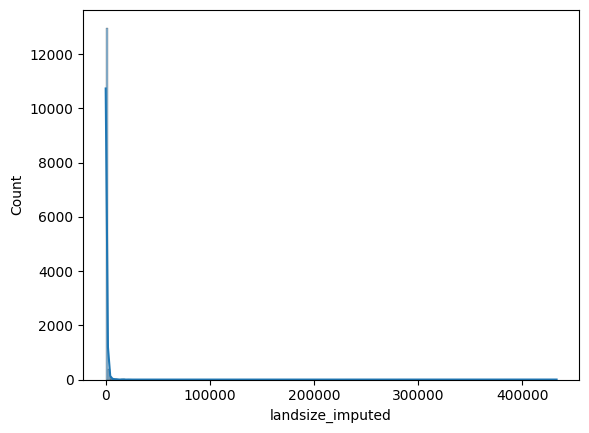

In [218]:
sns.histplot(df['landsize_imputed'],kde=True)

<Axes: xlabel='landsize_imputed'>

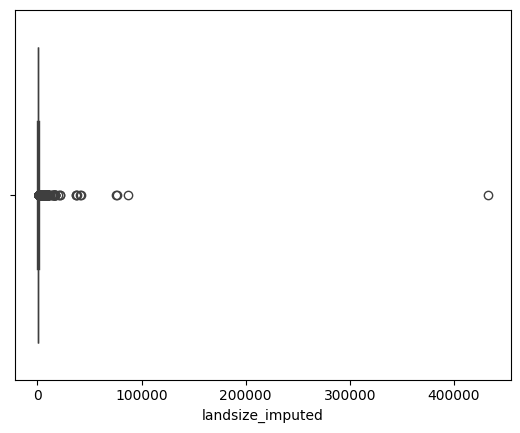

In [219]:
sns.boxplot(x=df['landsize_imputed'])

still there are outliers which needed to be fixed

In [220]:
df[df['type']=='u']['landsize_imputed'].describe()

count     3017.000000
mean      1165.145244
std       1903.020174
min          1.000000
25%        246.200000
50%        698.400000
75%       1360.600000
max      37000.000000
Name: landsize_imputed, dtype: float64

In [221]:
df[df['type']=='t']['landsize_imputed'].describe()

count     1114.000000
mean       364.303770
std        771.403032
min          3.000000
25%        154.000000
50%        230.000000
75%        325.000000
max      15900.000000
Name: landsize_imputed, dtype: float64

In [222]:
df[df['type']=='h']['landsize_imputed'].describe()

count      9442.000000
mean        631.511587
std        4740.212132
min           1.000000
25%         337.000000
50%         563.000000
75%         678.000000
max      433014.000000
Name: landsize_imputed, dtype: float64

capping outliers when type is 'u'

In [223]:
q1=df[df['type']=='u']['landsize_imputed'].quantile(0.25)
q3=df[df['type']=='u']['landsize_imputed'].quantile(0.75)
iqr=q3-q1
lower=q1-(1.5*iqr)
upper=q3+(1.5*iqr)
print(f"Q1 : {q1}   Q2 : {q3}   iqr : {iqr}   lower : {lower}   upper : {upper}")


Q1 : 246.2   Q2 : 1360.6   iqr : 1114.3999999999999   lower : -1425.3999999999999   upper : 3032.2


- we cannot cap outliers on lower fence for any type as lower goes in negative
- we need to do physical capping on lower side and calculated capping on upper side
- type 'u' - lower_cap - 50m^2
- type 't' - lower_cap - 100m^2
- type 'h' - lower_cap - 150m^2

In [224]:
df[df['type']=='u']['landsize_imputed'].describe()

count     3017.000000
mean      1165.145244
std       1903.020174
min          1.000000
25%        246.200000
50%        698.400000
75%       1360.600000
max      37000.000000
Name: landsize_imputed, dtype: float64

In [225]:
df[(df['type']=='u')&(df['landsize_imputed']<50)]

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type,living_rooms,landsize_imputed,buildingarea_imputed
994,Box Hill,7/12 Oxford St,1,u,340000.0,SP,Lindellas,2017-03-18,13.1,3128,1,1,1.0,29.0,126.0,-37.82150,145.12140,Eastern Metropolitan,4605.0,1950.0,Whitehorse,Winter,urban,0,29.0,126.0
2664,Footscray,1/30 Pickett St,2,u,305000.0,PI,Burnham,2017-03-04,6.4,3011,2,1,1.0,47.0,35.0,-37.80140,144.89590,Western Metropolitan,7570.0,2013.0,Maribyrnong,Winter,urban_pro,0,47.0,35.0
4690,Pascoe Vale,4/305 Cumberland Rd,1,u,248500.0,S,Brad,2016-08-28,9.9,3044,1,1,1.0,49.0,49.0,-37.71520,144.94020,Northern Metropolitan,7485.0,1970.0,Moreland,Summer,urban_pro,0,49.0,49.0
4915,Preston,3/413 Gilbert Rd,1,u,305000.0,S,Nelson,2016-12-10,8.8,3072,1,1,1.0,41.0,126.0,-37.73670,144.98990,Northern Metropolitan,14577.0,1955.0,Darebin,Winter,urban_pro,0,41.0,126.0
6019,Sunshine North,2/86 Phoenix St,2,u,315000.0,PI,Douglas,2016-10-08,13.3,3020,2,1,1.0,14.0,126.0,-37.77560,144.83450,Western Metropolitan,4217.0,1960.0,Brimbank,Winter,urban,0,14.0,126.0
7303,Albion,8/6 Ridley St,1,u,145000.0,PI,Biggin,2016-05-28,13.9,3020,1,1,1.0,36.0,126.0,-37.78330,144.82660,Western Metropolitan,2185.0,1962.5,Brimbank,Summer,urban,0,36.0,126.0
7710,Carnegie,2/13 Emily St,2,u,603000.0,S,hockingstuart,2017-05-20,11.4,3163,2,1,1.0,2.0,126.0,-37.89120,145.06440,Southern Metropolitan,7822.0,1970.0,Glen Eira,Summer,urban,0,2.0,126.0
7743,Clifton Hill,1/8 Louise St,2,u,712000.0,S,MICM,2017-05-20,3.4,3068,2,1,1.0,36.0,126.0,-37.79260,145.00190,Northern Metropolitan,2954.0,1910.0,Yarra,Summer,urban_pro,0,36.0,126.0
8364,South Yarra,6/38 Chambers St,3,u,1320000.0,S,RT,2017-05-06,3.3,3141,3,2,2.0,15.0,15.0,-37.83980,144.99450,Southern Metropolitan,14887.0,1970.0,Stonnington,Summer,urban_pro,0,15.0,15.0
8396,St Kilda,11/74 Barkly St,2,u,902000.0,S,McGrath,2017-04-29,6.1,3182,2,1,1.0,18.0,126.0,-37.86240,144.98230,Southern Metropolitan,13240.0,1970.0,Port Phillip,Summer,urban_pro,0,18.0,126.0


In [226]:
df.loc[(df['type']=='u')&(df['landsize_imputed']<50),'landsize_imputed']=50

In [227]:
df[(df['type']=='u')&(df['landsize_imputed']>upper)]

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type,living_rooms,landsize_imputed,buildingarea_imputed
14,Abbotsford,7/20 Abbotsford St,1,u,441000.0,SP,Greg,2016-05-14,2.5,3067,1,1,1.0,0.0,126.0,-37.80160,144.99880,Northern Metropolitan,4019.0,1935.0,Yarra,Summer,urban_pro,0,4696.8,126.0
22,Abbotsford,138/56 Nicholson St,3,u,1090000.0,S,Jellis,2017-03-18,2.5,3067,3,2,2.0,4290.0,27.0,-37.80780,144.99650,Northern Metropolitan,4019.0,1935.0,Yarra,Winter,urban_pro,0,4290.0,27.0
26,Abbotsford,5/20 Abbotsford St,1,u,426000.0,SP,Greg,2016-08-22,2.5,3067,1,1,1.0,0.0,126.0,-37.80160,144.99880,Northern Metropolitan,4019.0,1935.0,Yarra,Summer,urban_pro,0,4696.8,126.0
314,Ascot Vale,8/129 The Parade,1,u,390000.0,S,Alexkarbon,2016-11-12,5.9,3032,1,1,1.0,0.0,58.0,-37.77230,144.90940,Western Metropolitan,6567.0,1972.0,Moonee Valley,Winter,urban_pro,0,4113.0,58.0
814,Bentleigh East,9/7 Derry St,2,u,380000.0,PI,Buxton,2016-05-07,13.9,3165,2,2,1.0,0.0,78.0,-37.92120,145.06740,Southern Metropolitan,10969.0,1970.0,Glen Eira,Summer,urban,0,3445.2,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12168,St Kilda,45/151 Fitzroy St,2,u,600000.0,VB,hockingstuart,2017-07-29,5.0,3182,2,1,1.0,0.0,82.0,-37.85911,144.97900,Southern Metropolitan,13240.0,1930.0,Port Phillip,Summer,urban_pro,0,3103.4,82.0
12381,Port Melbourne,711/101 Bay St,2,u,820000.0,SP,Chisholm,2017-09-03,3.5,3207,2,2,2.0,4604.0,126.0,-37.84079,144.94002,Southern Metropolitan,8648.0,2000.0,Port Phillip,Summer,urban_pro,0,4604.0,126.0
12433,Ascot Vale,1/37 Ascot Vale Rd,3,u,870000.0,SP,Jellis,2017-09-09,4.3,3032,3,2,1.0,3215.0,178.0,-37.78344,144.92183,Western Metropolitan,6567.0,1900.0,Moonee Valley,Summer,urban_pro,0,3215.0,178.0
12592,Richmond,36/73 River St,2,u,592000.0,SA,Jellis,2017-09-09,2.4,3121,2,2,1.0,14294.0,77.0,-37.81894,145.01314,Northern Metropolitan,14949.0,2006.0,Yarra,Summer,urban_pro,0,14294.0,77.0


In [228]:
df.loc[(df['type']=='u')&(df['landsize_imputed']>upper),'landsize_imputed']=upper

In [229]:
df[df['type']=='u']['landsize_imputed'].describe()

count    3017.000000
mean      966.936825
std       884.978437
min        50.000000
25%       246.200000
50%       698.400000
75%      1360.600000
max      3032.200000
Name: landsize_imputed, dtype: float64

<Axes: ylabel='landsize_imputed'>

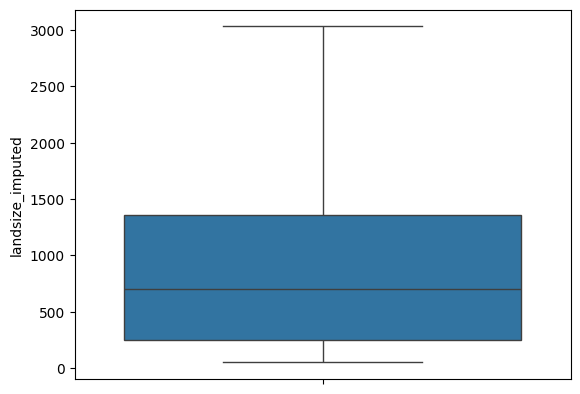

In [230]:
sns.boxplot(df[df['type']=='u']['landsize_imputed'])

capping outliers when type is 't'

In [231]:
df[df['type']=='t']['landsize_imputed'].describe()

count     1114.000000
mean       364.303770
std        771.403032
min          3.000000
25%        154.000000
50%        230.000000
75%        325.000000
max      15900.000000
Name: landsize_imputed, dtype: float64

In [232]:
q1=df[df['type']=='t']['landsize_imputed'].quantile(0.25)
q3=df[df['type']=='t']['landsize_imputed'].quantile(0.75)
iqr=q3-q1
lower=q1-(1.5*iqr)
upper=q3+(1.5*iqr)
print(f"Q1 : {q1}   Q2 : {q3}   iqr : {iqr}   lower : {lower}   upper : {upper}")

Q1 : 154.0   Q2 : 325.0   iqr : 171.0   lower : -102.5   upper : 581.5


* we cannot cap lower outliers as lower fencing is a negative value
* for type-'t',we will cap outliers at 100m^2 and upper outlier at upper fence

In [233]:
df[(df['type']=='t')&(df['landsize_imputed']<100)]

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type,living_rooms,landsize_imputed,buildingarea_imputed
189,Altona North,3/66 Marion St,2,t,421000.0,S,hockingstuart,2017-03-04,11.1,3025,2,1,1.0,77.0,77.0,-37.83510,144.85290,Western Metropolitan,5132.0,2009.0,Hobsons Bay,Winter,urban,0,77.0,77.0
773,Bentleigh,40 Coates St,2,t,680000.0,PI,Bayside,2016-11-27,13.0,3204,2,1,1.0,83.0,107.0,-37.92590,145.03410,Southern Metropolitan,6795.0,1998.0,Glen Eira,Winter,urban,0,83.0,107.0
1266,Brunswick,5/185 Brunswick Rd,4,t,860000.0,PI,Nelson,2016-05-07,5.2,3056,4,2,1.0,95.0,97.0,-37.77720,144.96530,Northern Metropolitan,11918.0,1926.0,Moreland,Summer,urban_pro,0,95.0,97.0
1285,Brunswick,7/117 Albion St,2,t,620000.0,S,Harrington,2016-12-10,5.2,3056,2,2,1.0,72.0,2.0,-37.76090,144.96900,Northern Metropolitan,11918.0,1926.0,Moreland,Winter,urban_pro,0,72.0,2.0
1302,Brunswick,2/12 Jones St,2,t,685000.0,SP,Jellis,2016-08-13,5.2,3056,2,2,1.0,0.0,100.0,-37.76170,144.96420,Northern Metropolitan,11918.0,2002.0,Moreland,Summer,urban_pro,0,91.6,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11733,Maribyrnong,7 Cavalry Cct,3,t,640000.0,S,Biggin,2017-07-22,4.3,3032,3,2,2.0,91.0,132.0,-37.77449,144.88011,Western Metropolitan,4918.0,2000.0,Maribyrnong,Summer,urban_pro,0,91.0,132.0
12377,Pascoe Vale,5/14 Devon Rd,2,t,500000.0,VB,Nelson,2017-09-03,8.5,3044,2,2,1.0,74.0,126.0,-37.72184,144.92969,Northern Metropolitan,7485.0,2011.0,Moreland,Summer,urban_pro,0,74.0,126.0
12662,Brunswick,4/135 Brunswick Rd,2,t,640000.0,S,Stockdale,2017-09-16,5.2,3056,2,1,1.0,82.0,2.0,-37.77761,144.96832,Northern Metropolitan,11918.0,1926.0,Moreland,Summer,urban_pro,0,82.0,2.0
12827,Richmond,37 Spencer Pl,3,t,1500000.0,VB,Jellis,2017-09-16,2.4,3121,3,2,2.0,72.0,145.0,-37.81937,145.00146,Northern Metropolitan,14949.0,2011.0,Yarra,Summer,urban_pro,0,72.0,145.0


In [234]:
df.loc[(df['type']=='t')&(df['landsize_imputed']<100),'landsize_imputed']=100
df.loc[(df['type']=='t')&(df['landsize_imputed']>upper),'landsize_imputed']=upper

In [235]:
df[(df['type']=='t')&(df['landsize_imputed']<100)]

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type,living_rooms,landsize_imputed,buildingarea_imputed


In [236]:
df[(df['type']=='t')&(df['landsize_imputed']>upper)]

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type,living_rooms,landsize_imputed,buildingarea_imputed


In [237]:
df[df['type']=='t']['landsize_imputed'].describe()

count    1114.000000
mean      263.236804
std       141.967030
min       100.000000
25%       154.000000
50%       230.000000
75%       325.000000
max       581.500000
Name: landsize_imputed, dtype: float64

Now capping 'landsize' where type='h'

In [238]:
df[df['type']=='h']['landsize_imputed'].describe()

count      9442.000000
mean        631.511587
std        4740.212132
min           1.000000
25%         337.000000
50%         563.000000
75%         678.000000
max      433014.000000
Name: landsize_imputed, dtype: float64

In [239]:
q1=df[df['type']=='h']['landsize_imputed'].quantile(0.25)
q3=df[df['type']=='h']['landsize_imputed'].quantile(0.75)
iqr=q3-q1
lower=q1-(1.5*iqr)
upper=q3+(1.5*iqr)
print(f"Q1 : {q1}   Q2 : {q3}   iqr : {iqr}   lower : {lower}   upper : {upper}")

Q1 : 337.0   Q2 : 678.0   iqr : 341.0   lower : -174.5   upper : 1189.5


* we cannot cap lower outliers as lower fencing is a negative value
* for type-'h',we will cap outliers at 150m^2 and upper outlier at upper fence

In [240]:
df[(df['type']=='h')&(df['landsize_imputed']<150)]

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type,living_rooms,landsize_imputed,buildingarea_imputed
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-03-04,2.5,3067,3,2,0.0,134.0,150.0,-37.80930,144.99440,Northern Metropolitan,4019.0,1900.0,Yarra,Winter,urban_pro,0,134.0,150.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,2017-03-04,2.5,3067,3,2,1.0,94.0,126.0,-37.79690,144.99690,Northern Metropolitan,4019.0,1935.0,Yarra,Winter,urban_pro,0,94.0,126.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,2016-06-04,2.5,3067,3,1,2.0,120.0,142.0,-37.80720,144.99410,Northern Metropolitan,4019.0,2014.0,Yarra,Summer,urban_pro,1,120.0,142.0
16,Abbotsford,42 Henry St,3,h,1200000.0,S,Jellis,2016-07-16,2.5,3067,3,2,1.0,113.0,110.0,-37.80560,144.99300,Northern Metropolitan,4019.0,1880.0,Yarra,Summer,urban_pro,0,113.0,110.0
17,Abbotsford,78 Yarra St,3,h,1176500.0,S,LITTLE,2016-07-16,2.5,3067,2,1,1.0,138.0,105.0,-37.80210,144.99650,Northern Metropolitan,4019.0,1890.0,Yarra,Summer,urban_pro,1,138.0,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13249,Northcote,23 Park St,2,h,1015000.0,S,Jellis,2017-09-23,5.3,3070,2,1,0.0,145.0,136.0,-37.77540,144.99275,Northern Metropolitan,11364.0,1930.0,Darebin,Summer,urban_pro,0,145.0,136.0
13261,Port Melbourne,61 Heath St,3,h,1635000.0,PI,Marshall,2017-09-23,3.5,3207,3,1,0.0,112.0,126.0,-37.83526,144.94423,Southern Metropolitan,8648.0,2000.0,Port Phillip,Summer,urban_pro,0,112.0,126.0
13284,South Melbourne,95 Bank St,2,h,1151000.0,S,Marshall,2017-09-23,1.9,3205,2,1,0.0,128.0,95.0,-37.83281,144.96633,Southern Metropolitan,5943.0,1890.0,Port Phillip,Summer,urban_pro,0,128.0,95.0
13292,St Kilda,4 Frampton St,2,h,1000000.0,VB,Marshall,2017-09-23,5.0,3182,2,1,0.0,106.0,134.0,-37.86191,144.98655,Southern Metropolitan,13240.0,1900.0,Port Phillip,Summer,urban_pro,0,106.0,134.0


In [241]:
df[(df['type']=='h')&(df['landsize_imputed']>upper)]

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type,living_rooms,landsize_imputed,buildingarea_imputed
234,Armadale,526 Orrong Rd,4,h,3000000.0,VB,Jellis,2016-06-04,6.3,3143,4,2,2.0,1581.0,126.0,-37.85800,145.01110,Southern Metropolitan,4836.0,1934.0,Stonnington,Summer,urban_pro,0,1581.0,126.0
251,Armadale,367 Dandenong Rd,6,h,5525000.0,S,Marshall,2016-09-17,6.3,3143,5,3,4.0,1491.0,516.0,-37.86020,145.01300,Southern Metropolitan,4836.0,1935.0,Stonnington,Summer,urban_pro,1,1491.0,516.0
379,Ashburton,115 Ashburn Gr,8,h,2950000.0,S,hockingstuart,2016-09-10,11.0,3147,8,7,4.0,1472.0,618.0,-37.87290,145.07880,Southern Metropolitan,3052.0,2009.0,Boroondara,Summer,urban,0,1472.0,618.0
454,Avondale Heights,22 Warrick Ct,4,h,1600000.0,PI,Nelson,2016-12-10,10.5,3034,4,3,3.0,1801.0,126.0,-37.75320,144.87660,Western Metropolitan,4502.0,1970.0,Moonee Valley,Winter,urban,0,1801.0,126.0
515,Balwyn,349 Union Rd,6,h,4000000.0,VB,Jellis,2016-12-03,9.7,3103,6,4,7.0,2051.0,449.0,-37.80510,145.10160,Southern Metropolitan,5682.0,1935.0,Boroondara,Winter,urban_pro,0,2051.0,449.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13404,Eltham North,45 Allison Cr,4,h,905000.0,S,Buckingham,2017-08-26,18.0,3095,4,2,0.0,2000.0,153.0,-37.70232,145.14190,Eastern Metropolitan,2346.0,1975.0,Nillumbik,Summer,urban,0,2000.0,153.0
13423,Frankston South,3 Diosma Ct,3,h,1155000.0,S,hockingstuart,2017-08-26,38.0,3199,3,2,2.0,2405.0,242.0,-38.16457,145.12421,South-Eastern Metropolitan,7566.0,1980.0,Frankston,Summer,rural_pro,0,2405.0,242.0
13455,Keilor East,18 Heatherlea Cr,4,h,886000.0,S,Nelson,2017-08-26,11.7,3033,4,2,4.0,5750.0,126.0,-37.74800,144.85098,Western Metropolitan,5629.0,1980.0,Moonee Valley,Summer,urban,0,5750.0,126.0
13477,Maribyrnong,88 The Esplanade,3,h,3400000.0,SP,Jas,2017-08-26,4.3,3032,3,1,5.0,2027.0,187.0,-37.76570,144.89109,Western Metropolitan,4918.0,1964.0,Maribyrnong,Summer,urban_pro,0,2027.0,187.0


In [242]:
df.loc[(df['type']=='h')&(df['landsize_imputed']<150),'landsize_imputed']=150

In [243]:
df.loc[(df['type']=='h')&(df['landsize_imputed']>upper),'landsize_imputed']=upper

In [244]:
df[df['type']=='h']['landsize_imputed'].describe()

count    9442.000000
mean      531.603728
std       233.524855
min       150.000000
25%       337.000000
50%       563.000000
75%       678.000000
max      1189.500000
Name: landsize_imputed, dtype: float64

<Axes: xlabel='landsize_imputed', ylabel='Count'>

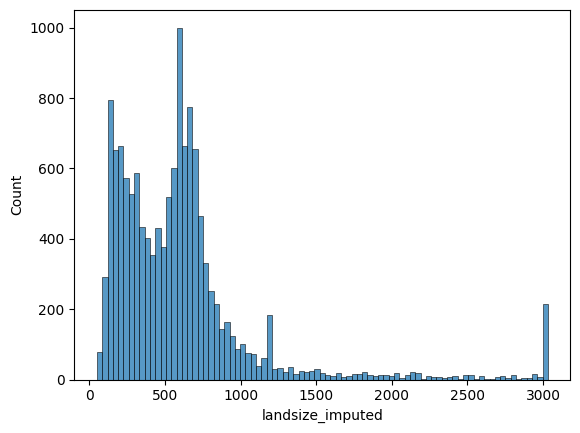

In [245]:
sns.histplot(df['landsize_imputed'])

In [246]:
df.isna().sum()

suburb                  0
address                 0
rooms                   0
type                    0
price                   0
method                  0
sellerg                 0
date                    0
distance                0
postcode                0
bedroom2                0
bathroom                0
car                     0
landsize                0
buildingarea            0
lattitude               0
longtitude              0
regionname              0
propertycount           0
yearbuilt               0
councilarea             0
season                  0
location_type           0
living_rooms            0
landsize_imputed        0
buildingarea_imputed    0
dtype: int64

In [247]:
df['buildingarea_imputed'].describe()

count    13573.000000
mean       136.565840
std         93.766863
min          1.000000
25%        122.000000
50%        126.000000
75%        130.000000
max       6791.000000
Name: buildingarea_imputed, dtype: float64

- wait!,how 1 can be a buildingarea,we need to cap the outliers
- lower fencing for house type if lower fenc goes in negative or less than below values:
    - u : 20m^2
    - t : 50m^2
    - h : 70m^2
- upper fencing:
    - q3+(1.5*iqr) for each house type

<Axes: xlabel='buildingarea_imputed'>

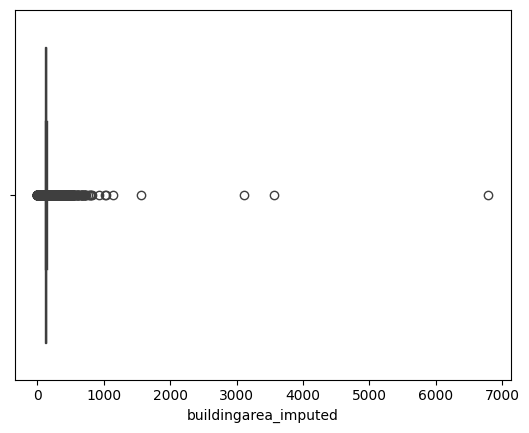

In [248]:
sns.boxplot(x=df['buildingarea_imputed'])

<Axes: xlabel='buildingarea_imputed', ylabel='Count'>

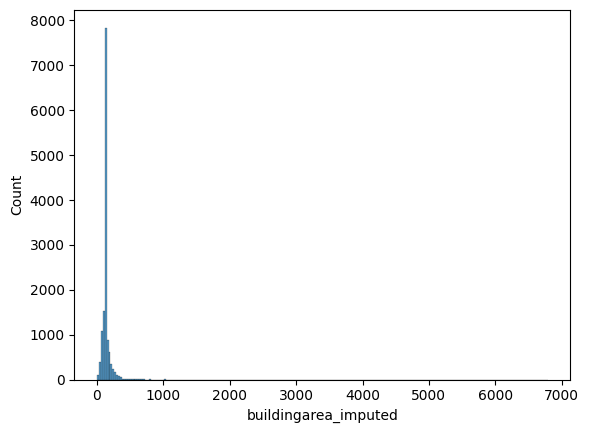

In [249]:
sns.histplot(df['buildingarea_imputed'])

for house 'type' - u

In [250]:
df[df['type']=='u']['buildingarea_imputed'].describe()

count    3017.000000
mean      102.235863
std        43.088005
min         1.000000
25%        73.000000
50%       126.000000
75%       126.000000
max      1561.000000
Name: buildingarea_imputed, dtype: float64

In [251]:
q1=df[df['type']=='u']['buildingarea_imputed'].quantile(0.25)
q3=df[df['type']=='u']['buildingarea_imputed'].quantile(0.75)
iqr=q3-q1
u_lower=q1-(1.5*iqr)
u_upper=q3+(1.5*iqr)
print(f"Q1 : {q1}   Q3 : {q3}   iqr : {iqr}   lower : {u_lower}   upper : {u_upper}")

Q1 : 73.0   Q3 : 126.0   iqr : 53.0   lower : -6.5   upper : 205.5


In [252]:
df.loc[(df['type']=='u')&(df['buildingarea_imputed']<20),'buildingarea_imputed']=20
df.loc[(df['type']=='u')&(df['buildingarea_imputed']>round(u_upper)),'buildingarea_imputed']=round(u_upper)

In [253]:
df[df['type']=='u']['buildingarea_imputed'].describe()

count    3017.000000
mean      101.537488
std        31.909974
min        20.000000
25%        73.000000
50%       126.000000
75%       126.000000
max       206.000000
Name: buildingarea_imputed, dtype: float64

for house 'type' - t

In [254]:
df[df['type']=='t']['buildingarea_imputed'].describe()

count    1114.000000
mean      135.027628
std       116.041432
min         1.000000
25%       120.000000
50%       126.000000
75%       138.000000
max      3558.000000
Name: buildingarea_imputed, dtype: float64

In [255]:
q1=df[df['type']=='t']['buildingarea_imputed'].quantile(0.25)
q3=df[df['type']=='t']['buildingarea_imputed'].quantile(0.75)
iqr=q3-q1
t_lower=q1-(1.5*iqr)
t_upper=q3+(1.5*iqr)
print(f"Q1 : {q1}   Q3 : {q3}   iqr : {iqr}   lower : {t_lower}   upper : {t_upper}")

Q1 : 120.0   Q3 : 138.0   iqr : 18.0   lower : 93.0   upper : 165.0


In [256]:
df.loc[(df['type']=='t')&(df['buildingarea_imputed']<50),'buildingarea_imputed']=50
df.loc[(df['type']=='t')&(df['buildingarea_imputed']>round(t_upper)),'buildingarea_imputed']=round(t_upper)

In [257]:
df[df['type']=='t']['buildingarea_imputed'].describe()

count    1114.000000
mean      126.185256
std        25.766908
min        50.000000
25%       120.000000
50%       126.000000
75%       138.000000
max       165.000000
Name: buildingarea_imputed, dtype: float64

for house 'type' - h

In [258]:
df[df['type']=='h']['buildingarea_imputed'].describe()

count    9442.000000
mean      147.716773
std        99.787427
min         1.000000
25%       126.000000
50%       126.000000
75%       146.000000
max      6791.000000
Name: buildingarea_imputed, dtype: float64

In [259]:
q1=df[df['type']=='h']['buildingarea_imputed'].quantile(0.25)
q3=df[df['type']=='h']['buildingarea_imputed'].quantile(0.75)
iqr=q3-q1
h_lower=q1-(1.5*iqr)
h_upper=q3+(1.5*iqr)
print(f"Q1 : {q1}   Q3 : {q3}   iqr : {iqr}   lower : {h_lower}   upper : {h_upper}")

Q1 : 126.0   Q3 : 146.0   iqr : 20.0   lower : 96.0   upper : 176.0


In [260]:
df.loc[(df['type']=='h')&(df['buildingarea_imputed']<70),'buildingarea_imputed']=70
df.loc[(df['type']=='h')&(df['buildingarea_imputed']>round(h_upper)),'buildingarea_imputed']=round(h_upper)

In [261]:
df[df['type']=='h']['buildingarea_imputed'].describe()

count    9442.000000
mean      133.463576
std        24.985184
min        70.000000
25%       126.000000
50%       126.000000
75%       146.000000
max       176.000000
Name: buildingarea_imputed, dtype: float64

<Axes: xlabel='buildingarea_imputed', ylabel='Count'>

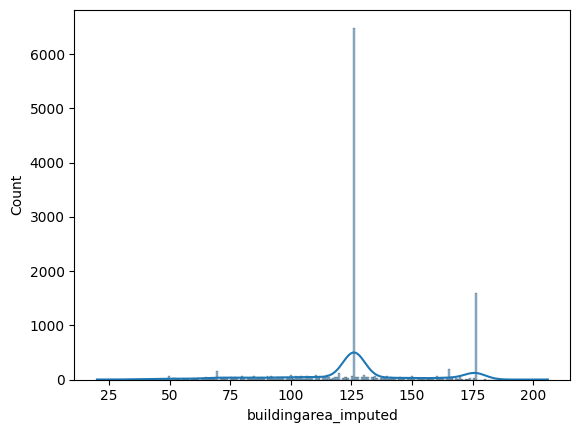

In [262]:
sns.histplot(df['buildingarea_imputed'],kde=True)

<Axes: xlabel='buildingarea_imputed'>

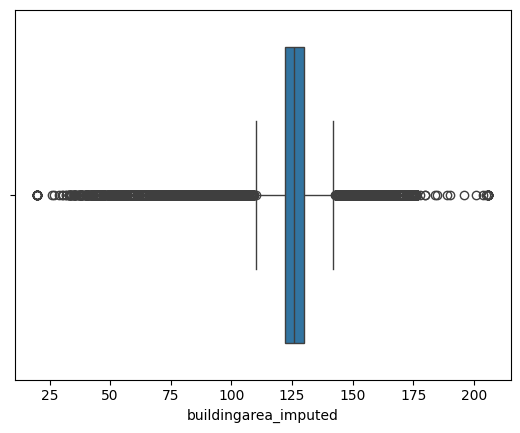

In [263]:
sns.boxplot(x=df['buildingarea_imputed'])

In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13573 entries, 0 to 13572
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   suburb                13573 non-null  object        
 1   address               13573 non-null  object        
 2   rooms                 13573 non-null  int64         
 3   type                  13573 non-null  object        
 4   price                 13573 non-null  float64       
 5   method                13573 non-null  object        
 6   sellerg               13573 non-null  object        
 7   date                  13573 non-null  datetime64[ns]
 8   distance              13573 non-null  float64       
 9   postcode              13573 non-null  int64         
 10  bedroom2              13573 non-null  int64         
 11  bathroom              13573 non-null  int64         
 12  car                   13573 non-null  float64       
 13  landsize        

In [265]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13573 entries, 0 to 13572
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   suburb                13573 non-null  object        
 1   address               13573 non-null  object        
 2   rooms                 13573 non-null  int64         
 3   type                  13573 non-null  object        
 4   price                 13573 non-null  float64       
 5   method                13573 non-null  object        
 6   sellerg               13573 non-null  object        
 7   date                  13573 non-null  datetime64[ns]
 8   distance              13573 non-null  float64       
 9   postcode              13573 non-null  int64         
 10  bedroom2              13573 non-null  int64         
 11  bathroom              13573 non-null  int64         
 12  car                   13573 non-null  float64       
 13  landsize        

In [266]:
df['lattitude']

0       -37.79960
1       -37.80790
2       -37.80930
3       -37.79690
4       -37.80720
           ...   
13568   -37.90562
13569   -37.85927
13570   -37.85274
13571   -37.85908
13572   -37.81188
Name: lattitude, Length: 13573, dtype: float64

In [267]:
df['longtitude']

0        144.99840
1        144.99340
2        144.99440
3        144.99690
4        144.99410
           ...    
13568    145.16761
13569    144.87904
13570    144.88738
13571    144.89299
13572    144.88449
Name: longtitude, Length: 13573, dtype: float64

<Axes: xlabel='longtitude', ylabel='lattitude'>

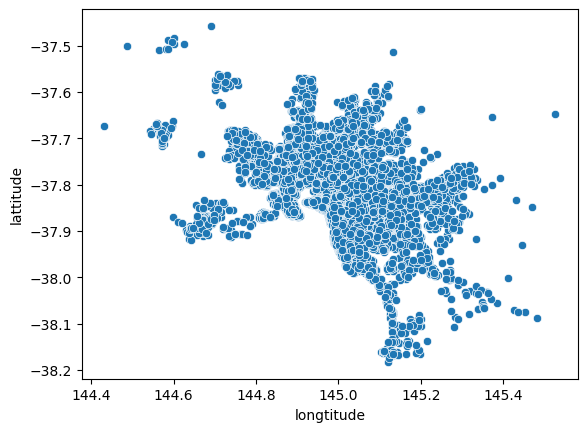

In [268]:
sns.scatterplot(x=df['longtitude'],y=df['lattitude'])

WOW! hat an interesting image of Melbourne
- we can see how dense the city is and approximately each of the house has been listed for sale

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13573 entries, 0 to 13572
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   suburb                13573 non-null  object        
 1   address               13573 non-null  object        
 2   rooms                 13573 non-null  int64         
 3   type                  13573 non-null  object        
 4   price                 13573 non-null  float64       
 5   method                13573 non-null  object        
 6   sellerg               13573 non-null  object        
 7   date                  13573 non-null  datetime64[ns]
 8   distance              13573 non-null  float64       
 9   postcode              13573 non-null  int64         
 10  bedroom2              13573 non-null  int64         
 11  bathroom              13573 non-null  int64         
 12  car                   13573 non-null  float64       
 13  landsize        

In [270]:
df['living_rooms']

0        0
1        0
2        0
3        0
4        1
        ..
13568    0
13569    0
13570    0
13571    0
13572    0
Name: living_rooms, Length: 13573, dtype: int64

In [271]:
df[df['living_rooms']<0]

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type,living_rooms,landsize_imputed,buildingarea_imputed


- so there are no living rooms in negative values 

## Bivariate Analysis

##### performing Bivarite analysis w.r.t 'Price' column as Price is target column for analysis

In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13573 entries, 0 to 13572
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   suburb                13573 non-null  object        
 1   address               13573 non-null  object        
 2   rooms                 13573 non-null  int64         
 3   type                  13573 non-null  object        
 4   price                 13573 non-null  float64       
 5   method                13573 non-null  object        
 6   sellerg               13573 non-null  object        
 7   date                  13573 non-null  datetime64[ns]
 8   distance              13573 non-null  float64       
 9   postcode              13573 non-null  int64         
 10  bedroom2              13573 non-null  int64         
 11  bathroom              13573 non-null  int64         
 12  car                   13573 non-null  float64       
 13  landsize        

In [273]:
suburb_data=df.groupby(['suburb'],as_index=False).agg(mean_price=('price','mean')).sort_values(by=['mean_price'],ascending=True)
suburb_data

,suburb,mean_price
18,Bacchus Marsh,2.850000e+05
238,Rockbank,3.400000e+05
177,Kurunjang,3.530000e+05
189,Melton South,3.807361e+05
90,Dallas,4.250000e+05
...,...,...
40,Brighton,1.930158e+06
4,Albert Park,1.941355e+06
193,Middle Park,2.082529e+06
58,Canterbury,2.180241e+06


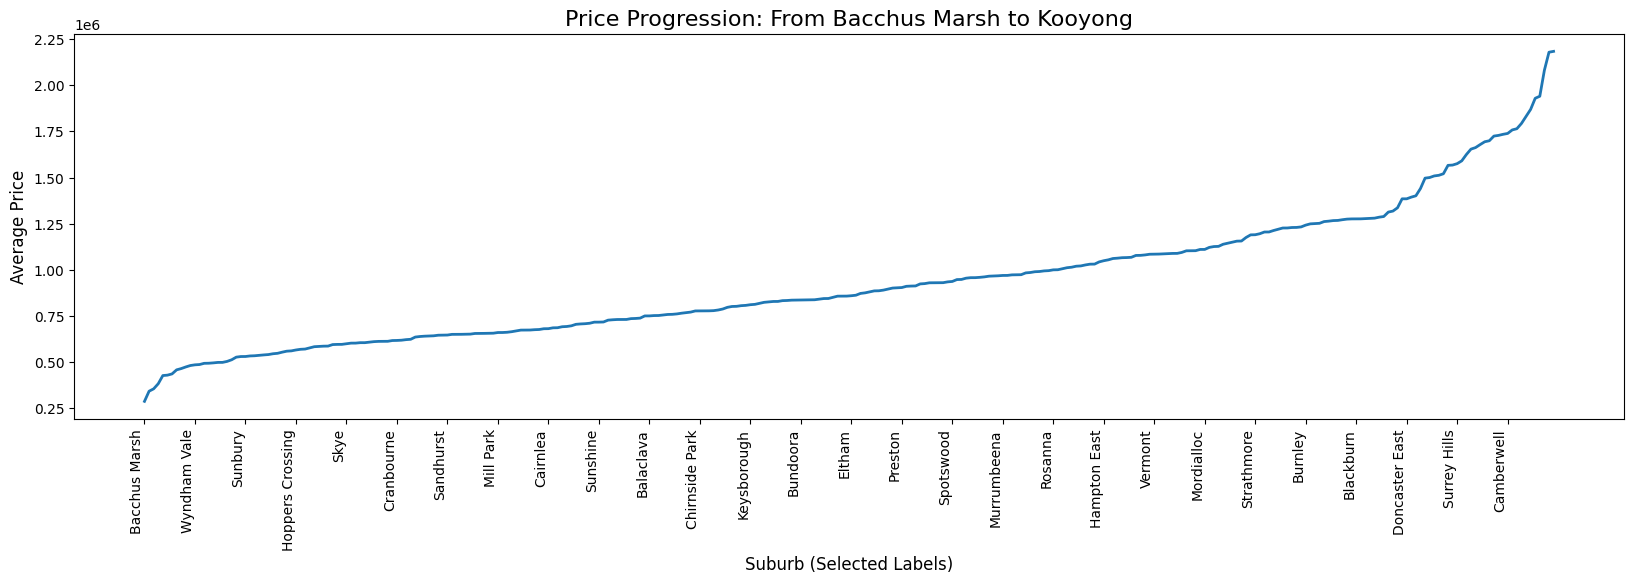

In [274]:
plt.figure(figsize=(20,5))
sns.lineplot(data=suburb_data,x='suburb',y='mean_price',linewidth=2)
plt.xticks(rotation=90,
           ticks=range(0,len(suburb_data),11),
           labels=suburb_data['suburb'][::11],
           ha='right')

plt.title("Price Progression: From Bacchus Marsh to Kooyong", fontsize=16)
plt.xlabel("Suburb (Selected Labels)", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.show()

* we can see that as we move from outskirts of melbourne towards melbournes center,the price changes and increases gradually showing the that livig around the center of city is more expensive than living at the outskirts of the city
    - therefore price completely depends on the suburb of the property

In [275]:
rooms_group_data=df.groupby(['rooms'],as_index=False).agg(mean_price=('price','mean')).sort_values(by=['mean_price'],ascending=False,)
rooms_group_data

,rooms,mean_price
6,7,1.920700e+06
4,5,1.871126e+06
5,6,1.849366e+06
7,8,1.602750e+06
3,4,1.445857e+06
2,3,1.076431e+06
8,10,9.000000e+05
1,2,7.750812e+05
0,1,4.338245e+05


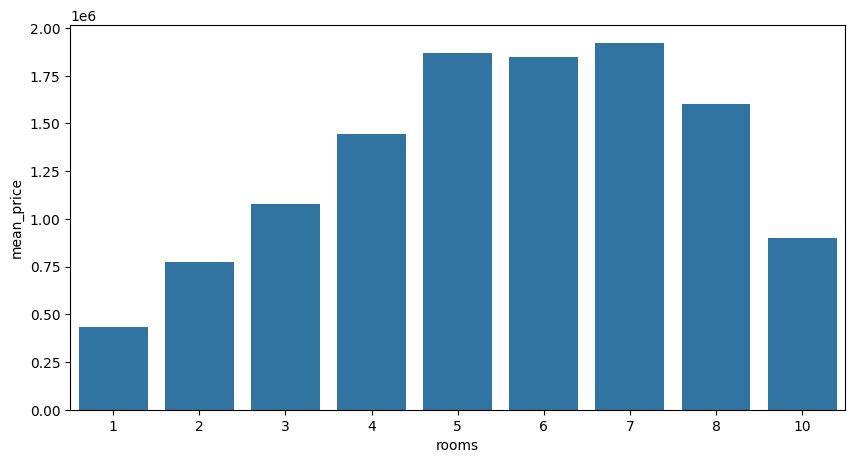

In [276]:
plt.figure(figsize=(10,5))
sns.barplot(x=rooms_group_data['rooms'],y=rooms_group_data['mean_price'])
plt.show()

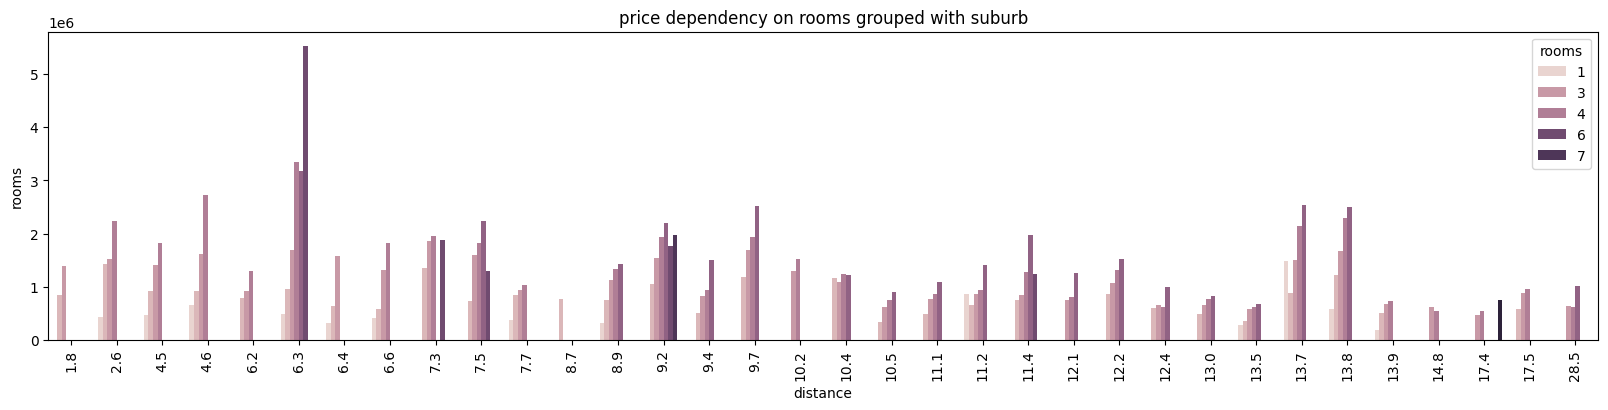

In [277]:
rooms_suburb_group_data=df.groupby(['suburb','rooms'],as_index=False).agg(mean_price=('price','mean')).sort_values(by=['mean_price'],ascending=True,).reset_index().drop(columns=['index'])
selected_suburbs=np.array(rooms_suburb_group_data['suburb'][::50])
selected_suburb_rooms_grouped_data=df[df['suburb'].isin(selected_suburbs)].groupby(['distance','rooms'],as_index=False).agg(mean_price=('price','mean')).sort_values(by=['mean_price'],ascending=True,).reset_index().drop(columns=['index'])
plt.figure(figsize=(20,4))
sns.barplot(x=selected_suburb_rooms_grouped_data['distance'],
              y=selected_suburb_rooms_grouped_data['mean_price'],
              hue=selected_suburb_rooms_grouped_data['rooms'])
plt.xticks(rotation=90)

plt.title('price dependency on rooms grouped with suburb')
plt.xlabel('distance')
plt.ylabel('rooms')
plt.show()


- from the above two plot,we can observe that:
- As the number of rooms is increasing,price of the property is increasing  BUT
    - number of rooms alone effects weakly on the price untill the distance factor is grouped with number of rooms
- price of property is higher at lower distance than that at higher distance with same number of rooms

Price VS House "type"

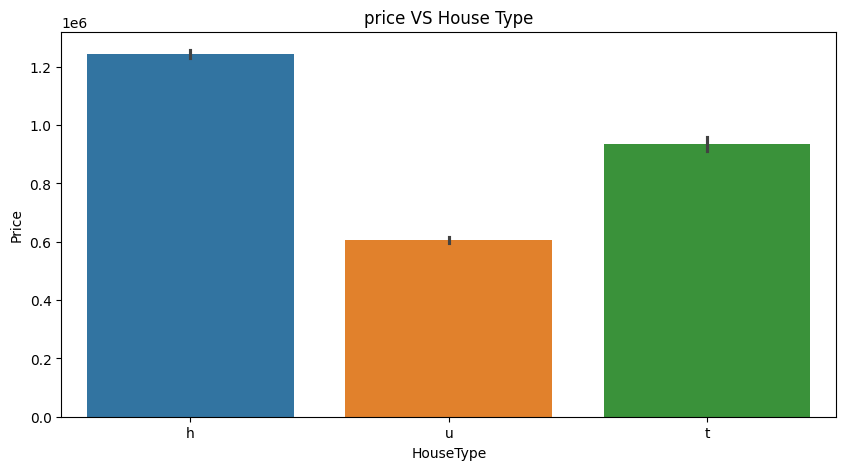

In [278]:
plt.figure(figsize=(10,5))
sns.barplot(data=df,x='type',y='price',hue='type')
plt.title('price VS House Type')
plt.xlabel('HouseType')
plt.ylabel('Price')
plt.show()

the above plot shows that:
- houses of type 'h' is more expensive as compared to 't' and is more expensive as compared to 'u'


lets check by adding regionname as hue as another effecting factor to the house 'type'

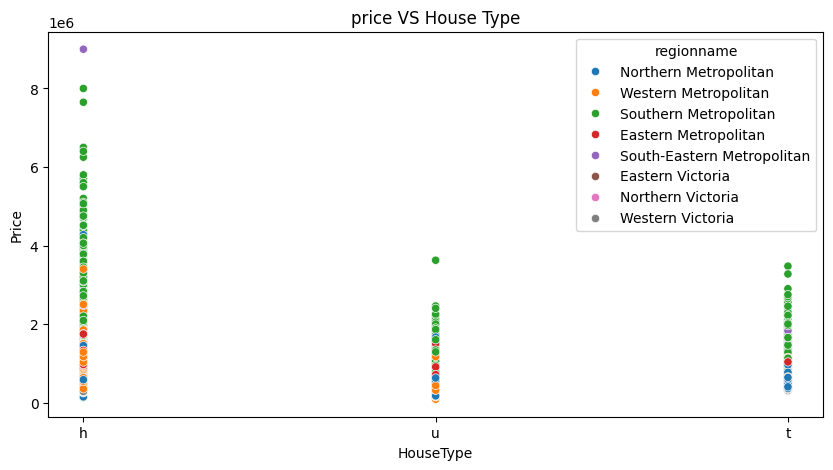

In [279]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df,x='type',y='price',hue='regionname',palette='tab10')
plt.title('price VS House Type')
plt.xlabel('HouseType')
plt.ylabel('Price')
plt.show()

but when region is added as hue,it shows that house type alone gives the weak effect on price but when 'region' factor is added with house 'type',house 'type' shows more effect on price

Price VS Method

In [280]:
df['method']

0         S
1         S
2        SP
3        PI
4        VB
         ..
13568     S
13569    SP
13570     S
13571    PI
13572    SP
Name: method, Length: 13573, dtype: object

In [281]:
df['method'].unique()

array(['S', 'SP', 'PI', 'VB', 'SA'], dtype=object)

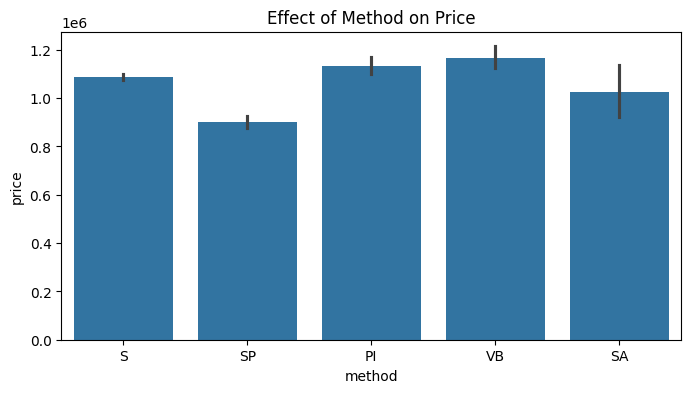

In [282]:
plt.figure(figsize=(8,4))
sns.barplot(data=df,x='method',y='price')
plt.title('Effect of Method on Price')
plt.xlabel('method')
plt.ylabel('price')
plt.show()

- While SP (Sold Prior) is slightly lower and VB (Vendor Bid) is slightly higher,
    - the overlapping bars suggest the effect is Weak or statistically insignificant compared to things like Rooms.
    - there we can conclude that Sale Method is not a primary driver of price.

Price VS Seller

In [283]:
df['sellerg'].value_counts().head(20)

sellerg
Nelson           1565
Jellis           1316
hockingstuart    1167
Barry            1011
Ray               700
Marshall          659
Buxton            632
Biggin            393
Brad              342
Woodards          301
Fletchers         300
Jas               243
Greg              239
McGrath           222
Sweeney           216
Noel              205
Miles             196
RT                184
Gary              170
Harcourts         167
Name: count, dtype: int64

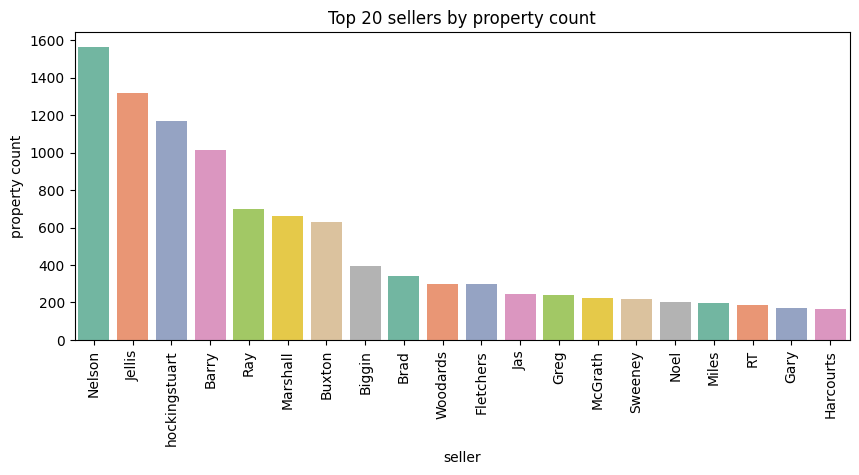

In [284]:
plt.figure(figsize=(10,4))
sns.barplot(x=df['sellerg'].value_counts().head(20).index,y=df['sellerg'].value_counts().head(20).values,hue=df['sellerg'].value_counts().head(20).index,palette='Set2')
plt.title('Top 20 sellers by property count')
plt.xlabel('seller')
plt.ylabel('property count')
plt.xticks(rotation=90)
plt.show()

- nelson sold the most number of properties foloowed by jellis followed by hockingstuart
- harcourts being last in top 20
- lets analyze their mean selling price,does it have negative or possitive effect on selling count

In [285]:
top_20_sellers=df['sellerg'].value_counts().head(20).index
top_20_seller_mean_selling_price=df[df['sellerg'].isin(top_20_sellers)].groupby(['sellerg'],as_index=False).agg(mean_price=('price','mean')).sort_values(by=['mean_price'],ascending=False)
top_20_seller_mean_selling_price

,sellerg,mean_price
10,Marshall,1.888844e+06
15,RT,1.504065e+06
9,Jellis,1.368163e+06
4,Fletchers,1.314666e+06
3,Buxton,1.232421e+06
6,Greg,1.230138e+06
14,Noel,1.198408e+06
12,Miles,1.087158e+06
11,McGrath,1.073789e+06
18,Woodards,1.042717e+06


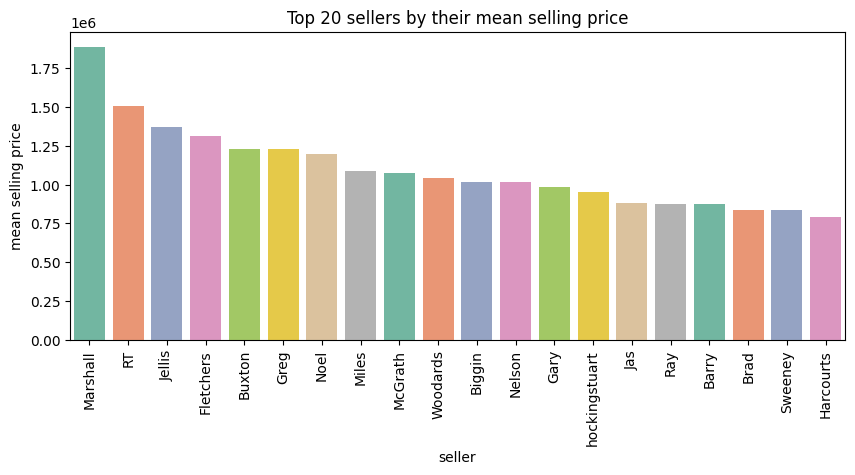

In [286]:
plt.figure(figsize=(10,4))
sns.barplot(x=top_20_seller_mean_selling_price['sellerg'],y=top_20_seller_mean_selling_price['mean_price'],hue=top_20_seller_mean_selling_price['sellerg'],palette='Set2')
plt.title('Top 20 sellers by their mean selling price')
plt.xlabel('seller')
plt.ylabel('mean selling price')
plt.xticks(rotation=90)
plt.show()

- if we look at the both the plots, Marshal has the highest selling price due to which it's selling count drops and come at 6th position in top 20
- nelson has much lower selling price than marshal,RT due to which it sells most of the properties
- jellis has much higher selling price then nelson still it manages to be at 2nd position in selling counts
- despite harcourts has much lower selling price still it sells small number of properties and lands itself at 20th postion in top 20
- thus above plot shows a very clear relationship between the seller and the Price

date VS Price

In [287]:
df['date'].dt.year

0        2016
1        2016
2        2017
3        2017
4        2016
         ... 
13568    2017
13569    2017
13570    2017
13571    2017
13572    2017
Name: date, Length: 13573, dtype: int32

In [288]:
df['date'].dt.month_name()+'_'+df['date'].dt.month.astype(str)

0        December_12
1         February_2
2            March_3
3            March_3
4             June_6
            ...     
13568       August_8
13569       August_8
13570       August_8
13571       August_8
13572       August_8
Name: date, Length: 13573, dtype: object

In [289]:
df['year']=df['date'].dt.year
df['month']=df['date'].dt.month_name()
df['month_no']=df['date'].dt.month
df['year_month']=df['date'].dt.to_period('M').astype(str)
df.head()

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type,living_rooms,landsize_imputed,buildingarea_imputed,year,month,month_no,year_month
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-12-03,2.5,3067,2,1,1.0,202.0,126.0,-37.7996,144.9984,Northern Metropolitan,4019.0,1935.0,Yarra,Winter,urban_pro,0,202.0,126.0,2016,December,12,2016-12
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-02-04,2.5,3067,2,1,0.0,156.0,79.0,-37.8079,144.9934,Northern Metropolitan,4019.0,1900.0,Yarra,Winter,urban_pro,0,156.0,79.0,2016,February,2,2016-02
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-03-04,2.5,3067,3,2,0.0,134.0,150.0,-37.8093,144.9944,Northern Metropolitan,4019.0,1900.0,Yarra,Winter,urban_pro,0,150.0,150.0,2017,March,3,2017-03
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,2017-03-04,2.5,3067,3,2,1.0,94.0,126.0,-37.7969,144.9969,Northern Metropolitan,4019.0,1935.0,Yarra,Winter,urban_pro,0,150.0,126.0,2017,March,3,2017-03
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,2016-06-04,2.5,3067,3,1,2.0,120.0,142.0,-37.8072,144.9941,Northern Metropolitan,4019.0,2014.0,Yarra,Summer,urban_pro,1,150.0,142.0,2016,June,6,2016-06


In [290]:
year_price_group=df.groupby(['year'],as_index=False).agg(mean_price=('price','mean')).sort_values(by=['year']).reset_index().drop(columns=['index'])
year_price_group

,year,mean_price
0,2016,1.072954e+06
1,2017,1.078431e+06


<Axes: xlabel='year', ylabel='mean_price'>

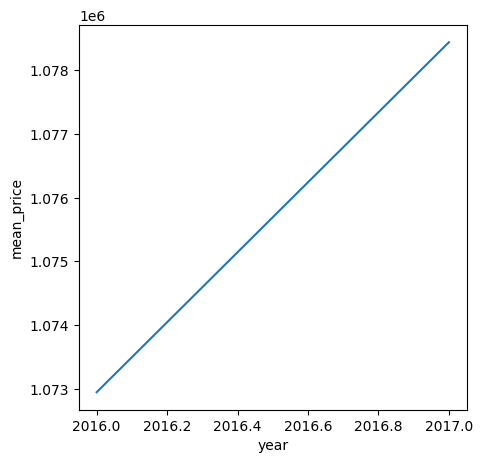

In [291]:
plt.figure(figsize=(5,5))
sns.lineplot(x=year_price_group['year'],y=year_price_group['mean_price'])

not so explainable

In [292]:
monthno_price_grouped=df.groupby(['year_month'],as_index=False).agg(mean_price=('price','mean')).sort_values(by=['year_month'],ascending=True)
monthno_price_grouped

,year_month,mean_price
0,2016-01,1.009000e+06
1,2016-02,9.081827e+05
2,2016-04,9.960432e+05
3,2016-05,1.046063e+06
4,2016-06,1.048369e+06
5,2016-07,9.412970e+05
6,2016-08,1.073529e+06
7,2016-09,1.099378e+06
8,2016-10,1.065341e+06
9,2016-11,1.117513e+06


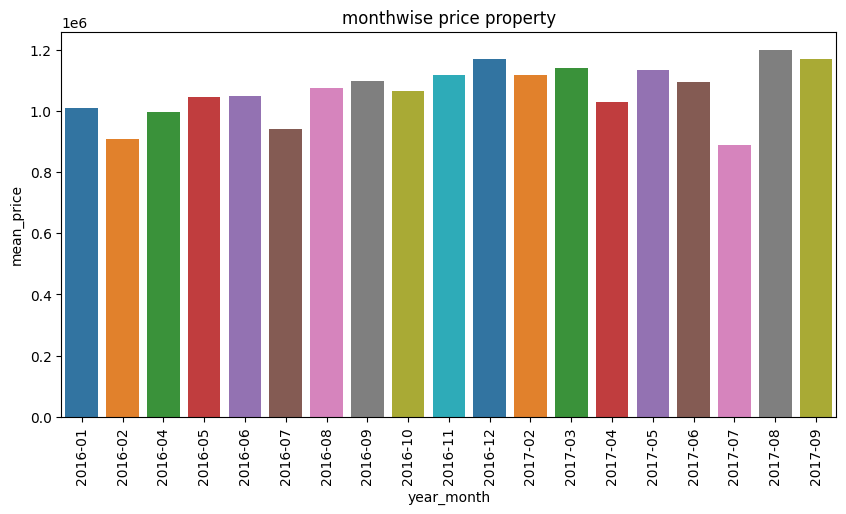

In [293]:
plt.figure(figsize=(10,5))
sns.barplot(data=monthno_price_grouped,x='year_month',y='mean_price',palette='tab10',hue='year_month')
plt.title('monthwise price property')
plt.xticks(rotation=90)
plt.show()


* though there are many ups and downs still mean_price is kind of uniformly distributed along the records dates
* lets group with season as well

In [294]:
season_ym_group=df.groupby(['season','year_month']).agg(mean_price=('price','mean')).sort_values(by=['year_month'],ascending=True)
season_ym_group

mean_price
season year_month              
Winter 2016-01     1.009000e+06
       2016-02     9.081827e+05
Summer 2016-04     9.960432e+05
       2016-05     1.046063e+06
       2016-06     1.048369e+06
       2016-07     9.412970e+05
       2016-08     1.073529e+06
       2016-09     1.099378e+06
Winter 2016-10     1.065341e+06
       2016-11     1.117513e+06
       2016-12     1.170918e+06
       2017-02     1.116604e+06
       2017-03     1.141256e+06
Summer 2017-04     1.029317e+06
       2017-05     1.134087e+06
       2017-06     1.095005e+06
       2017-07     8.874402e+05
       2017-08     1.199311e+06
       2017-09     1.170431e+06

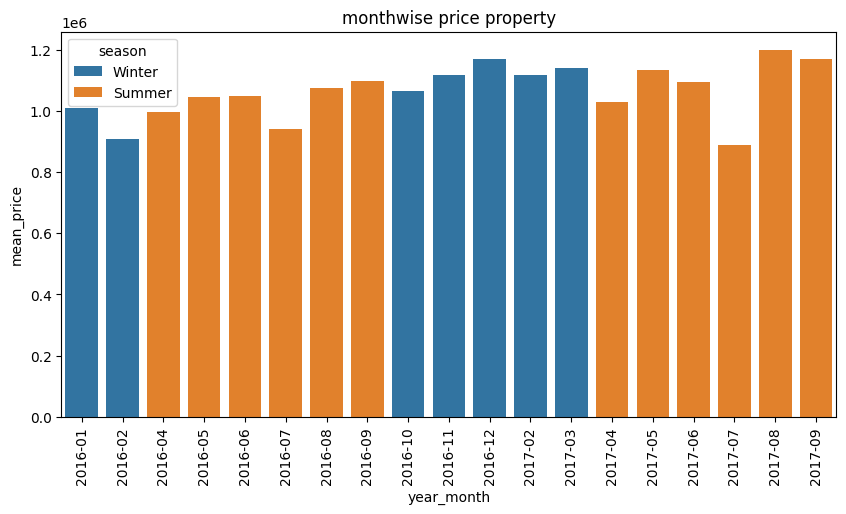

In [295]:
plt.figure(figsize=(10,5))
sns.barplot(data=season_ym_group,x='year_month',y='mean_price',palette='tab10',hue='season')
plt.title('monthwise price property')
plt.xticks(rotation=90)
plt.show()


* looking at above plot, i can say that there is no such effect of season,month on price of the property

we have not addressed towards 'address' column till now,lets inpect it

In [296]:
df['address']

0            85 Turner St
1         25 Bloomburg St
2            5 Charles St
3        40 Federation La
4             55a Park St
               ...       
13568        12 Strada Cr
13569       77 Merrett Dr
13570         83 Power St
13571        96 Verdon St
13572          6 Agnes St
Name: address, Length: 13573, dtype: object

In [297]:
df.duplicated(subset=['address', 'suburb', 'date', 'price'], keep=False)

0        False
1        False
2        False
3        False
4        False
         ...  
13568    False
13569    False
13570    False
13571    False
13572    False
Length: 13573, dtype: bool

In [298]:
df[df.duplicated(subset=['address', 'suburb', 'date', 'price'], keep=False)]

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type,living_rooms,landsize_imputed,buildingarea_imputed,year,month,month_no,year_month
7769,Coburg,69 Victoria St,3,t,720000.0,PI,C21,2017-04-29,7.8,3058,3,2,2.0,531.0,112.0,-37.7424,144.9571,Northern Metropolitan,11204.0,2016.0,Moreland,Summer,urban_pro,0,531.0,112.0,2017,April,4,2017-04
7770,Coburg,69 Victoria St,3,t,720000.0,PI,Century,2017-04-29,7.8,3058,3,2,2.0,531.0,112.0,-37.7424,144.9571,Northern Metropolitan,11204.0,2016.0,Moreland,Summer,urban_pro,0,531.0,112.0,2017,April,4,2017-04


In [299]:
df = df.drop_duplicates(subset=['address', 'suburb', 'date', 'price'])
df.shape

(13572, 30)

In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13572 entries, 0 to 13572
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   suburb                13572 non-null  object        
 1   address               13572 non-null  object        
 2   rooms                 13572 non-null  int64         
 3   type                  13572 non-null  object        
 4   price                 13572 non-null  float64       
 5   method                13572 non-null  object        
 6   sellerg               13572 non-null  object        
 7   date                  13572 non-null  datetime64[ns]
 8   distance              13572 non-null  float64       
 9   postcode              13572 non-null  int64         
 10  bedroom2              13572 non-null  int64         
 11  bathroom              13572 non-null  int64         
 12  car                   13572 non-null  float64       
 13  landsize             

In [301]:
df['distance']

0         2.5
1         2.5
2         2.5
3         2.5
4         2.5
         ... 
13568    16.7
13569     6.8
13570     6.8
13571     6.8
13572     6.3
Name: distance, Length: 13572, dtype: float64

In [302]:
df['distance_round']=df['distance'].round().astype(int)

C:\Users\suman\AppData\Local\Temp\ipykernel_19324\4175321393.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_round']=df['distance'].round().astype(int)


In [303]:
distance_price_group=df.groupby(['distance_round'],as_index=False)['price'].mean().sort_values(by=['distance_round'])
distance_price_group

,distance_round,price
0,0,6.711667e+05
1,1,7.021630e+05
2,2,1.089657e+06
3,3,1.171890e+06
4,4,1.103187e+06
5,5,1.195958e+06
6,6,1.121012e+06
7,7,1.167734e+06
8,8,1.176881e+06
9,9,1.151577e+06


Text(9.444444444444445, 0.5, 'Price')

<Figure size 500x500 with 0 Axes>

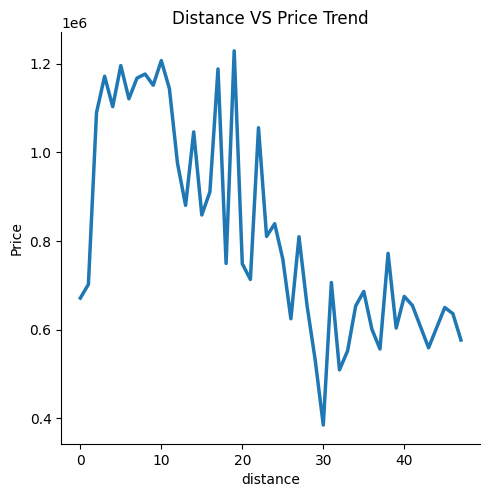

In [304]:
plt.figure(figsize=(5,5))
sns.relplot(data=distance_price_group,
            x='distance_round',
            y='price',
            kind='line',
            linewidth=2.5)
plt.title('Distance VS Price Trend')
plt.xlabel('distance')
plt.ylabel('Price')

The above plot clearly show that as the distance increases going towards outskirts from city centre of melbourne,the price of the property increases

In [305]:
bedroom_price=df.groupby(['bedroom2'],as_index=False)['price'].mean()
bedroom_price

,bedroom2,price
0,0,1.030219e+06
1,1,4.520705e+05
2,2,7.919489e+05
3,3,1.088944e+06
4,4,1.457363e+06
5,5,1.865621e+06
6,6,1.803444e+06
7,7,1.913375e+06
8,8,1.708200e+06
9,10,9.000000e+05


<Figure size 500x500 with 0 Axes>

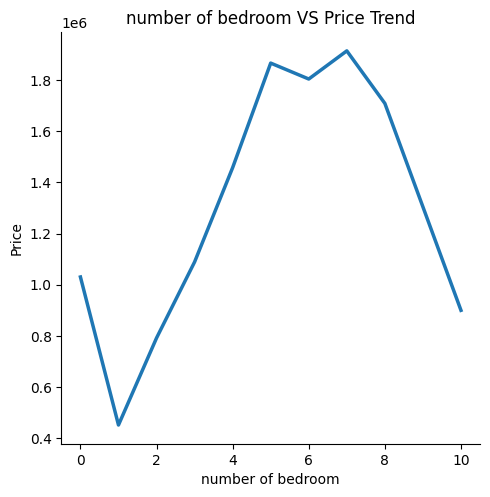

In [306]:
plt.figure(figsize=(5,5))
sns.relplot(data=bedroom_price,
            x='bedroom2',
            y='price',
            kind='line',
            linewidth=2.5)
plt.title('number of bedroom VS Price Trend')
plt.xlabel('number of bedroom')
plt.ylabel('Price')
plt.show()

the above plot shows that number of bedrooms does have effect on price of property but effect is not so strong
- lets group it with distance and again check is there any interaction effect between bedroom and distance

In [307]:
distance_bedroom_price_group=df.groupby(['distance_round','bedroom2'],as_index=False)['price'].mean()
distance_bedroom_price_group

,distance_round,bedroom2,price
0,0,2,6.711667e+05
1,1,1,4.818750e+05
2,1,2,6.676379e+05
3,1,3,9.775714e+05
4,1,4,1.120000e+06
...,...,...,...
202,45,3,6.500000e+05
203,46,3,5.932000e+05
204,46,4,7.026667e+05
205,46,6,6.500000e+05


<Figure size 1000x400 with 0 Axes>

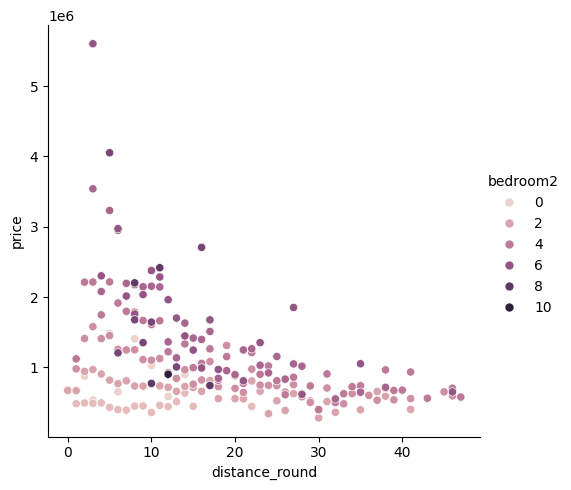

In [308]:
plt.figure(figsize=(10,4))
sns.relplot(data=distance_bedroom_price_group,x='distance_round',y='price',hue='bedroom2',kind='scatter')

from the above plot:
- we can see that distance between the property and city centre effects the price of the property heavily
- we can see that properties with more number of rooms at larger distance have lower price than those properties having less number of rooms at smaller distance from the city center
- number of rooms alone does not strongly effect the price but when grouped with distance which gives intraction effect with number of rooms effects the price heavily

In [309]:
num_cols=df.select_dtypes(include=['number']).columns.to_list()
cat_cols=df.select_dtypes(include=['category','object','datetime']).columns.to_list()
num_cols

['rooms',
 'price',
 'distance',
 'postcode',
 'bedroom2',
 'bathroom',
 'car',
 'landsize',
 'buildingarea',
 'lattitude',
 'longtitude',
 'propertycount',
 'yearbuilt',
 'living_rooms',
 'landsize_imputed',
 'buildingarea_imputed',
 'year',
 'month_no',
 'distance_round']

In [310]:
remove_num_cols=['postcode','landsize','buildingarea','distance','propertycount','year','month_no']
num_cols=[col for col in num_cols if col not in remove_num_cols]
num_cols

['rooms',
 'price',
 'bedroom2',
 'bathroom',
 'car',
 'lattitude',
 'longtitude',
 'yearbuilt',
 'living_rooms',
 'landsize_imputed',
 'buildingarea_imputed',
 'distance_round']

In [311]:
df[num_cols].corr()

,rooms,price,bedroom2,bathroom,car,lattitude,longtitude,yearbuilt,living_rooms,landsize_imputed,buildingarea_imputed,distance_round
rooms,1.000000,0.496890,0.968688,0.594264,0.408047,0.015200,0.101522,-0.015300,0.159234,-0.139041,0.558713,0.294763
price,0.496890,1.000000,0.481646,0.468827,0.234934,-0.212882,0.203896,-0.278703,0.077874,-0.084477,0.413259,-0.160609
bedroom2,0.968688,0.481646,1.000000,0.586406,0.408047,0.016612,0.103538,-0.002392,-0.090863,-0.137114,0.547564,0.305845
bathroom,0.594264,0.468827,0.586406,1.000000,0.317815,-0.072522,0.121109,0.138800,0.051886,-0.039427,0.448662,0.127185
car,0.408047,0.234934,0.408047,0.317815,1.000000,-0.002761,0.065643,0.120585,0.014169,0.023839,0.285735,0.265095
lattitude,0.015200,-0.212882,0.016612,-0.072522,-0.002761,1.000000,-0.356735,0.043599,-0.005088,-0.068830,-0.014160,-0.136032
longtitude,0.101522,0.203896,0.103538,0.121109,0.065643,-0.356735,1.000000,-0.002089,-0.004492,0.063094,0.073468,0.240279
yearbuilt,-0.015300,-0.278703,-0.002392,0.138800,0.120585,0.043599,-0.002089,1.000000,-0.051857,0.126317,-0.018700,0.281235
living_rooms,0.159234,0.077874,-0.090863,0.051886,0.014169,-0.005088,-0.004492,-0.051857,1.000000,-0.012490,0.063733,-0.033829
landsize_imputed,-0.139041,-0.084477,-0.137114,-0.039427,0.023839,-0.068830,0.063094,0.126317,-0.012490,1.000000,-0.143103,-0.057891


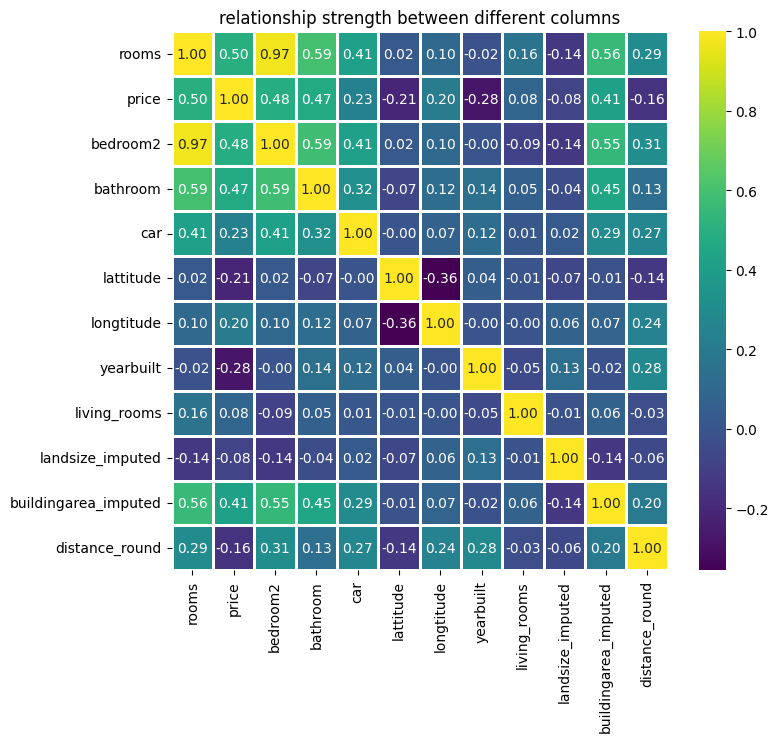

In [312]:
plt.figure(figsize=(8,7))
sns.heatmap(data=df[num_cols].corr(),annot=True,fmt='.2f',cmap='viridis',linewidths=1)
plt.title('relationship strength between different columns')
plt.show()

Correlation with Price:
- rooms - 0.50 - +ve and mild
- bedroom - 0.48 - +ve and mild
- bathrooms - 0.47 - +ve and mild
- car - 0.23 - +ve and weak
- lattitude - 0.21 - +ve and weak
- longtitude - 0.20 - +ve and weak
- yearbuilt - -.28 - -ve and weak
- living_rooms - 0.08 - +ve and weak
- landsize - -0.08 - -ve and weak
- buildingarea - 0.41 - +ve and mild
- distance - -0.16 - -ve and weak

Multicollinearity Alert: Rooms vs Bedroom2 is 0.97.

Action: We must DROP Bedroom2. It adds no new information but will confuse any future model (multicollinearity).

Price Drivers: Rooms (0.50), Bathrooms (0.47), and BuildingArea (0.41) are the strongest positive drivers.

The "Hidden" Variable: Distance shows only -0.16.
- Because correlation measures Linear lines. As we saw in our plot, the price drop is a Curve (Exponential decay), not a straight line. Also, rich suburbs far away (Brand Value) mess up the simple "Far = Cheap" rule.

# Solving Problem Statements

1. For the suburb of Altona, it is postulated that a typical property sells for $800,000. 
    - Use the data at hand to test this assumption. 
    - Is the typical property price really $800,000 or has it increased? 
    - Use a significance level of 5%.

In [313]:
df[df['suburb']=='Altona']['price'].mean()

np.float64(834830.4054054054)

In [314]:
df[df['suburb']=='Altona']['price'].std()

np.float64(291546.0454736785)

performing t-test

In [315]:
mu=800000
xbar=df[df['suburb']=='Altona']['price'].mean()
s=df[df['suburb']=='Altona']['price'].std()
n=len(df[df['suburb']=='Altona']['price'])
dof=n-1
print(f'mu : {mu}')
print(f'xbar : {xbar}')
print(f'sample_std_devn : {s}')
print(f'number of samples : {n}')
print(f'degree of freedom : {dof}')

mu : 800000
xbar : 834830.4054054054
sample_std_devn : 291546.0454736785
number of samples : 74
degree of freedom : 73


- null hypothesis: H0 : mu = 800000
- alternate hypothesis : H1 : mu >= 800000
- alpha= 0.05
- right tailed test

In [316]:
t_value=calc_t_value(n=n,mu=mu,xbar=xbar,sample_std_devn=s)
t_value

(np.float64(1.0277020770199676), 73)

In [317]:
p_value=1-stats.t.cdf(t_value[0],t_value[1])
p_value

np.float64(0.15374163565277743)

- since pvalue(0.153741....) > alpha (0.05),
- thus we fail to reject the null hypothesis,thus we dont have enough evidence to prove the null hypothesis wrong
- The price is higher (834830.40..), but with high std_devn (291546.04) and small sample size(74), it's not statistically different from 800000.

2. For the year 2016, is there any difference in the prices of properties sold in the 
summer months vs winter months? 
- Consider months from October till March as winter months and rest as 
summer months. 
- Use a significance level of 5%

In [318]:
df.head()

,suburb,address,rooms,type,price,method,sellerg,date,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,lattitude,longtitude,regionname,propertycount,yearbuilt,councilarea,season,location_type,living_rooms,landsize_imputed,buildingarea_imputed,year,month,month_no,year_month,distance_round
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-12-03,2.5,3067,2,1,1.0,202.0,126.0,-37.7996,144.9984,Northern Metropolitan,4019.0,1935.0,Yarra,Winter,urban_pro,0,202.0,126.0,2016,December,12,2016-12,2
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-02-04,2.5,3067,2,1,0.0,156.0,79.0,-37.8079,144.9934,Northern Metropolitan,4019.0,1900.0,Yarra,Winter,urban_pro,0,156.0,79.0,2016,February,2,2016-02,2
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-03-04,2.5,3067,3,2,0.0,134.0,150.0,-37.8093,144.9944,Northern Metropolitan,4019.0,1900.0,Yarra,Winter,urban_pro,0,150.0,150.0,2017,March,3,2017-03,2
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,2017-03-04,2.5,3067,3,2,1.0,94.0,126.0,-37.7969,144.9969,Northern Metropolitan,4019.0,1935.0,Yarra,Winter,urban_pro,0,150.0,126.0,2017,March,3,2017-03,2
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,2016-06-04,2.5,3067,3,1,2.0,120.0,142.0,-37.8072,144.9941,Northern Metropolitan,4019.0,2014.0,Yarra,Summer,urban_pro,1,150.0,142.0,2016,June,6,2016-06,2


Performing two sample t-test

In [319]:
x1bar=df[(df['year']==2016) & (df['season']=='Summer')]['price'].mean()
x2bar=df[(df['year']==2016) & (df['season']=='Winter')]['price'].mean()
s1=df[(df['year']==2016) & (df['season']=='Summer')]['price'].std()
s2=df[(df['year']==2016) & (df['season']=='Winter')]['price'].std()
n1=len(df[(df['year']==2016) & (df['season']=='Summer')]['price'])
n2=len(df[(df['year']==2016) & (df['season']=='Winter')]['price'])
print(f"x1bar : {x1bar}")
print(f"x2bar : {x2bar}")
print(f"s1    : {s1}")
print(f"s2    : {s2}")
print(f"n1    : {n1}")
print(f"n2    : {n2}")

x1bar : 1048054.7286917741
x2bar : 1116647.5917391304
s1    : 621493.4398118111
s2    : 695498.2768521267
n1    : 4036
n2    : 2300


- 1- winter
- 2- summer
- null hypotheis : H0 : mu1-mu2 = 0
- alternate hypotheis : H1 : mu1-mu2 != 0
- alpha=0.05
- two tailed test
- mu1=mu2=0

In [320]:
t_value=calc_two_sample_t_value(mu1=0,mu2=0,x1bar=x1bar,x2bar=x2bar,sample_std_devn1=s1,sample_std_devn2=s2,n1=n1,n2=n2)
t_value

(np.float64(-3.9211012778003744), np.float64(4353.7111264124105))

In [321]:
p_value=2*(1-stats.t.cdf(abs(t_value[0]),t_value[1]))
p_value

np.float64(8.950129747464786e-05)

- since pvalue(8.950129747464786e-05) < alpha(0.05)
- thus we reject the null hypothesis,thus we don't have enough evidence that both the means are equal
- there is statistically significant difference in price ofproperty which are sold in Summer VS Winter
- properties sold in winter are more expensive than those sold in summer

3. For the suburb of Abbotsford, what is the probability that out of 10 properties sold, 
3 will not have a car parking space? 
- Use the column car in the dataset. 
- Round off your answer to 3 decimal places

In [322]:
abbotsford=df[df['suburb']=='Abbotsford']
total_props=len(abbotsford)
no_car_props=len(abbotsford[abbotsford['car']==0])
p_no_car=no_car_props/total_props
print(f"Total Abbotsford Properties: {total_props}")
print(f"No Car Properties: {no_car_props}")
print(f"Probability (p): {p_no_car:.4f}")

Total Abbotsford Properties: 56
No Car Properties: 15
Probability (p): 0.2679


- n=10
- k=3
- p=p_no_car

In [323]:
p_3_no_car=stats.binom.pmf(n=10,k=3,p=p_no_car)
print(f"\nAnswer: The probability that 3 out of 10 have no car is: {p_3_no_car:.3f}")


Answer: The probability that 3 out of 10 have no car is: 0.260


4. In the suburb of Abbotsford, what are the chances of finding a property with 3 
rooms? Round your answer to 3 decimal places.

In [324]:
prop_3_rooms=len(abbotsford[abbotsford['rooms']==3])
total_props=len(abbotsford)
probability=prop_3_rooms/total_props

print(f"Total Abbotsford Properties: {total_props}")
print(f"Properties with 3 Rooms:     {prop_3_rooms}")
print(f"Probability: {probability:.3f}")

Total Abbotsford Properties: 56
Properties with 3 Rooms:     20
Probability: 0.357


5. In the suburb of Abbotsford, what are the chances of finding a property with 2 
bathrooms? Round your answer to 3 decimal places.

In [325]:
prop_2_bathroom=len(abbotsford[abbotsford['bathroom']==2])
total_props=len(abbotsford)
probability=prop_2_bathroom/total_props

print(f"Total Abbotsford Properties: {total_props}")
print(f"Properties with 2 bathooms:     {prop_2_bathroom}")
print(f"Probability: {probability:.3f}")

Total Abbotsford Properties: 56
Properties with 2 bathooms:     19
Probability: 0.339


6. One-Sample Hypothesis Test (Industry Pricing) 

A real estate firm claims that the 
average property price in Richmond is $1,000,000. Using the dataset, test whether 
the actual average price is significantly different from this claim at a 5% significance 
level. Clearly state: 
- Null and alternative hypotheses 
- Test statistic 
- p-value 
- Final business conclusion 


performing t-test

In [326]:
mu=1000000
xbar=df[df['suburb']=='Richmond']['price'].mean()
s=df[df['suburb']=='Richmond']['price'].std()
n=len(df[df['suburb']=='Richmond']['price'])
dof=n-1
print(f'mu : {mu}')
print(f'xbar : {xbar}')
print(f'sample_std_devn : {s}')
print(f'number of samples : {n}')
print(f'degree of freedom : {dof}')

mu : 1000000
xbar : 1083564.423076923
sample_std_devn : 522353.52451109583
number of samples : 260
degree of freedom : 259


- null hypothesis: H0 : mean_price is 1000000
    - H0 : mu = 1000000
- alternate hypothesis : H1 mean price is not 1000000 
    - H1 : mu != 1000000
- alpha= 0.05
- two tailed test

In [327]:
tvalue=calc_t_value(n=n,mu=mu,xbar=xbar,sample_std_devn=s)
tvalue

(np.float64(2.5795477040749226), 259)

In [328]:
pvalue=2*(1-stats.t.cdf(abs(tvalue[0]),tvalue[1]))
pvalue

np.float64(0.010444990664152165)

- since pvalue(0.010444990664152165) < alpha(0.05)
- thus we reject the null hypothesis,we have enough statistical evidence that there is significant difference in both the means
- The real estate firm's claim is incorrect.the price of properties in "Richmond" suburb is statistically higher(1083564.42) with std_devn(522353.52)

7. Independent Two-Sample T-Test (Feature Impact) 

Do properties with car parking sell at a higher average price than properties without 
car parking, across the entire dataset? 

Use a 5% significance level and justify: 
- Choice of test 
- Interpretation of p-value 
- Business implications for developers

In [344]:
x1bar=df[df['car']>0]['price'].mean()
x2bar=df[df['car']==0]['price'].mean()
s1=df[df['car']>0]['price'].std()
s2=df[df['car']==0]['price'].std()
n1=len(df[df['car']>0]['price'])
n2=len(df[df['car']==0]['price'])
print(f"x1bar : {x1bar}")
print(f"x2bar : {x2bar}")
print(f"s1    : {s1}")
print(f"s2    : {s2}")
print(f"n1    : {n1}")
print(f"n2    : {n2}")

x1bar : 1074678.748798462
x2bar : 1089923.0689338236
s1    : 649250.554055559
s2    : 513113.1634994254
n1    : 12484
n2    : 1088


performing t-test
- t-test - becuase when the number of samples is greater than 30 , t-stat and z-stat are approximately equal

- 1- with parking
- 2- without parking
- null hypotheis : H0 : mu1 - mu2 <= 0 (Parking adds no value)
- alternate hypotheis : H1 : mu1 - mu2 > 0 (Parking adds  value)
- alpha=0.05
- right tailed test
- mu1=mu2=0

In [330]:
tvalue=calc_two_sample_t_value(mu1=0,mu2=0,x1bar=x1bar,x2bar=x2bar,sample_std_devn1=s1,sample_std_devn2=s2,n1=n1,n2=n2)
tvalue

(np.float64(-0.9180072476210135), np.float64(1409.1163607534447))

In [331]:
pvalue=1-stats.t.cdf(tvalue[0],tvalue[1])
pvalue

np.float64(0.8206139149638831)

- since pvalue(0.8206139149638831) > alpha(0.05)
- thus we fail to reject the null hypothesis,there is not enough statistical evidence that parking adds value to the property.
- There is no statistical evidence that parking increases property price across the entire dataset. properties without parking have a higher mean price.

8. Two-Way ANOVA (Location & Property Type) 

Investigate whether property prices are influenced by: 

- Suburb 
- Type of property 
- Interaction between suburb and property type 

Use Two-Way ANOVA and explain which factors significantly affect price. 

row effect:
- null hypothesis : H0 : there is no effect of suburb on price
- alternate hypothesis : H1 : suburb effect the price

column effect
- null hypothesis : H0 : there is no effect of type on price
- alternate hypothesis : H1 : type effect the price

interaction effect:
- null hypothesis : H0 : there is no effect of type on price based on suburb
- alternate hypothesis : H1 : type effect the price based on suburb

alpha= 0.05

In [332]:
twoway_anova_test(df=df,target_col='price',row_factor='suburb',column_factor='type')

Empty cells found at [('Caulfield North', 't'), ('Eaglemont', 't'), ('Gowanbrae', 'u'), ('Kealba', 'u'), ('Kealba', 't'), ('Kooyong', 'u'), ('Kooyong', 't'), ('Melbourne', 't'), ('Middle Park', 't'), ('Southbank', 't'), ('Viewbank', 't'), ('Yallambie', 'u'), ('Yallambie', 't'), ('Bellfield', 't'), ('Burnley', 'u'), ('Burnley', 't'), ('Campbellfield', 'u'), ('Campbellfield', 't'), ('Kingsbury', 't'), ('Kingsville', 't'), ('Oakleigh', 't'), ('Docklands', 'h'), ('Strathmore Heights', 'u'), ('Strathmore Heights', 't'), ('Caulfield East', 't'), ('Seaholme', 't'), ('Gardenvale', 't'), ('Princes Hill', 'u'), ('Princes Hill', 't'), ('Bayswater North', 't'), ('Beaumaris', 'u'), ('Berwick', 'u'), ('Berwick', 't'), ('Boronia', 'u'), ('Bundoora', 'u'), ('Burnside Heights', 'u'), ('Burnside Heights', 't'), ('Cairnlea', 'u'), ('Cairnlea', 't'), ('Caroline Springs', 'u'), ('Craigieburn', 'u'), ('Cranbourne', 'u'), ('Cranbourne', 't'), ('Dandenong', 't'), ('Dandenong North', 't'), ('Diamond Creek', 'u

,source,ss,dof,ms,f_value,p_value
0,suburb,1.736669e+15,307,5.656904e+12,5.558342,1.110223e-16
1,type,9.549223e+14,2,4.774611e+14,469.142192,1.110223e-16
2,Error,1.349717e+16,13262,1.017732e+12,NaN,NaN


wait,we got missing cells due to which we did not get the interaction effect
- this happened because some of the suburbs might not have one or more type of property
- we need to manipulate the table to get the interaction effect too.
- we will remove those suburbs where one or more type of property does not exist will conduct the test using only those have all three type of property

In [333]:
pivot_counts = df.groupby(['suburb', 'type']).size().unstack(fill_value=0)
pivot_counts

type,h,t,u
suburb,,,
Abbotsford,40,2,14
Aberfeldie,32,2,10
Airport West,44,10,13
Albanvale,5,0,1
Albert Park,63,2,4
...,...,...,...
Wonga Park,1,0,0
Wyndham Vale,4,0,0
Yallambie,24,0,0


In [334]:
valid_suburbs=pivot_counts[(pivot_counts['h']>0)&(pivot_counts['t']>0)&(pivot_counts['u']>0)].index.to_list()

In [335]:
valid_suburbs

['Abbotsford',
 'Aberfeldie',
 'Airport West',
 'Albert Park',
 'Albion',
 'Alphington',
 'Altona',
 'Altona North',
 'Armadale',
 'Ascot Vale',
 'Ashburton',
 'Ashwood',
 'Avondale Heights',
 'Balaclava',
 'Balwyn',
 'Balwyn North',
 'Bayswater',
 'Bentleigh',
 'Bentleigh East',
 'Black Rock',
 'Blackburn',
 'Blackburn North',
 'Box Hill',
 'Braybrook',
 'Briar Hill',
 'Brighton',
 'Brighton East',
 'Broadmeadows',
 'Brooklyn',
 'Brunswick',
 'Brunswick East',
 'Brunswick West',
 'Bulleen',
 'Burwood',
 'Burwood East',
 'Camberwell',
 'Canterbury',
 'Carlton',
 'Carlton North',
 'Carnegie',
 'Carrum',
 'Caulfield',
 'Caulfield South',
 'Chadstone',
 'Cheltenham',
 'Clifton Hill',
 'Coburg',
 'Coburg North',
 'Collingwood',
 'Cremorne',
 'Croydon',
 'Dingley Village',
 'Doncaster',
 'Doncaster East',
 'Donvale',
 'East Melbourne',
 'Elsternwick',
 'Eltham',
 'Elwood',
 'Epping',
 'Essendon',
 'Essendon North',
 'Essendon West',
 'Fairfield',
 'Fawkner',
 'Ferntree Gully',
 'Fitzroy',
 

In [336]:
df_clean=df[df['suburb'].isin(valid_suburbs)]

In [337]:
print(f"Running ANOVA on {len(valid_suburbs)} suburbs that have all 3 property types...")
twoway_anova_test(df=df_clean,target_col='price',row_factor='suburb',column_factor='type')

Running ANOVA on 159 suburbs that have all 3 property types...
Running Two-Way ANOVA full


,source,ss,dof,ms,f_value,p_value
0,suburb,1.431368e+15,158,9.059288e+12,54.562517,1.110223e-16
1,type,1.065757e+15,2,5.328785e+14,3209.434789,1.110223e-16
2,interaction,5.779453e+14,316,1.828941e+12,11.015393,1.110223e-16
3,Error,1.898278e+15,11433,1.660350e+11,NaN,NaN


conclusion:
- row effect:
    - since pvalue(1.110223e-16) < alpha(0.05)
    - thus reject the null hypothesis that there is no effect of suburb on price

- column effect:
    - since pvalue(1.110223e-16) < alpha(0.05)
    - thus reject the null hypothesis that there is no effect of type on price

- interaction effect:
    - since pvalue(1.110223e-16) < alpha(0.05)
    - thus reject the null hypothesis that there is no effect of type on price based on suburb

- two way anova yields a p-value of approx 0 for suburb,type and interaction which confirms that both loaction and property type signficantly determines athe price of the property,the significant Interaction term proves that the price premium for different property types varies depending on the suburb (price gaps are not uniform across locations)."

9. p-Value Interpretation (Decision Making) 

A hypothesis test comparing prices across two suburbs results in a p-value of 0.032. 

Answer: 
- What does this p-value indicate? 
    - The p-value is the probability of observing a result as extreme as the one observed, assuming the null hypothesis is true. 

- Should the null hypothesis be rejected at α = 0.05? 
    - yes,null hypothesis has to be rejected at p-value of 0.032

- How should a business stakeholder interpret this result?
    - interpretation will be - since the null hypothesis is getting rejected,so there so there is significant difference in between the property prices of two suburbs

10. Industry-Style Hypothesis Validation (Policy Decision) 

A housing policy group believes that properties with more than 2 bathrooms 
command a premium price. 

Design and execute a statistical test to validate this claim: 
- Identify the correct test
- State hypotheses 
- Report p-value 
- Give a clear recommendation to policymakers

- 1 - properties with more than two bathrooms
- 2 - properties with less than or equal to two bathrooms

- null hypothesis : H0 : mu1 - mu2 <= 0 (bathrooms adds no value)

- alternate hypothesis : H1 : mu1 - mu2 > 0 (bathrooms adds  value)

- alpha=0.05
- right tailed test
- mu1=mu2=0
- right tailed test
- alpha=0.05

In [345]:
x1bar=df[df['bathroom']>2]['price'].mean()
x2bar=df[df['bathroom']<=2]['price'].mean()
s1=df[df['bathroom']>2]['price'].std()
s2=df[df['bathroom']<=2]['price'].std()
n1=len(df[df['bathroom']>2]['price'])
n2=len(df[df['bathroom']<=2]['price'])
print(f"x1bar : {x1bar}")
print(f"x2bar : {x2bar}")
print(f"s1    : {s1}")
print(f"s2    : {s2}")
print(f"n1    : {n1}")
print(f"n2    : {n2}")

x1bar : 1883322.6175637394
x2bar : 1007567.1019739471
s1    : 976983.6863371489
s2    : 550346.8210520006
n1    : 1059
n2    : 12513


will be using two-sample t-test as when sample size is > 30,t-stat approximate to z-stat

In [346]:
tvalue=calc_two_sample_t_value(mu1=0,mu2=0,x1bar=x1bar,x2bar=x2bar,sample_std_devn1=s1,sample_std_devn2=s2,n1=n1,n2=n2)
tvalue

(np.float64(28.78650156615353), np.float64(1115.5211989195034))

In [347]:
pvalue=1-stats.t.cdf(tvalue[0],tvalue[1])
pvalue

np.float64(0.0)

- since pvalue(0.0) < alpha(0.05)
- thus we reject the null hypothesis,we don't have enough statistical evidence to prove that bathrooms does not value to price
- we have strong statistical evidence to support the claim that properties having more than two bathrooms have premium price and more expensive and sells at higher average price